In [2]:
# ----------------------------------------------------------------------------
#
# TITLE - 1D_radial_DF.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Look at the power of some of the calculated triaxial DFs
'''

__author__ = "James Lane"

In [3]:
## Imports

## Basic
import numpy as np
import sys, os, pdb
import copy
import time
from tqdm import tqdm_notebook as tqdm_nb

## Plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import cm

## Astropy
from astropy import units as apu
from astropy.io import fits

## galpy
# from galpy import orbit, potential, df
# from galpy.actionAngle import actionAngleAdiabatic

## Scipy
from scipy.stats import binned_statistic_2d, binned_statistic
from scipy.optimize import curve_fit

## Add project-specific package. Assume relative location
sys.path.append('../../src/')
# import ast1501.potential
import ast1501.util
import ast1501.fourier

In [4]:
# Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Meta

## Future work

## Information

# Prepare
Declare the keywords for the analysis, make the potential, and the DF

## Keywords and File Names for Simulated Data

In [21]:
# file_base = './data/results_b'
# file_specs = ['90.npy','95.npy','98.npy','102.npy','105.npy','110.npy']
# b_values = [0.9,0.95,0.98,1.02,1.05,1.1]

file_base = './data/data'
file_specs = ['6.npy','0.npy','_09_bar.npy','1.npy','2.npy','3.npy','5.npy','7.npy']
b_values = [0.8,0.9,0.9,0.95,0.98,1.02,1.1,1.2]

files = [ file_base+spec for spec in file_specs]
n_files = len(files)
print(files)

# Plotting
file_colors = ['DodgerBlue','DarkGreen','Navy','Red','Purple','DarkOrange','MediumAquamarine','HotPink']

['./data/data6.npy', './data/data0.npy', './data/data_09_bar.npy', './data/data1.npy', './data/data2.npy', './data/data3.npy', './data/data5.npy', './data/data7.npy']


In [6]:
## Assuming all files have the same radial and phi structure get the number of radial bins
data_tmp = np.load(files[0])
R_range = np.unique(data_tmp[:,0])
R_bin_size = np.diff(R_range)[0]

## Keywords and File Names for Gaia

In [7]:
n_bs = 100

In [8]:
### Load catalogs
gaiadr2_apogee_catalog = '../../data/generated/gaiadr2-apogee_dataset.FIT'
f = fits.open(gaiadr2_apogee_catalog)
data = f[1].data

In [9]:
### Cut on galactocentric absolute Z < 0.3 kpc
where_low_z = np.where( np.abs(data['Z']) < 0.3 )[0]
data_low_z = data[where_low_z] 
z_select_text = r'$|$Z$_{GC}| < 0.3$ kpc'

In [10]:
### Read catalog values

# ID, RA, Dec, logg, abundances, errors
apid = data_low_z['APOGEE_ID']
locid = data_low_z['LOCATION_ID']
vhelio = data_low_z['VHELIO']
pmll = data_low_z['PM_LL']
pmbb = data_low_z['PM_BB']
gc_x = data_low_z['X']
gc_y = data_low_z['Y']
gc_z = data_low_z['Z']
gc_vx = data_low_z['VX']
gc_vy = data_low_z['VY']
gc_vz = data_low_z['VZ']

In [11]:
### Convert to galactocentric radius and radial velocity
gc_R = np.sqrt(np.square(gc_x)+np.square(gc_y))
gc_phi = np.arctan2(gc_y,gc_x)
gc_vR = np.cos(gc_phi)*gc_vx + np.sin(gc_phi)*gc_vy
gc_vT = -np.sin(gc_phi)*gc_vx + np.cos(gc_phi)*gc_vy
gc_phi = np.arctan2(gc_y,-gc_x)

## Tangential Velocity

./data/data6.npy
0.8


/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: Mean of empty slice
/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning: Mean of empty slice


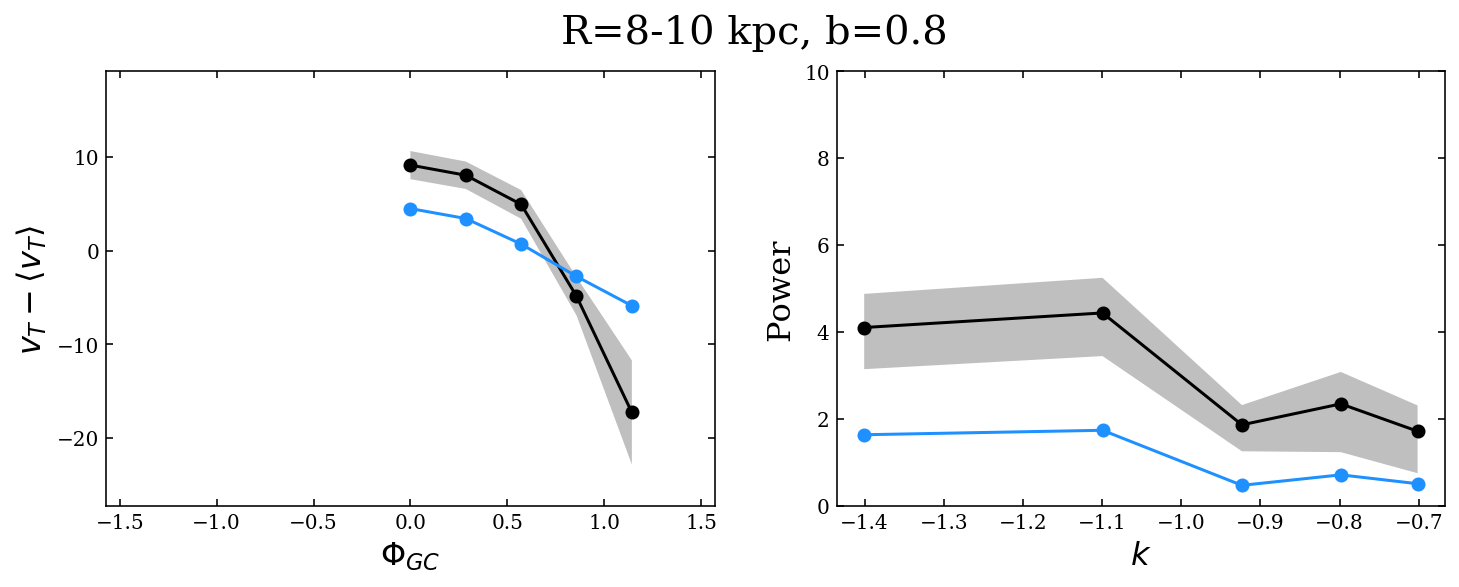

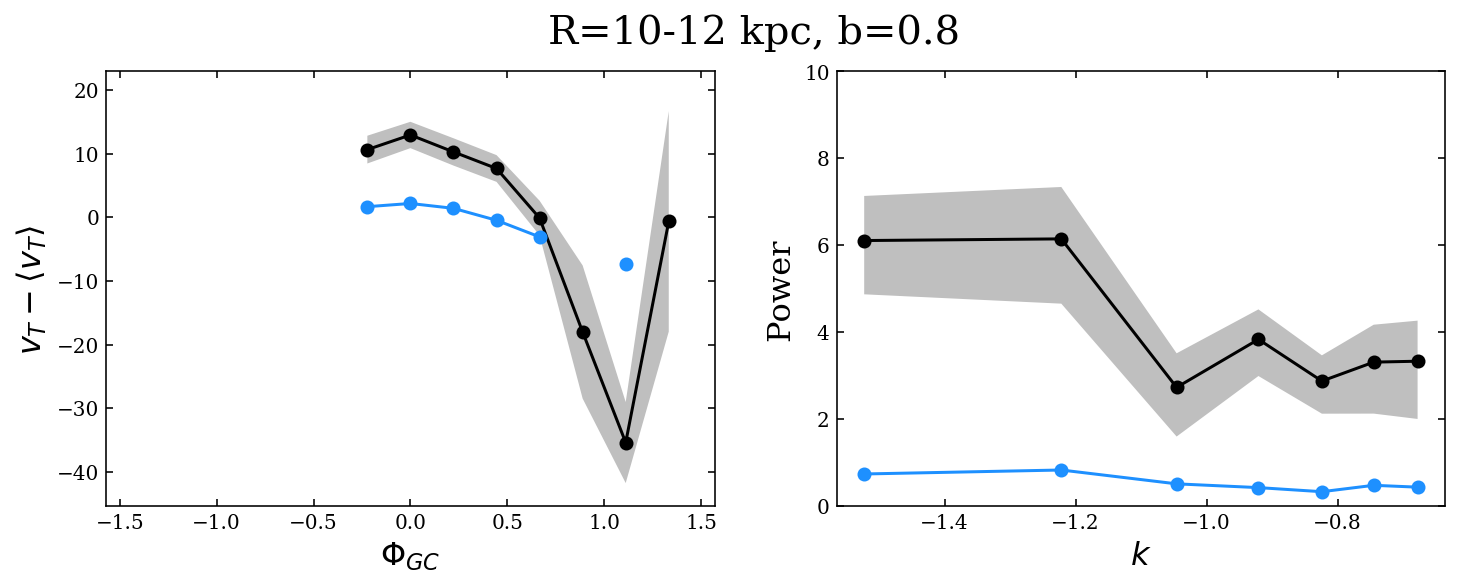

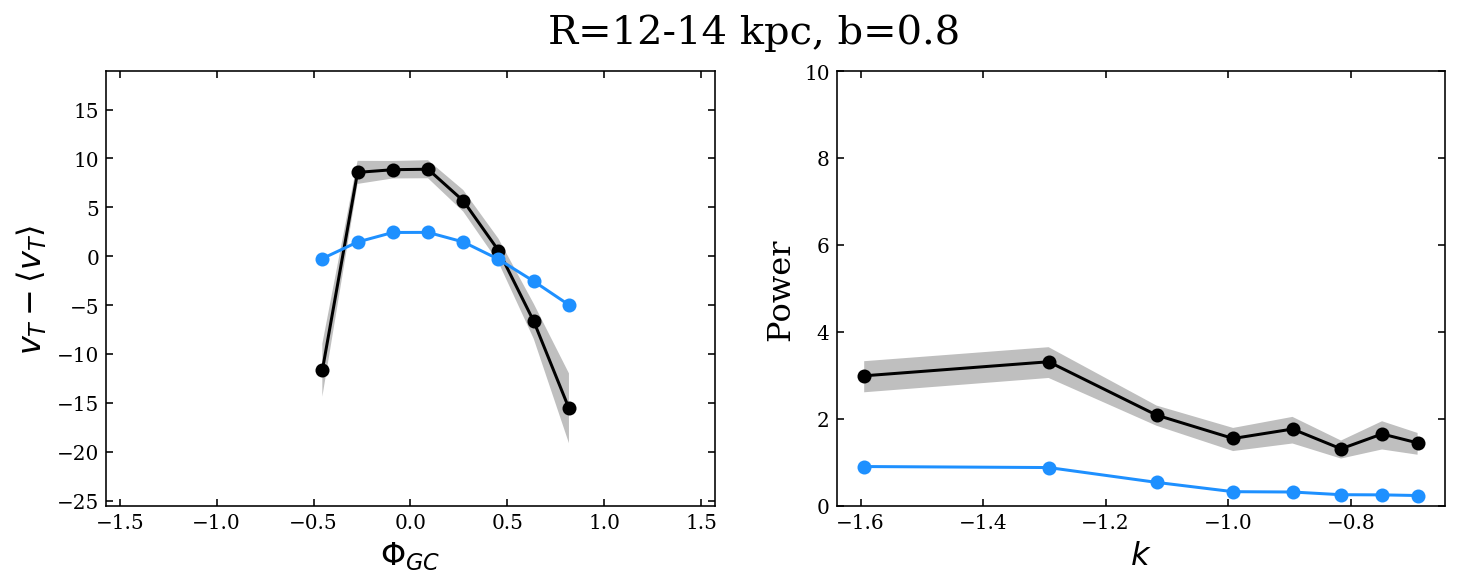

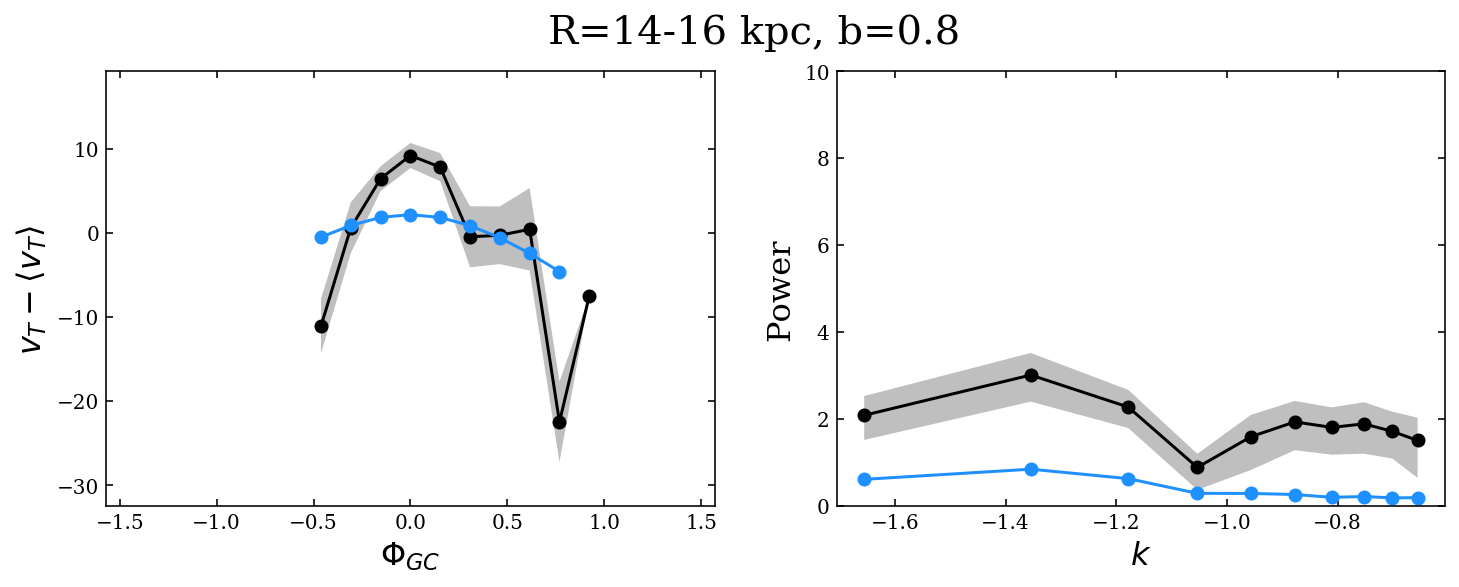



##########


./data/data0.npy
0.9


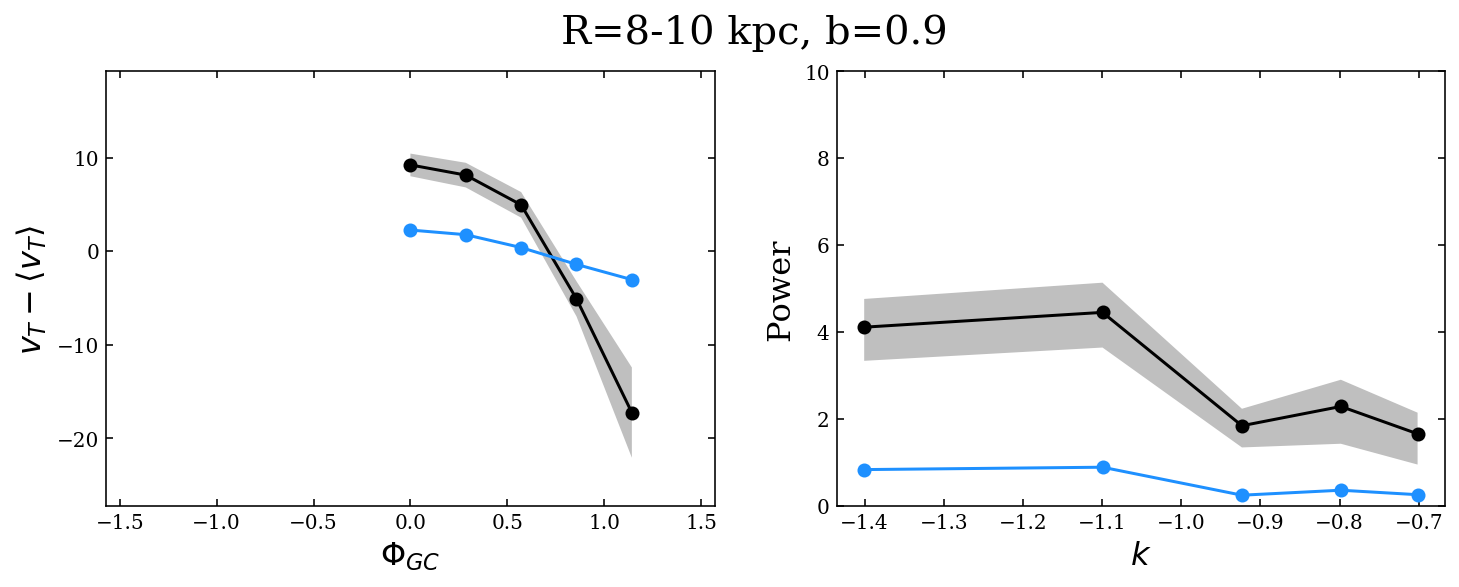

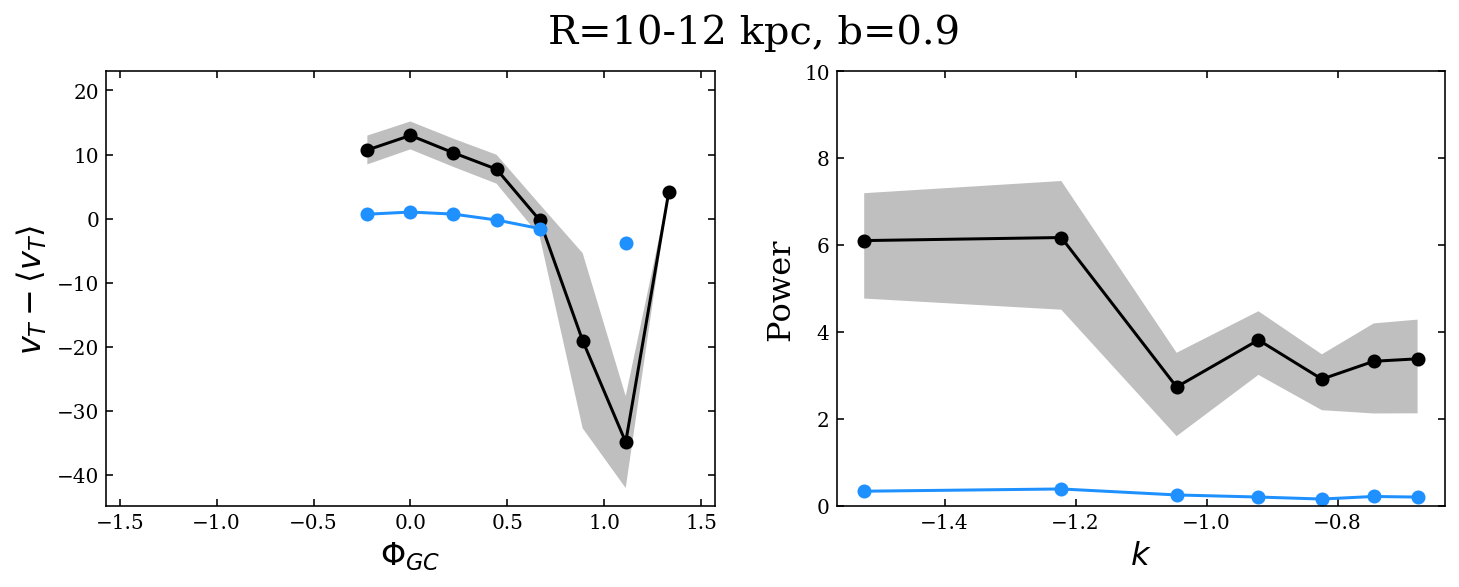

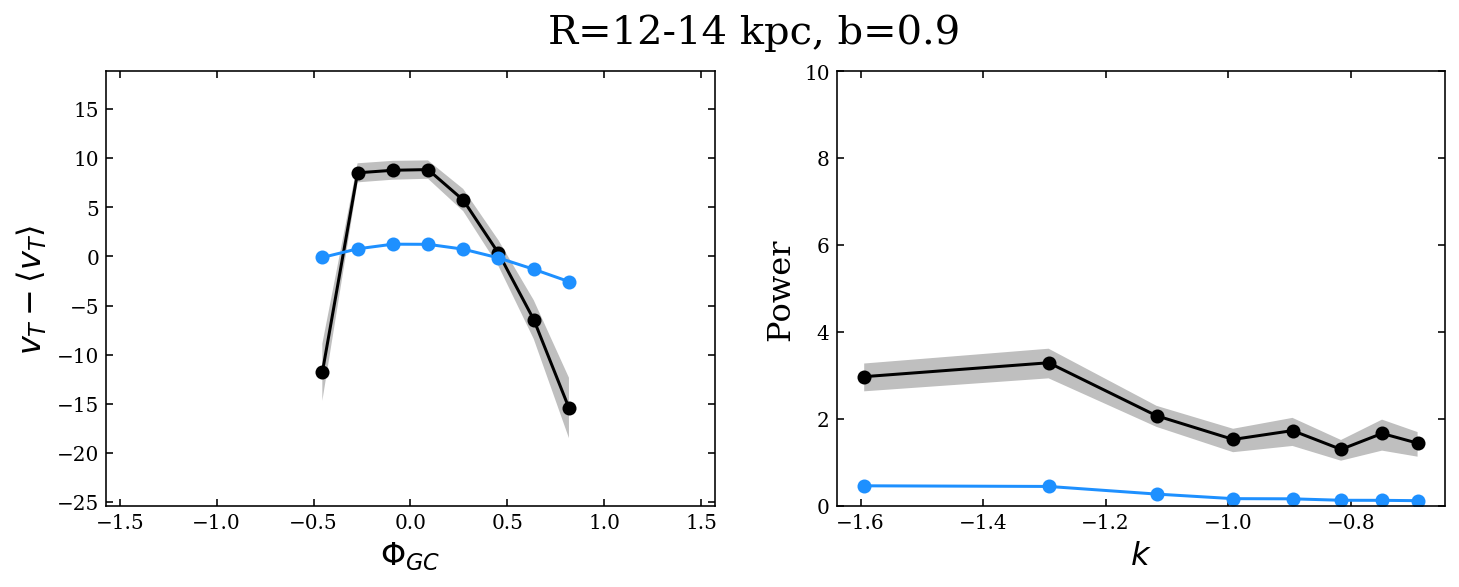

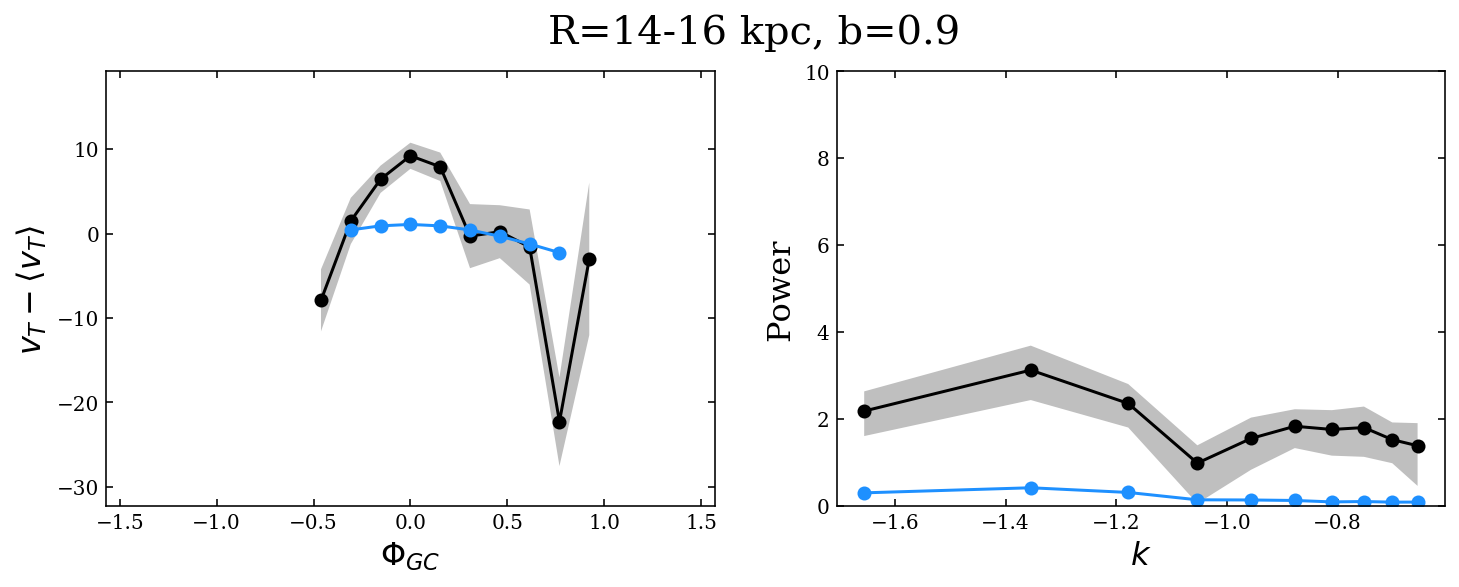



##########


./data/data_09_bar.npy
0.9


/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/ipykernel_launcher.py:137: RuntimeWarning: invalid value encountered in sqrt


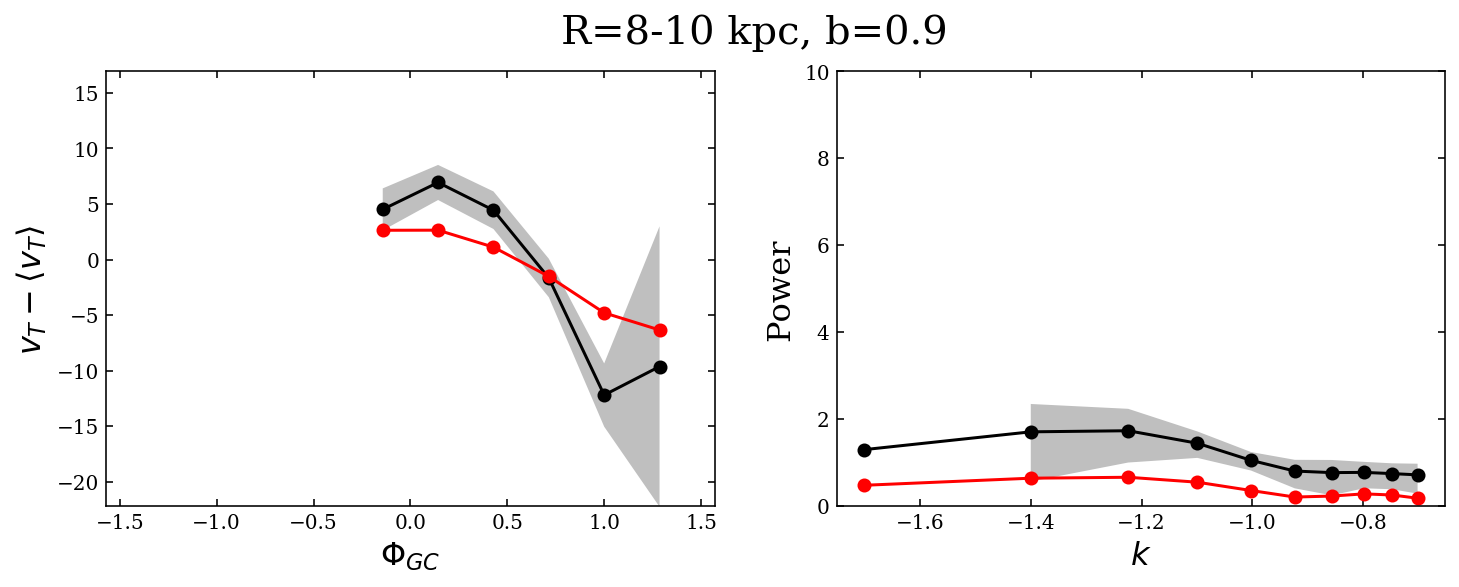

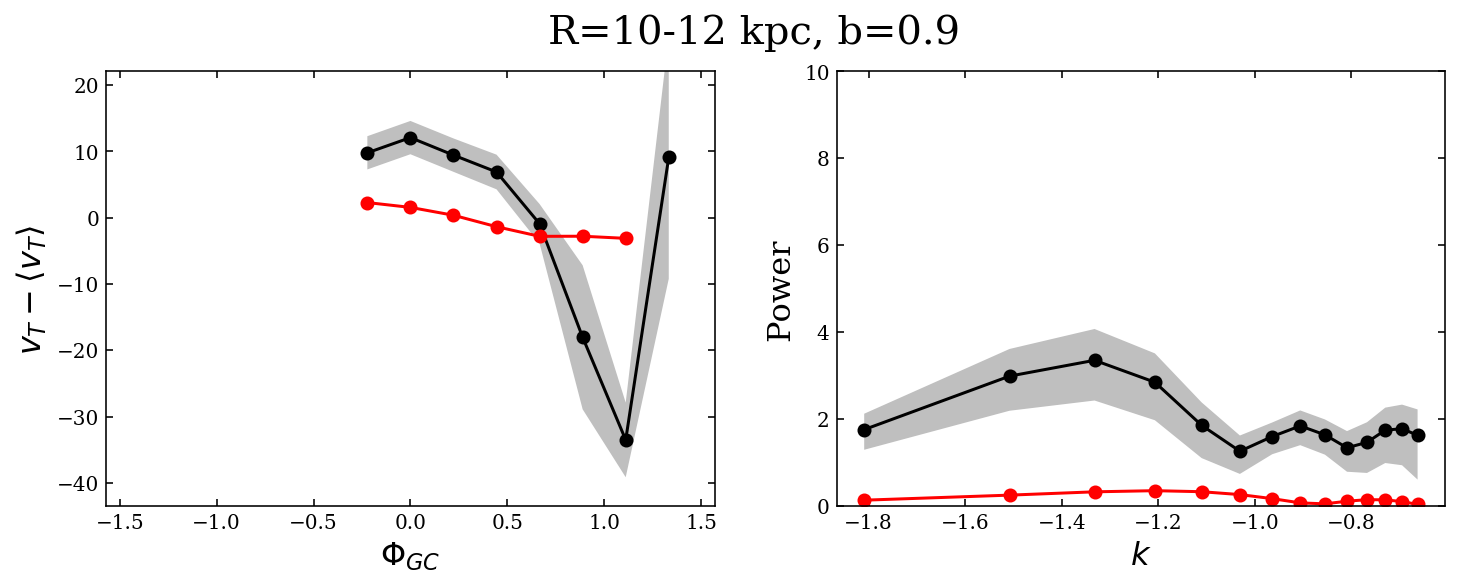

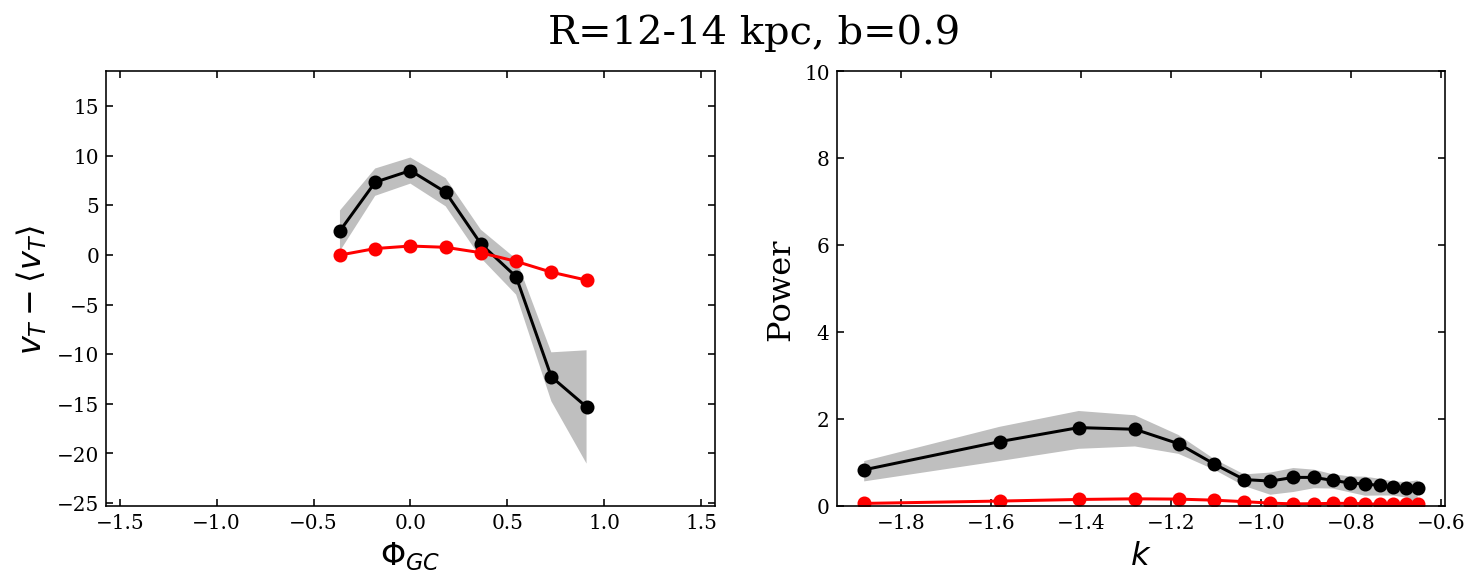

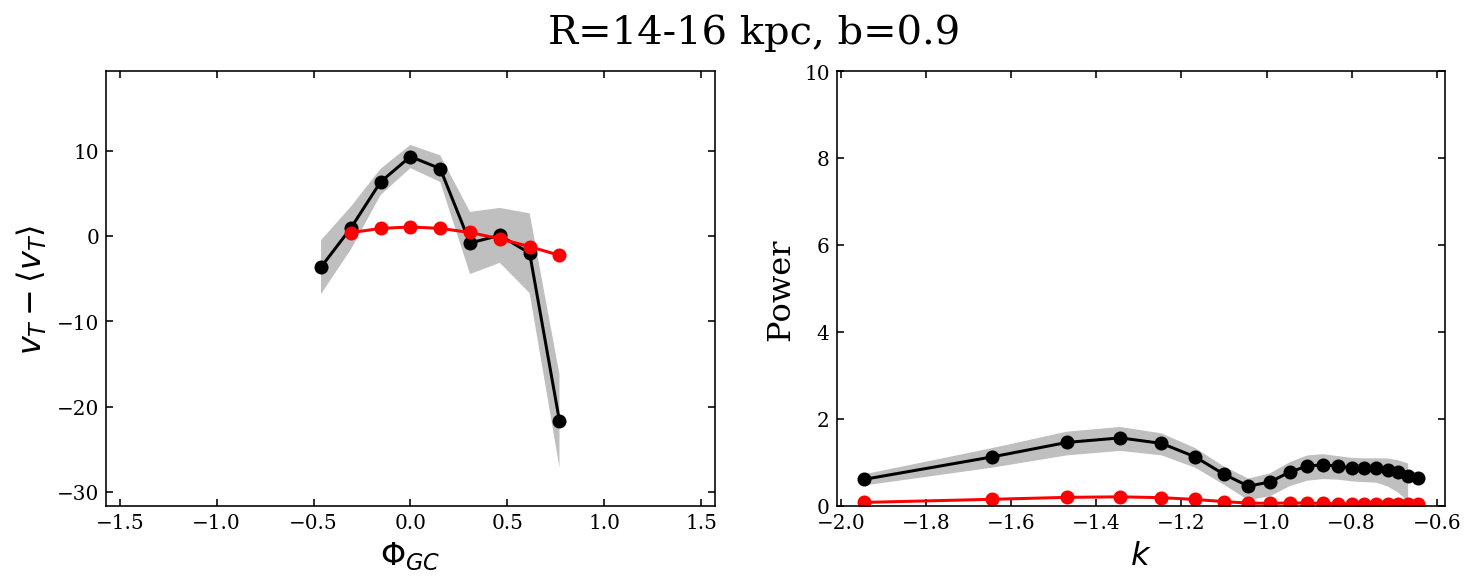



##########


./data/data1.npy
0.95


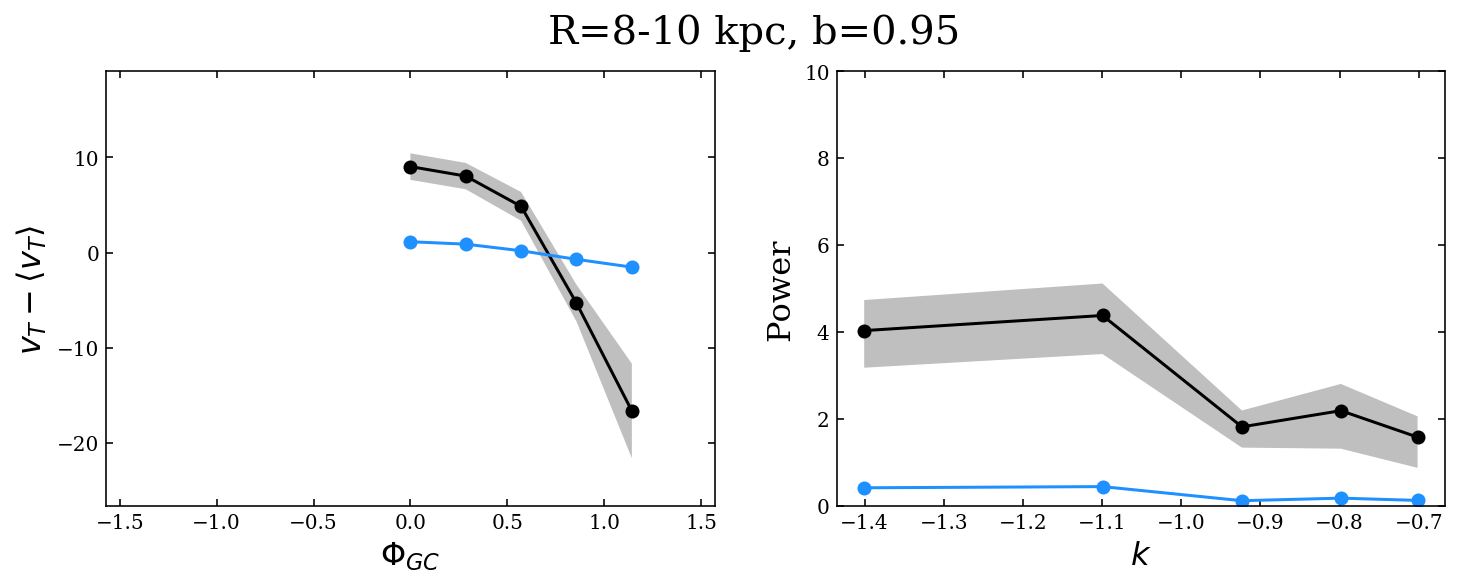

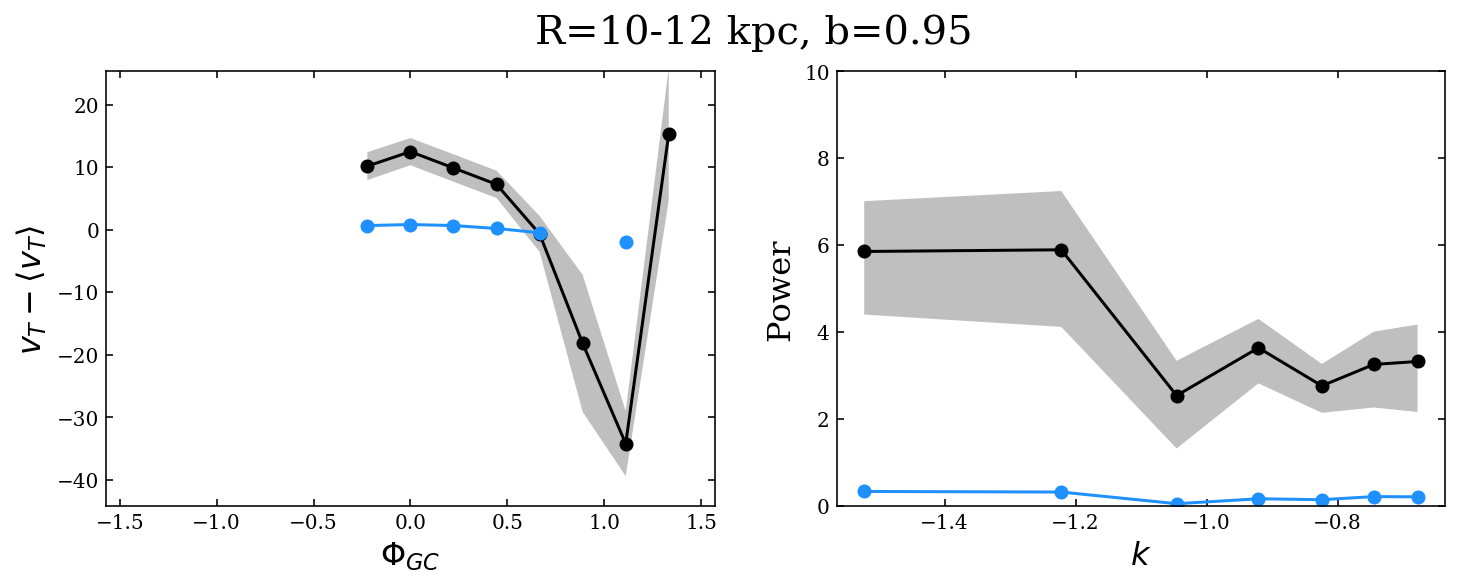

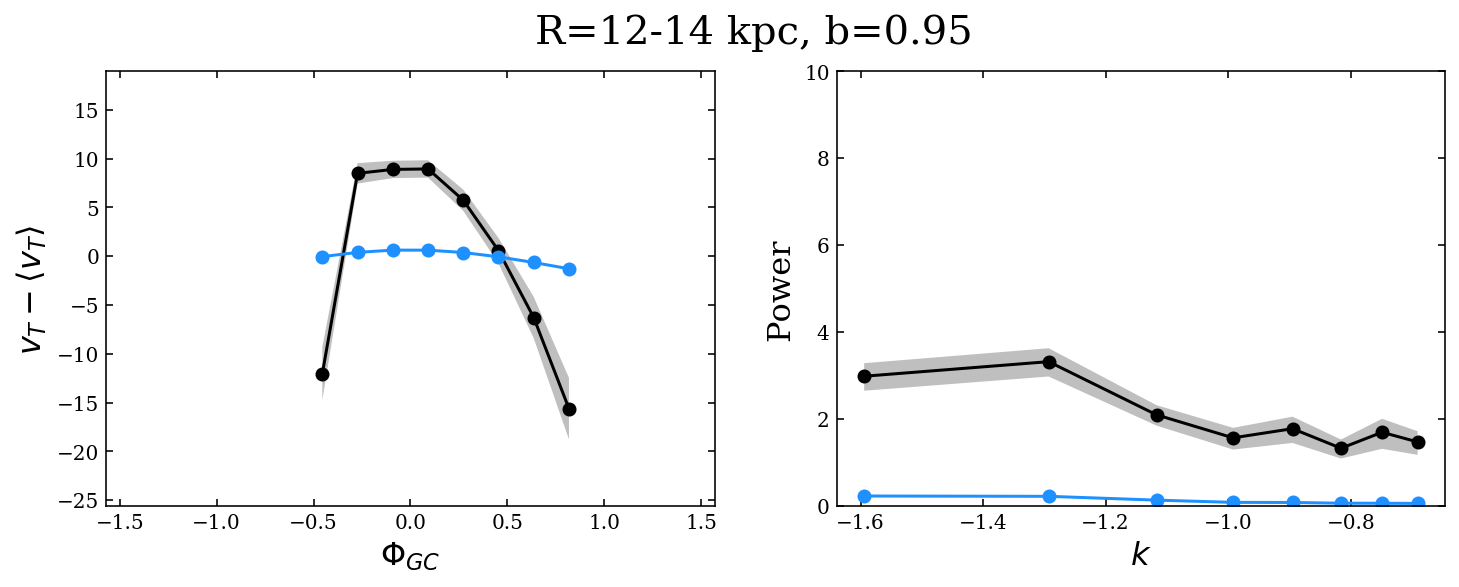

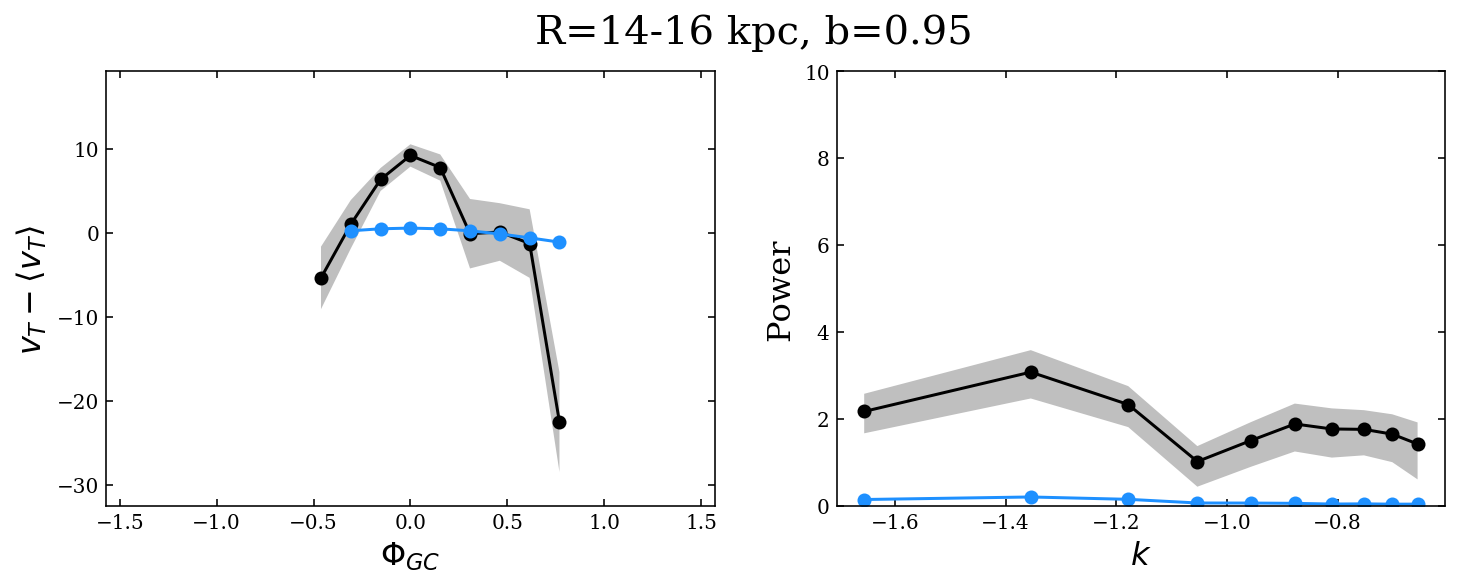



##########


./data/data2.npy
0.98


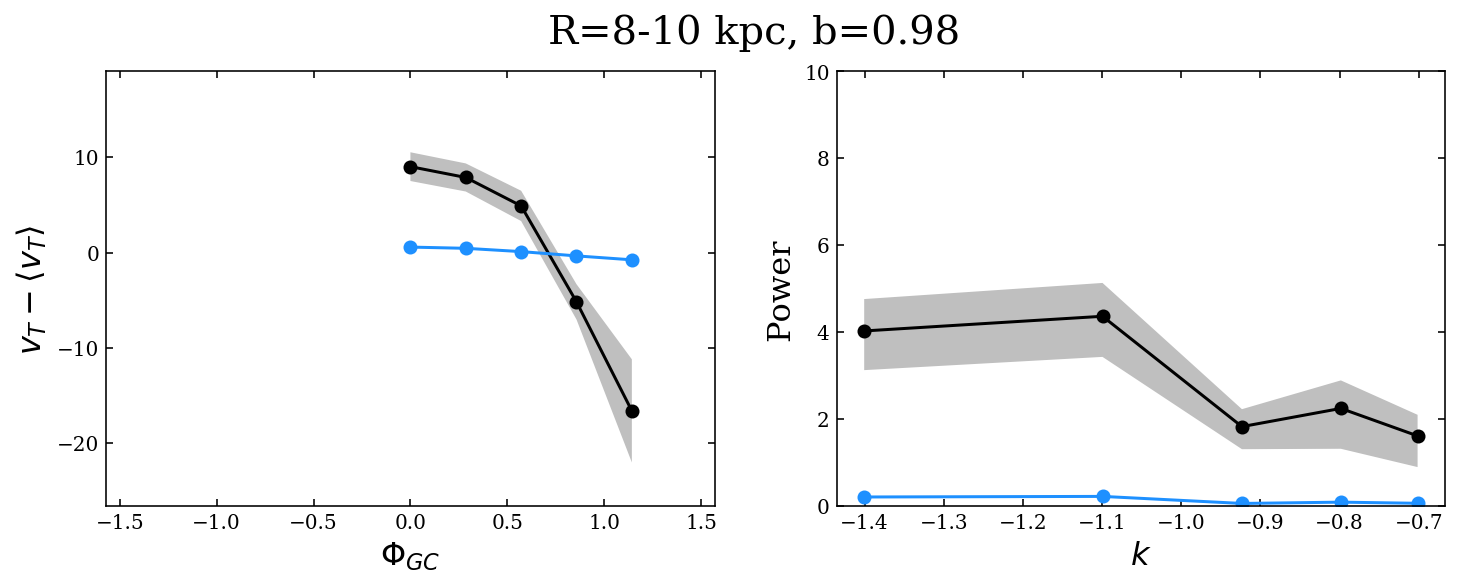

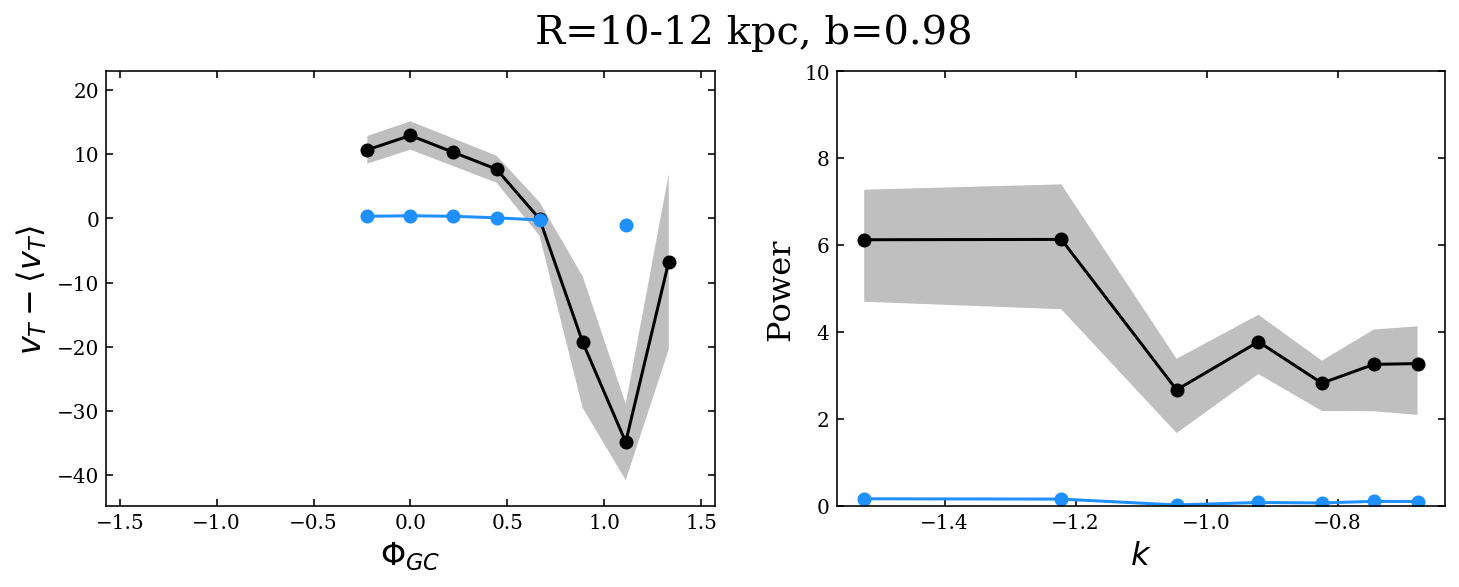

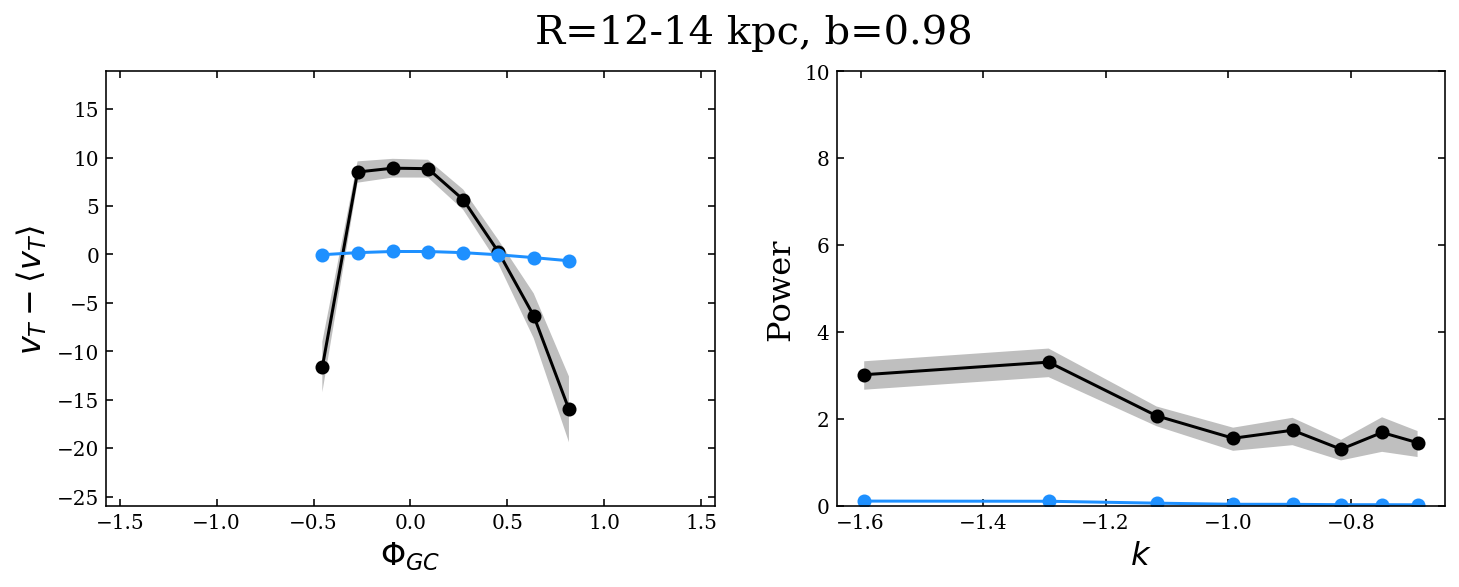

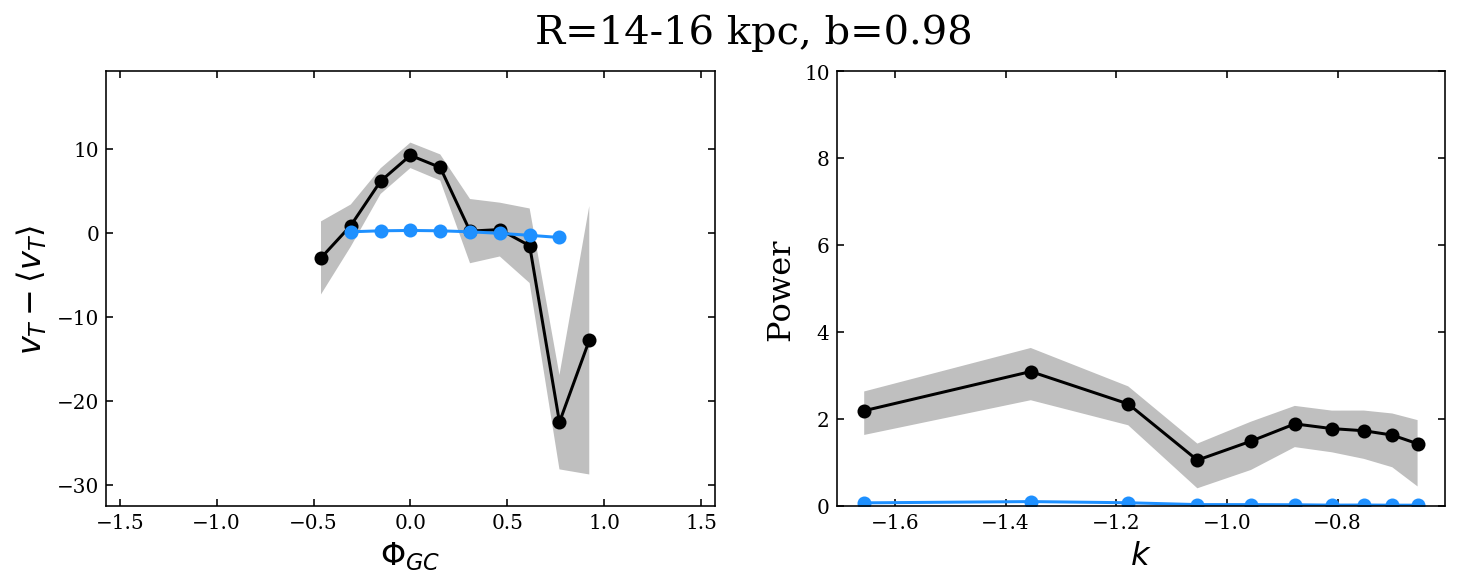



##########


./data/data3.npy
1.02


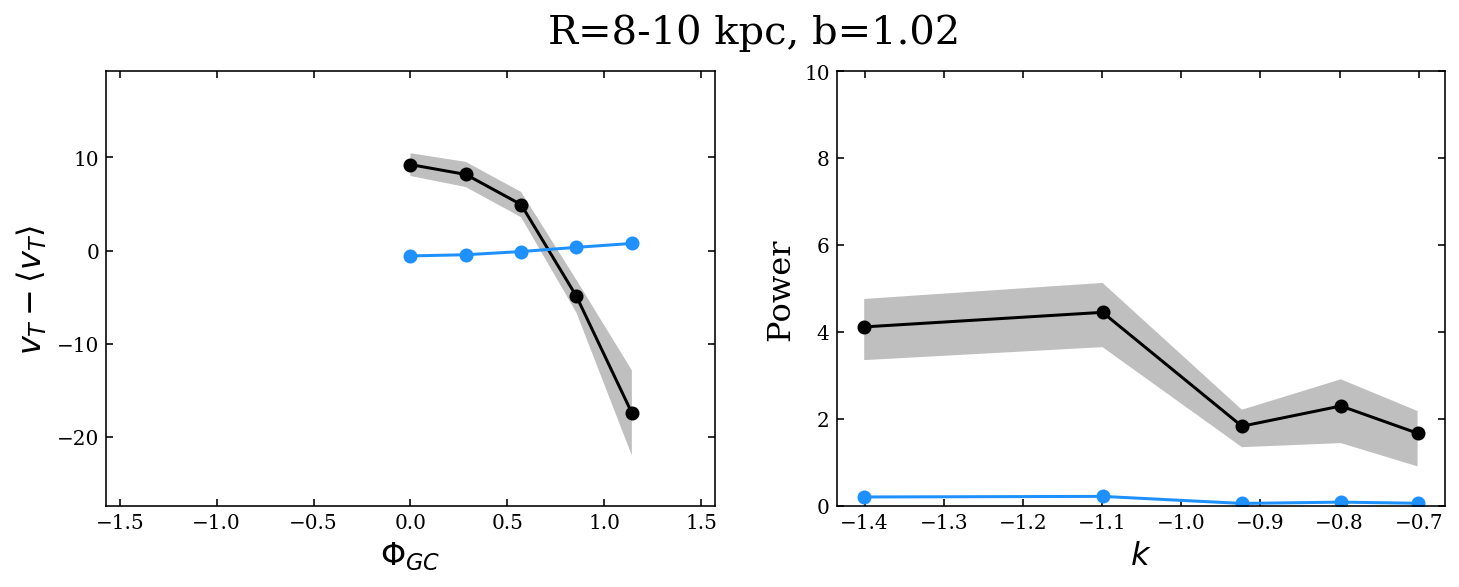

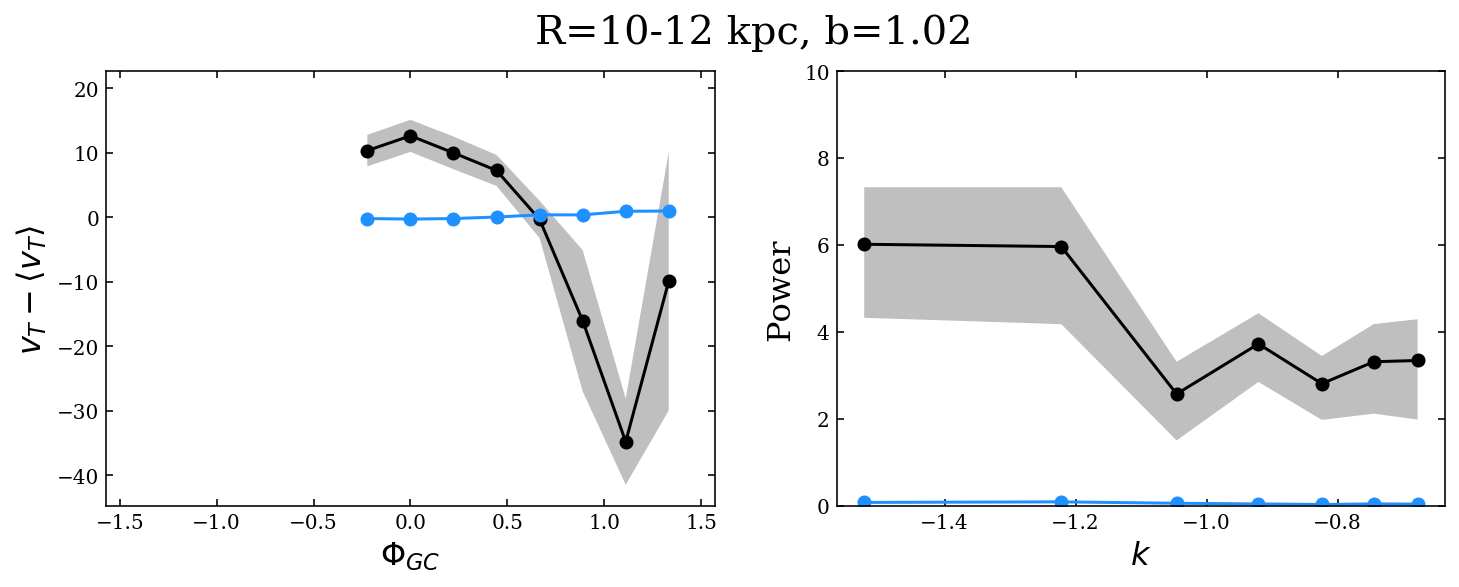

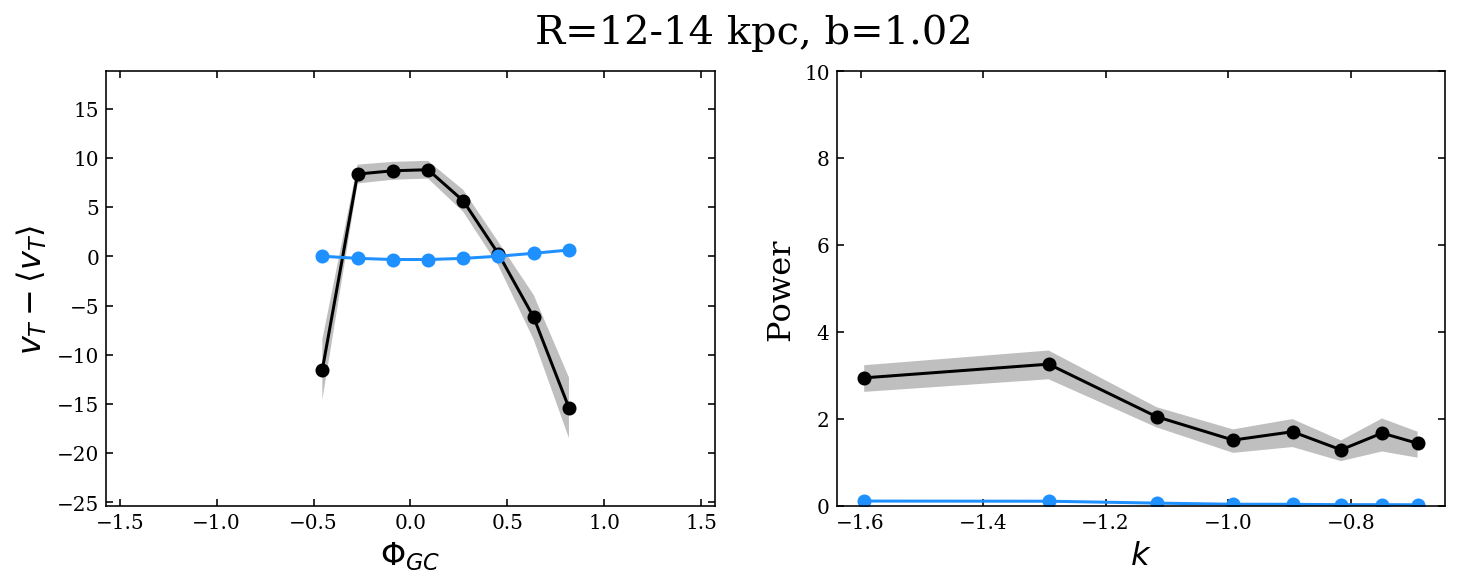

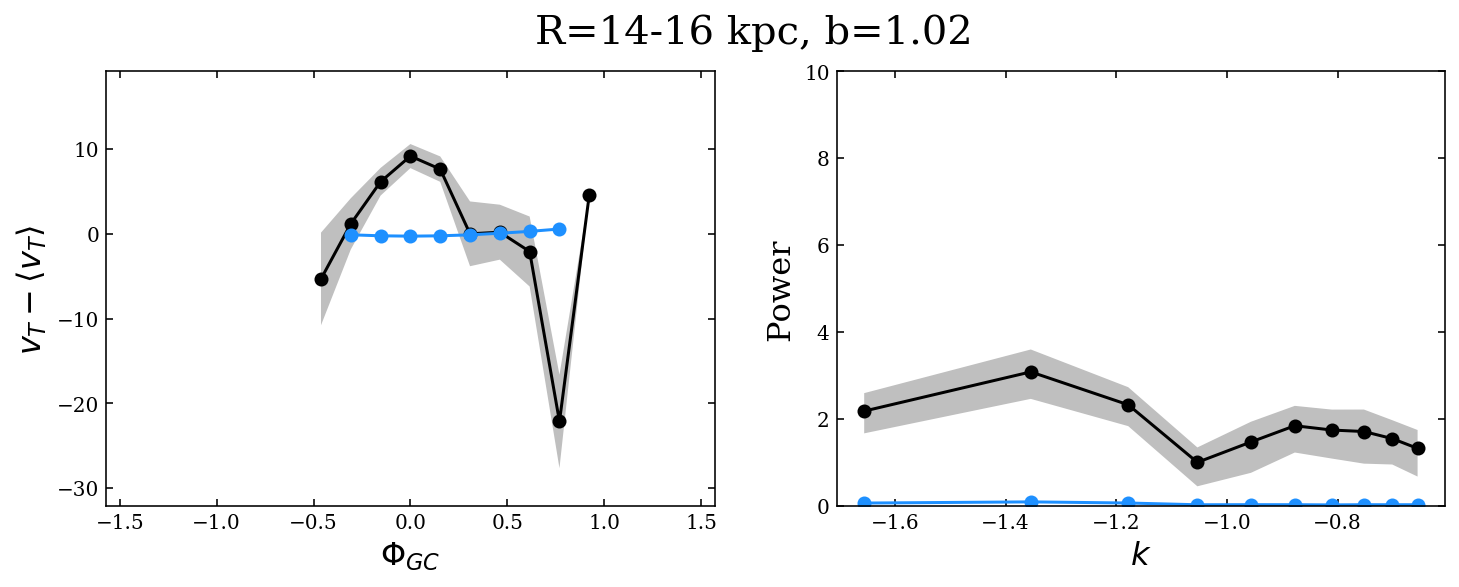



##########


./data/data5.npy
1.1


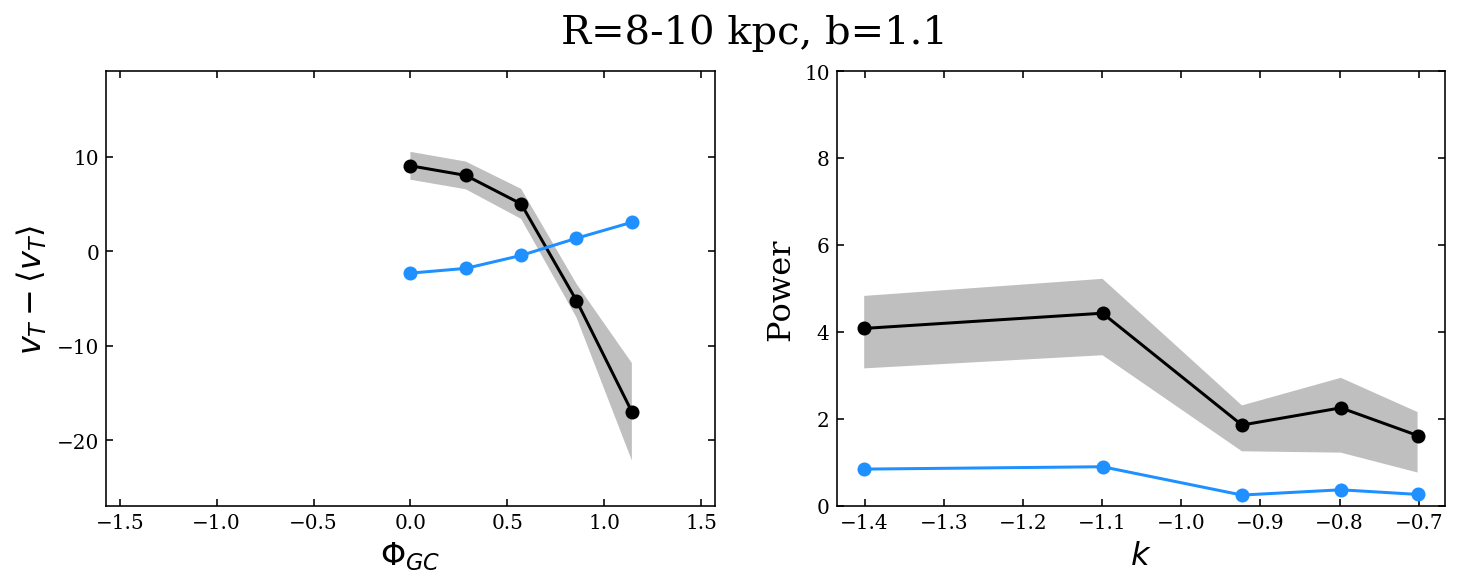

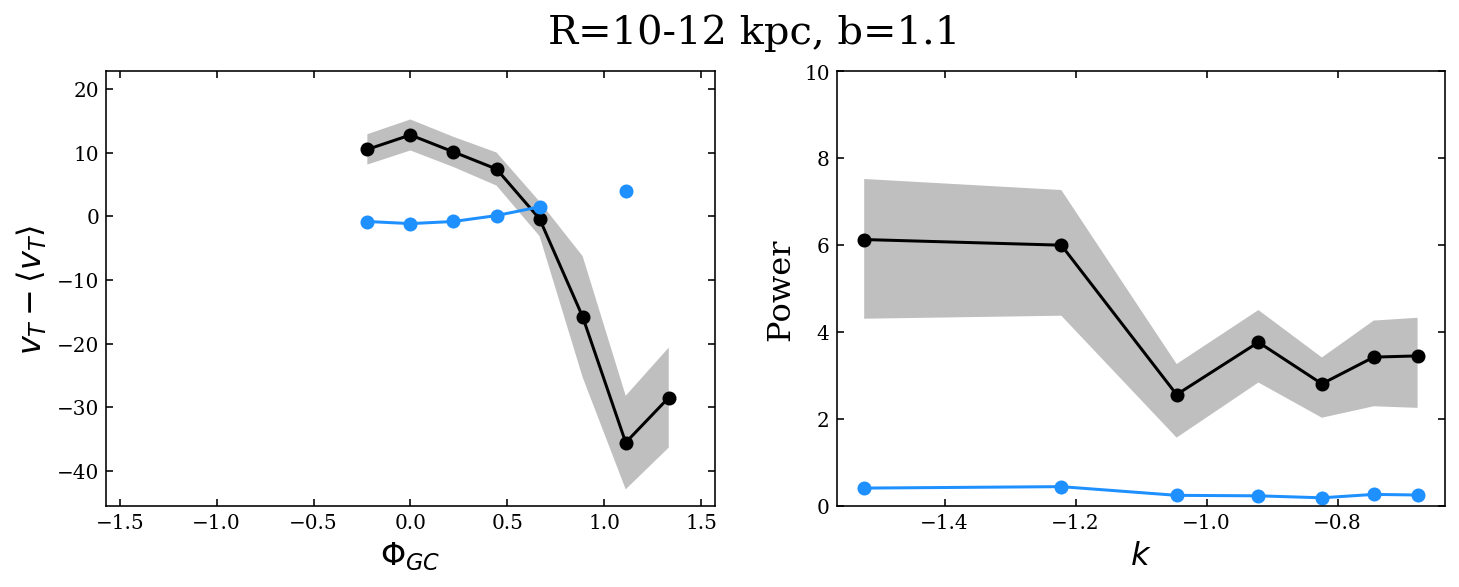

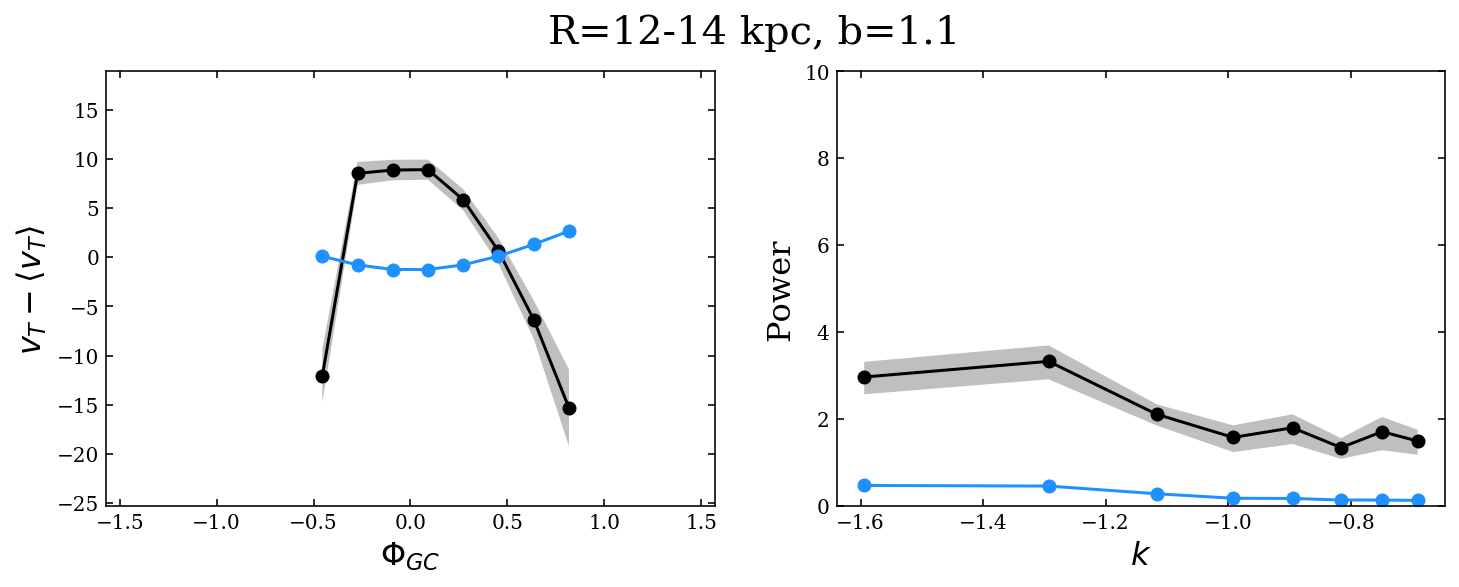

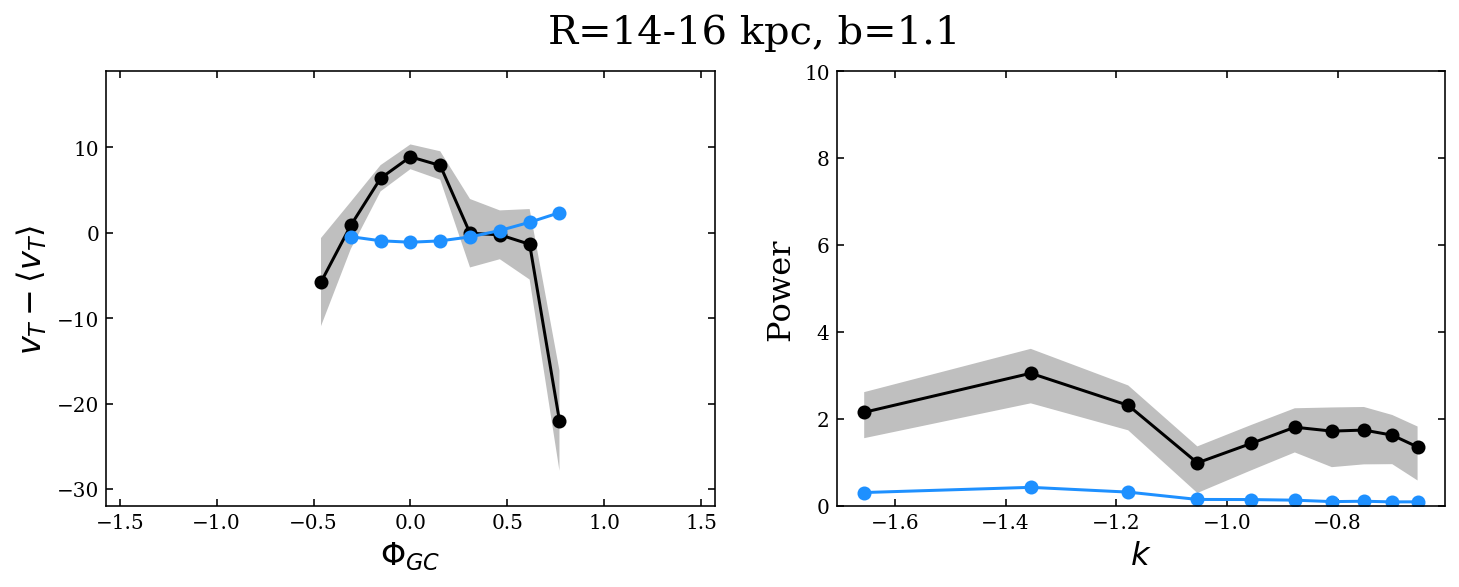



##########


./data/data7.npy
1.2


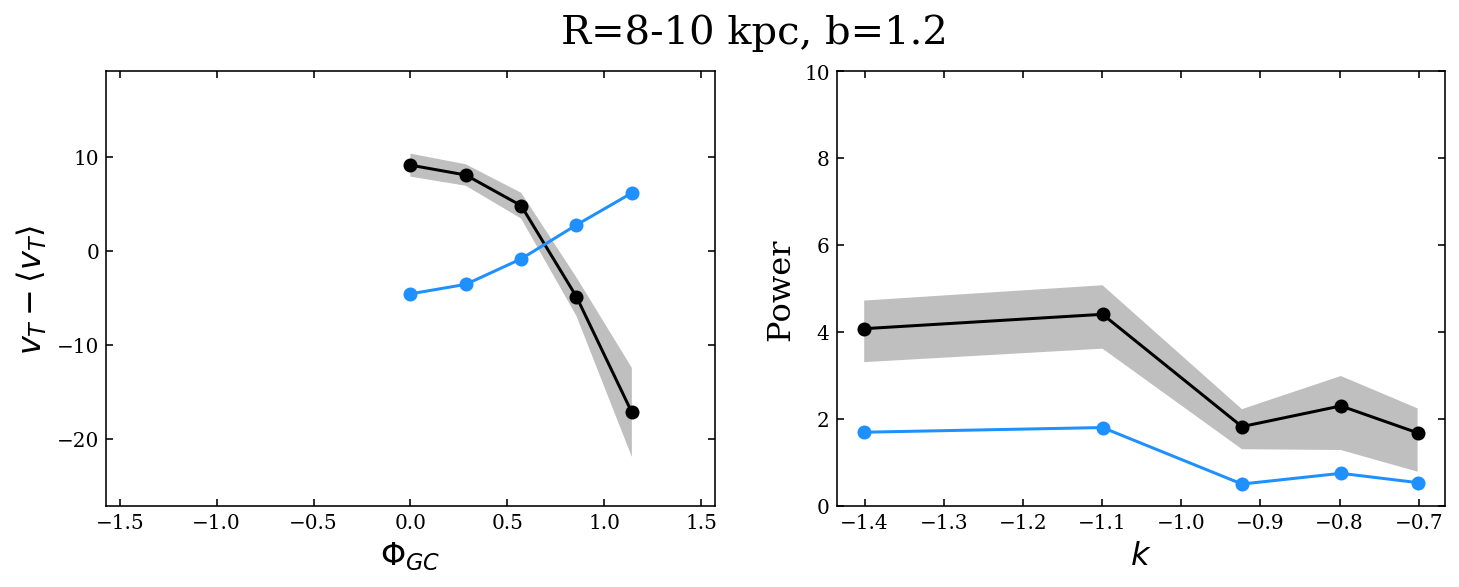

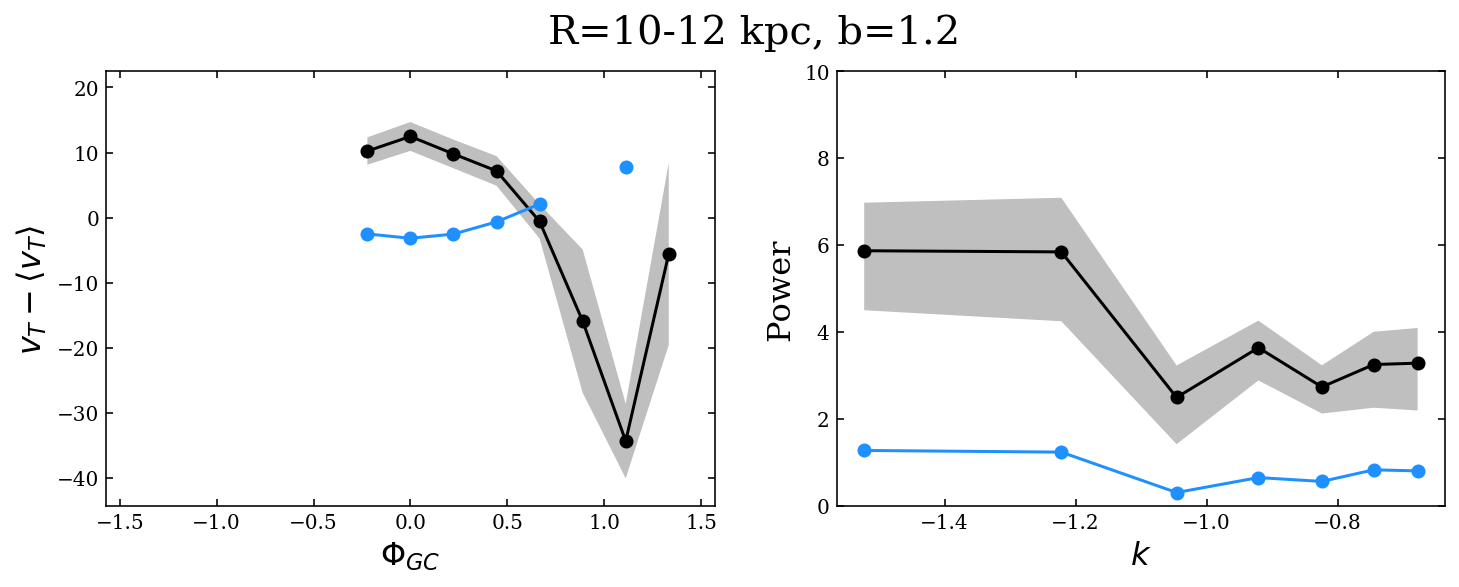

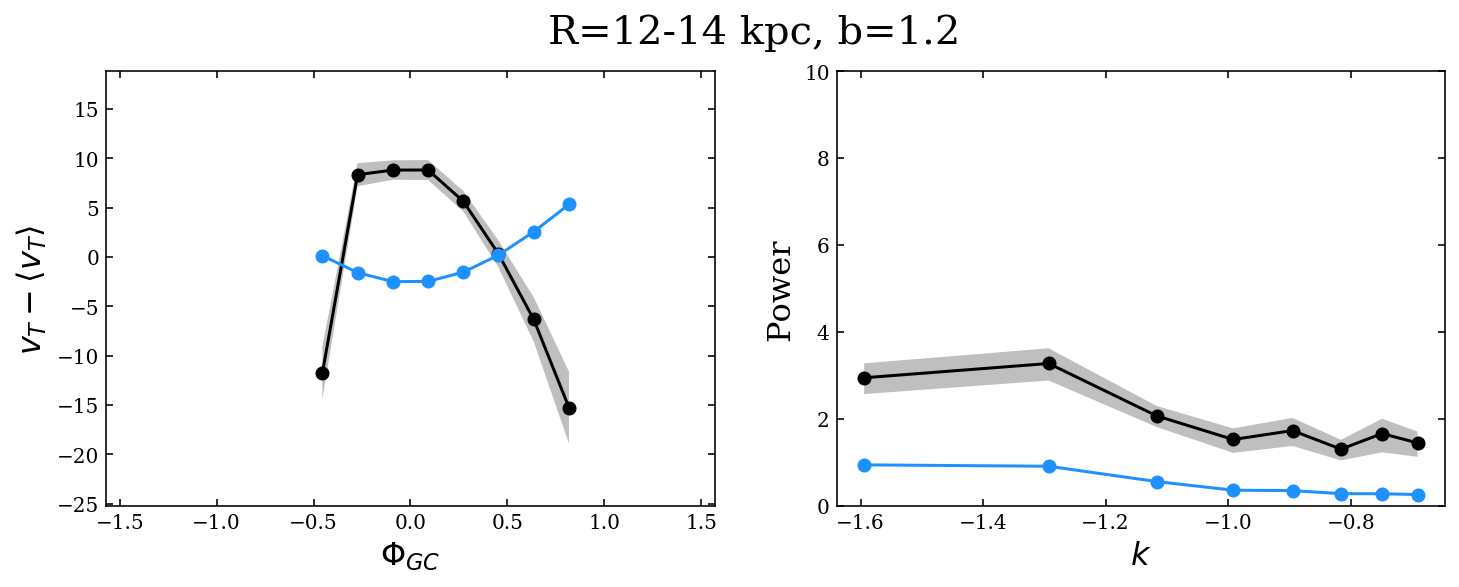

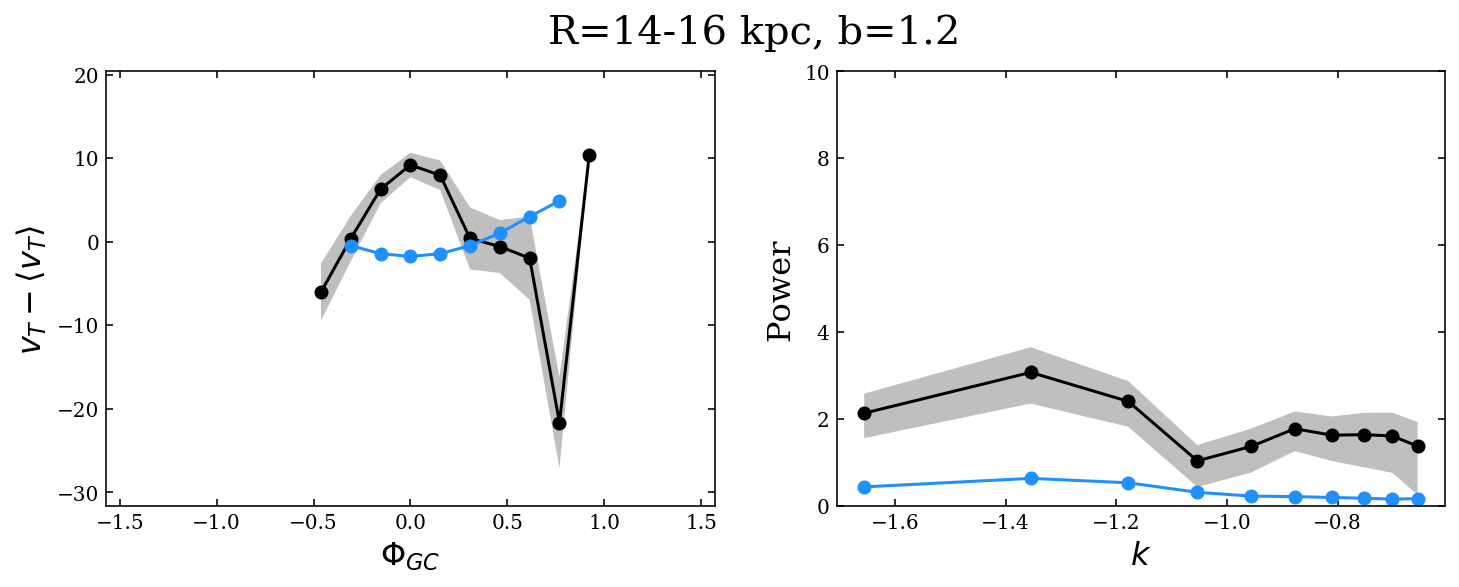



##########




In [28]:
# Now loop over each radial bin
for i in range( n_files ):
    
    sim_data = np.load(files[i])
    print(files[i])
    print(b_values[i])
    
    # Now loop over each radial bin
    for j in range( len(R_range) ):
        
        if R_range[j] < 8: continue
        
        # Find the simulated data just at this radius
        sim_data_R = sim_data[ np.where( sim_data[:,0] == R_range[j] )[0], : ]

        # Bootstrap over the samples
        for k in range(n_bs):

            # Take a random sub-sample of Gaia stars
            sample = np.random.randint(0,len(gc_x),len(gc_x))
            samp_gc_R = gc_R[sample]
            samp_gc_phi = gc_phi[sample]
            samp_gc_vT = gc_vT[sample]

            # Select the stars in this bin
            stars_in_bin = np.where( (samp_gc_R > (R_range[j]-R_bin_size/2) ) & 
                                     (samp_gc_R < (R_range[j]+R_bin_size/2) ) )[0]
            gcvt_in_bin = -samp_gc_vT[stars_in_bin]
            gcphi_in_bin = samp_gc_phi[stars_in_bin]
            
            # Select the simulated data
            sim_vt = sim_data_R[:,6]
            sim_phi = sim_data_R[:,1]
            
            # Determine the size of the phi bins, and bin the Gaia data to match
            phi_bin_size_arc = np.diff( sim_data_R[:,1]*sim_data_R[:,0] )[0]
            phi_bin_size = np.diff( sim_data_R[:,1] )[0]
            phi_samp_bin_cents = sim_data_R[:,1]
            phi_samp_bin_edges = np.append( sim_data_R[:,1]-phi_bin_size/2, sim_data_R[-1,1]+phi_bin_size/2 ) 

            # Bin in phi
            binned_vt, _, _ = binned_statistic(gcphi_in_bin, gcvt_in_bin, 
                                               bins=phi_samp_bin_edges, 
                                               statistic='mean')

            # Make a number histogram to examine whether there is enough stars for a valid measurement
            binned_n, _, = np.histogram(gcphi_in_bin, bins=phi_samp_bin_edges)
            where_low_bin_numbers = np.where(binned_n < 10)
            
            # Exclude areas where there wasn't a valid measurement
            binned_vt[where_low_bin_numbers] = np.nan
            sim_vt[where_low_bin_numbers] = np.nan

            # Find where there was data
            where_data = np.where( np.isfinite(binned_vt) )
            where_no_data = np.where( np.isnan(binned_vt) )
            binned_vt[ where_no_data ] = np.nan
            sim_vt[ where_no_data ] = np.nan
            
            # Subtract off mean where non-zero
            mean_binned_vt = np.nanmean( binned_vt[where_data] )
            mean_sim_vt = np.nanmean( sim_vt[where_data] )
            binned_vt = binned_vt - mean_binned_vt
            sim_vt = sim_vt - mean_sim_vt

            # Get the power spectrum
            samp_ks, samp_pk = ast1501.fourier.psd(binned_vt, phi_bin_size_arc, pad=False, return_phase=False)
            sim_ks, sim_pk = ast1501.fourier.psd(sim_vt, phi_bin_size_arc, pad=False, return_phase=False)

            if k == 0:
                bs_phi_samp = np.zeros((n_bs, len(phi_samp_bin_cents)))
                bs_vT_samp = np.zeros((n_bs, len(binned_vt)))
                bs_k_vT_samp = np.zeros((n_bs, len(samp_ks)))
                bs_pk_vT_samp = np.zeros((n_bs, len(samp_pk)))
                
                bs_phi_sim = np.zeros((n_bs, len(sim_phi)))
                bs_vT_sim = np.zeros((n_bs, len(sim_vt)))
                bs_k_vT_sim = np.zeros((n_bs, len(sim_ks)))
                bs_pk_vT_sim = np.zeros((n_bs, len(sim_pk)))
            ##fi
            
            bs_phi_samp[k] = phi_samp_bin_cents
            bs_vT_samp[k] = binned_vt
            bs_k_vT_samp[k] = samp_ks
            bs_pk_vT_samp[k] = samp_pk
            
            bs_phi_sim[k] = sim_phi
            bs_vT_sim[k] = sim_vt
            bs_k_vT_sim[k] = sim_ks
            bs_pk_vT_sim[k] = sim_pk

        # Take the average and standard deviation of the azimuthal profile
        bs_avg_vT_samp = np.nanmean(bs_vT_samp, axis=0)
        bs_std_vT_samp = np.nanstd(bs_vT_samp, axis=0)
        bs_avg_vT_sim = np.nanmean(bs_vT_sim, axis=0)
        bs_std_vT_sim = np.nanstd(bs_vT_sim, axis=0)

        # Take the average and standard deviation of the power spectrum
        bs_avg_pk_vT_samp = np.nanmean(bs_pk_vT_samp, axis=0)
        bs_std_pk_vT_samp = np.nanstd(bs_pk_vT_samp, axis=0)
        bs_avg_pk_vT_sim = np.nanmean(bs_pk_vT_sim, axis=0)
        bs_std_pk_vT_sim = np.nanstd(bs_pk_vT_sim, axis=0)

        # pdb.set_trace()
    
        use_color = 'DodgerBlue'
        if i == 2:
            use_color = 'Red'
        ##fi
        
        # Plot
        fig = plt.figure( figsize=(12,4) )
        ax1, ax2 = fig.subplots(nrows=1, ncols=2)

        ax1.plot(bs_phi_samp[0], bs_avg_vT_samp, color='Black', marker='o')
        ax1.fill_between(bs_phi_samp[0], 
                         bs_avg_vT_samp+bs_std_vT_samp, 
                         bs_avg_vT_samp-bs_std_vT_samp, 
                         alpha=0.5, facecolor='Grey' )
        ax1.plot(bs_phi_sim[0], bs_avg_vT_sim, color=use_color, marker='o')
        
        ax1.set_xlabel(r'$\Phi_{GC}$', fontsize=16)
        ax1.set_ylabel(r'$v_{T}- \langle {v_{T}} \rangle$', fontsize=16)
        ax1.set_xlim(-np.pi/2,np.pi/2)
        ax1.set_ylim( np.nanmin(bs_avg_vT_samp)-10, np.nanmax(bs_avg_vT_samp)+10 )

        ind_ks_pos_samp = int(1+len(bs_k_vT_samp[0])/2)
        ind_ks_pos_sim = int(1+len(bs_k_vT_sim[0])/2)
        
        bs_k_vT_samp_pos = np.abs( bs_k_vT_samp[0,ind_ks_pos_samp:] ) 
        bs_k_vT_sim_pos = np.abs( bs_k_vT_sim[0,ind_ks_pos_sim:] ) 
        
        ax2.plot(np.log10(bs_k_vT_samp_pos), np.sqrt(bs_avg_pk_vT_samp[ind_ks_pos_samp:]), 
                 color='Black', marker='o')
        ax2.fill_between( np.log10(bs_k_vT_samp_pos), 
                         np.sqrt(bs_avg_pk_vT_samp[ind_ks_pos_samp:]+bs_std_pk_vT_samp[ind_ks_pos_samp:]), 
                         np.sqrt(bs_avg_pk_vT_samp[ind_ks_pos_samp:]-bs_std_pk_vT_samp[ind_ks_pos_samp:]),
                         alpha=0.5, facecolor='Grey' )
        ax2.plot(np.log10(bs_k_vT_sim_pos), np.sqrt(bs_avg_pk_vT_sim[ind_ks_pos_sim:]), 
                 color=use_color, marker='o')
        ax2.set_xlabel(r'$k$', fontsize=16)
        ax2.set_ylabel('Power', fontsize=16)
        ax2.set_ylim(0,10)

        fig.suptitle('R='+str(int(R_range[j]))+'-'+str(int(R_range[j]+R_bin_size))+' kpc, b='+str(b_values[i]), fontsize=20)

        plt.show()
        plt.close('all')
    ###j
    
    print('\n\n##########\n\n')
    
###i

./data/data6.npy
0.8


/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/ipykernel_launcher.py:98: RuntimeWarning: Mean of empty slice
/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: Mean of empty slice


./data/data0.npy
0.9
./data/data_09_bar.npy
0.9
./data/data1.npy
0.95
./data/data2.npy
0.98
./data/data3.npy
1.02
./data/data5.npy
1.1
./data/data7.npy
1.2


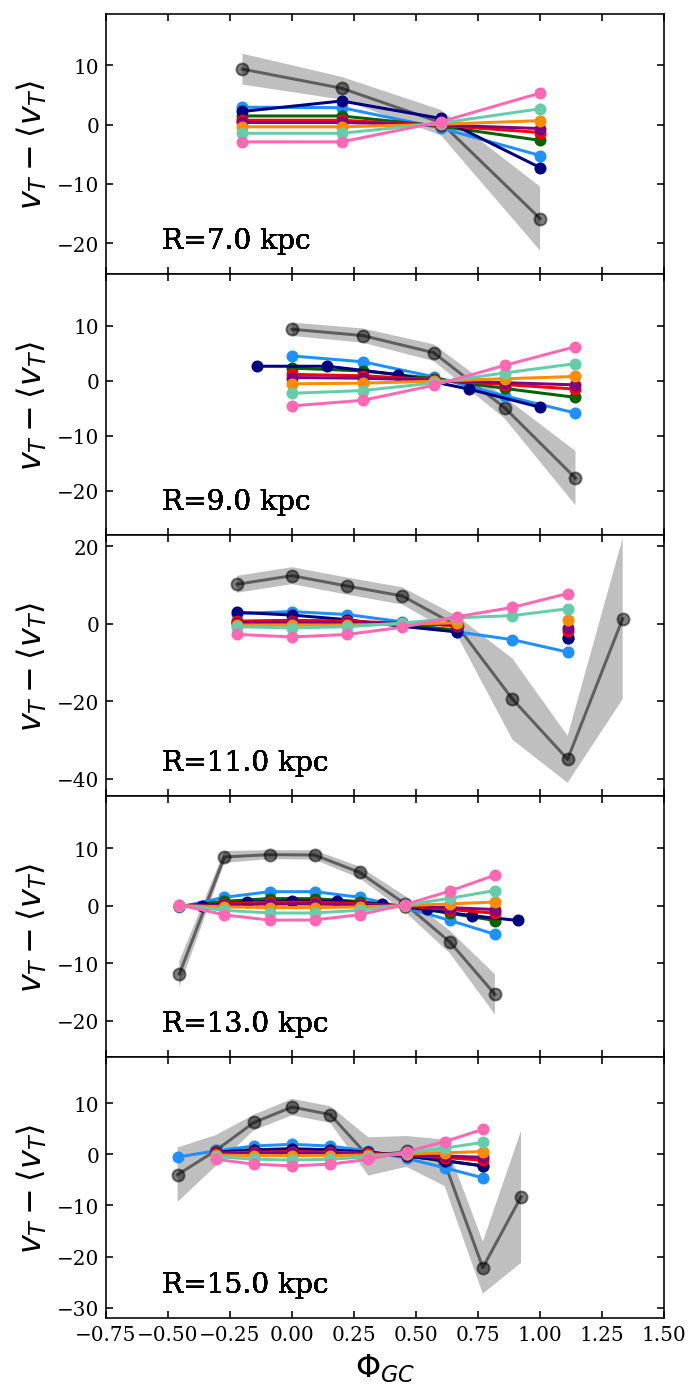

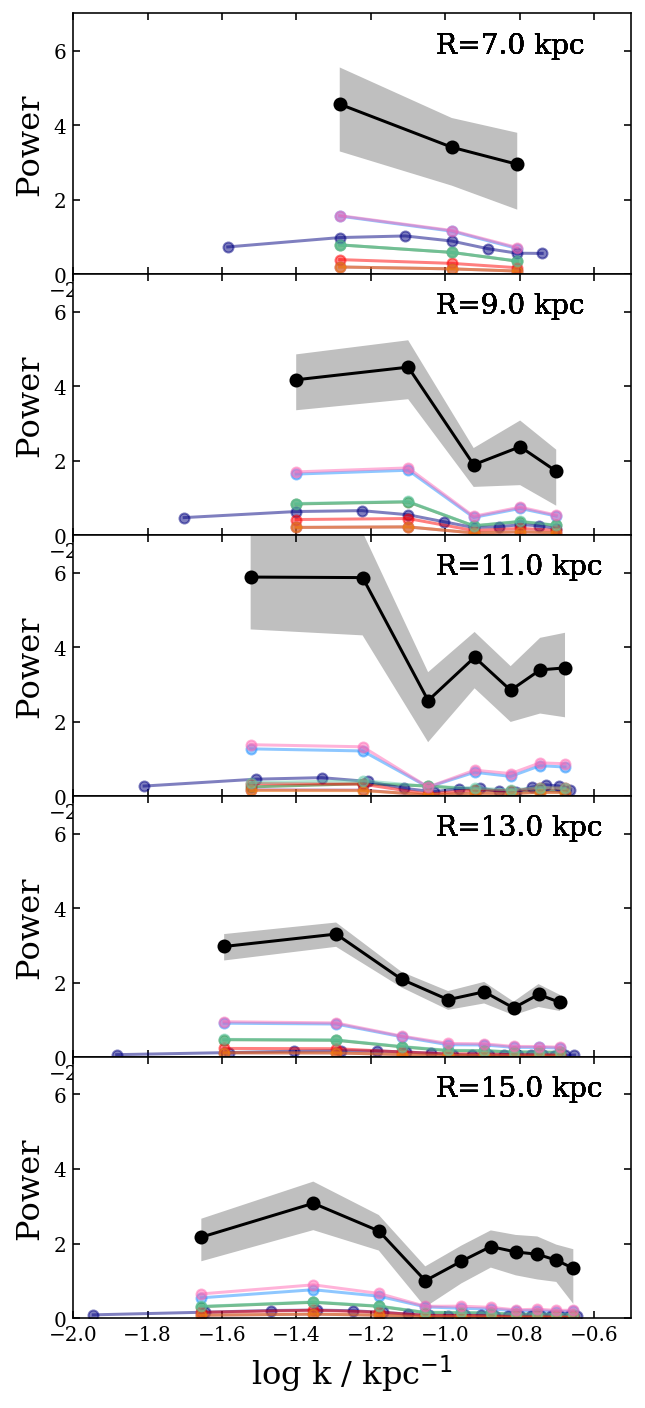

In [37]:
# Plot
fig1 = plt.figure( figsize=(5,12) )
axs1 = fig1.subplots(nrows=5, ncols=1)

fig2 = plt.figure( figsize=(5,12) )
axs2 = fig2.subplots(nrows=5, ncols=1)

# Now loop over each radial bin
for i in range( n_files ):
    
    sim_data = np.load(files[i])
    print(files[i])
    print(b_values[i])
    
    # Now loop over each radial bin
    for j in range( len(R_range) ):
        
        # Find the simulated data just at this radius
        sim_data_R = sim_data[ np.where( sim_data[:,0] == R_range[j] )[0], : ]

        # Bootstrap over the samples
        for k in range(n_bs):

            # Take a random sub-sample of Gaia stars
            sample = np.random.randint(0,len(gc_x),len(gc_x))
            samp_gc_R = gc_R[sample]
            samp_gc_phi = gc_phi[sample]
            samp_gc_vT = gc_vT[sample]

            # Select the stars in this bin
            stars_in_bin = np.where( (samp_gc_R > (R_range[j]-R_bin_size/2) ) & 
                                     (samp_gc_R < (R_range[j]+R_bin_size/2) ) )[0]
            gcvt_in_bin = -samp_gc_vT[stars_in_bin]
            gcphi_in_bin = samp_gc_phi[stars_in_bin]
            
            # Select the simulated data
            sim_vt = sim_data_R[:,6]
            sim_phi = sim_data_R[:,1]
            
            # Determine the size of the phi bins, and bin the Gaia data to match
            phi_bin_size_arc = np.diff( sim_data_R[:,1]*sim_data_R[:,0] )[0]
            phi_bin_size = np.diff( sim_data_R[:,1] )[0]
            phi_samp_bin_cents = sim_data_R[:,1]
            phi_samp_bin_edges = np.append( sim_data_R[:,1]-phi_bin_size/2, sim_data_R[-1,1]+phi_bin_size/2 ) 

            # Bin in phi
            binned_vt, _, _ = binned_statistic(gcphi_in_bin, gcvt_in_bin, 
                                               bins=phi_samp_bin_edges, 
                                               statistic='mean')

            # Make a number histogram to examine whether there is enough stars for a valid measurement
            binned_n, _, = np.histogram(gcphi_in_bin, bins=phi_samp_bin_edges)
            where_low_bin_numbers = np.where(binned_n < 10)
            
            # Exclude areas where there wasn't a valid measurement
            binned_vt[where_low_bin_numbers] = np.nan
            sim_vt[where_low_bin_numbers] = np.nan

            # Find where there was data
            where_data = np.where( np.isfinite(binned_vt) )
            where_no_data = np.where( np.isnan(binned_vt) )
            binned_vt[ where_no_data ] = np.nan
            sim_vt[ where_no_data ] = np.nan
            
            # Subtract off mean where non-zero
            mean_binned_vt = np.nanmean( binned_vt[where_data] )
            mean_sim_vt = np.nanmean( sim_vt[where_data] )
            binned_vt = binned_vt - mean_binned_vt
            sim_vt = sim_vt - mean_sim_vt

            # Get the power spectrum
            samp_ks, samp_pk = ast1501.fourier.psd(binned_vt, phi_bin_size_arc, pad=False, return_phase=False)
            sim_ks, sim_pk = ast1501.fourier.psd(sim_vt, phi_bin_size_arc, pad=False, return_phase=False)

            if k == 0:
                bs_phi_samp = np.zeros((n_bs, len(phi_samp_bin_cents)))
                bs_vT_samp = np.zeros((n_bs, len(binned_vt)))
                bs_k_vT_samp = np.zeros((n_bs, len(samp_ks)))
                bs_pk_vT_samp = np.zeros((n_bs, len(samp_pk)))
                
                bs_phi_sim = np.zeros((n_bs, len(sim_phi)))
                bs_vT_sim = np.zeros((n_bs, len(sim_vt)))
                bs_k_vT_sim = np.zeros((n_bs, len(sim_ks)))
                bs_pk_vT_sim = np.zeros((n_bs, len(sim_pk)))
            ##fi
            
            bs_phi_samp[k] = phi_samp_bin_cents
            bs_vT_samp[k] = binned_vt
            bs_k_vT_samp[k] = samp_ks
            bs_pk_vT_samp[k] = samp_pk
            
            bs_phi_sim[k] = sim_phi
            bs_vT_sim[k] = sim_vt
            bs_k_vT_sim[k] = sim_ks
            bs_pk_vT_sim[k] = sim_pk

        # Take the average and standard deviation of the azimuthal profile
        bs_avg_vT_samp = np.nanmean(bs_vT_samp, axis=0)
        bs_std_vT_samp = np.nanstd(bs_vT_samp, axis=0)
        bs_avg_vT_sim = np.nanmean(bs_vT_sim, axis=0)
        bs_std_vT_sim = np.nanstd(bs_vT_sim, axis=0)

        # Take the average and standard deviation of the power spectrum
        bs_avg_pk_vT_samp = np.nanmean(bs_pk_vT_samp, axis=0)
        bs_std_pk_vT_samp = np.nanstd(bs_pk_vT_samp, axis=0)
        bs_avg_pk_vT_sim = np.nanmean(bs_pk_vT_sim, axis=0)
        bs_std_pk_vT_sim = np.nanstd(bs_pk_vT_sim, axis=0)

        # Plot the fluctuations
        if i == 0:
            axs1[j].plot(bs_phi_samp[0], bs_avg_vT_samp, color='Black', marker='o',
                        alpha=0.5)
            axs1[j].fill_between(bs_phi_samp[0], 
                             bs_avg_vT_samp+bs_std_vT_samp, 
                             bs_avg_vT_samp-bs_std_vT_samp, 
                             alpha=0.5, facecolor='Grey' )
        ###i
        axs1[j].plot(bs_phi_sim[0], bs_avg_vT_sim, color=file_colors[i], marker='o', markersize=5)
        
        axs1[j].set_xlabel(r'$\Phi_{GC}$', fontsize=16)
        axs1[j].set_ylabel(r'$v_{T}- \langle {v_{T}} \rangle$', fontsize=16)
        axs1[j].set_xlim(-np.pi/2,np.pi/2)
        axs1[j].set_ylim( np.nanmin(bs_avg_vT_samp)-10, np.nanmax(bs_avg_vT_samp)+10 )
        axs1[j].set_xlim(-0.75,1.5)

        axs1[j].annotate('R='+str(int(R_range[j])+R_bin_size/2)+' kpc', fontsize=14, xy=(0.1,0.1), xycoords='axes fraction')
        
        if j != 4:
            axs1[j].tick_params(labelbottom='off')
        
        ind_ks_pos_samp = int(1+len(bs_k_vT_samp[0])/2)
        ind_ks_pos_sim = int(1+len(bs_k_vT_sim[0])/2)
        
        bs_k_vT_samp_pos = np.abs( bs_k_vT_samp[0,ind_ks_pos_samp:] ) 
        bs_k_vT_sim_pos = np.abs( bs_k_vT_sim[0,ind_ks_pos_sim:] ) 
        
        
        # Plot the power
        if i == 0:
            axs2[j].plot(np.log10(bs_k_vT_samp_pos), np.sqrt(bs_avg_pk_vT_samp[ind_ks_pos_samp:]), 
                 color='Black', marker='o')
            axs2[j].fill_between( np.log10(bs_k_vT_samp_pos), 
                         np.sqrt(bs_avg_pk_vT_samp[ind_ks_pos_samp:]+bs_std_pk_vT_samp[ind_ks_pos_samp:]), 
                         np.sqrt(bs_avg_pk_vT_samp[ind_ks_pos_samp:]-bs_std_pk_vT_samp[ind_ks_pos_samp:]),
                         alpha=0.5, facecolor='Grey' )
        ###i
        axs2[j].plot(np.log10(bs_k_vT_sim_pos), np.sqrt(bs_avg_pk_vT_sim[ind_ks_pos_sim:]), 
                 color=file_colors[i], marker='o', markersize=5, alpha=0.5)
        axs2[j].set_xlabel(r'log k / kpc$^{-1}$', fontsize=16)
        axs2[j].set_ylabel('Power', fontsize=16)
        axs2[j].set_ylim(0,7)
        axs2[j].set_xlim(-2,-0.5)

        axs2[j].annotate('R='+str(int(R_range[j])+R_bin_size/2)+' kpc', fontsize=14, xy=(0.65,0.85), xycoords='axes fraction')
    ###j
###i

fig1.subplots_adjust(hspace=0)
fig2.subplots_adjust(hspace=0)

fig1.savefig('out1.pdf')
fig2.savefig('out2.pdf')

# Radial velocity

./data/data6.npy
0.8


/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/ipykernel_launcher.py:98: RuntimeWarning: Mean of empty slice
/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: Mean of empty slice
/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in sqrt


./data/data0.npy
0.9
./data/data_09_bar.npy
0.9
./data/data1.npy
0.95
./data/data2.npy
0.98
./data/data3.npy
1.02
./data/data5.npy
1.1
./data/data7.npy
1.2


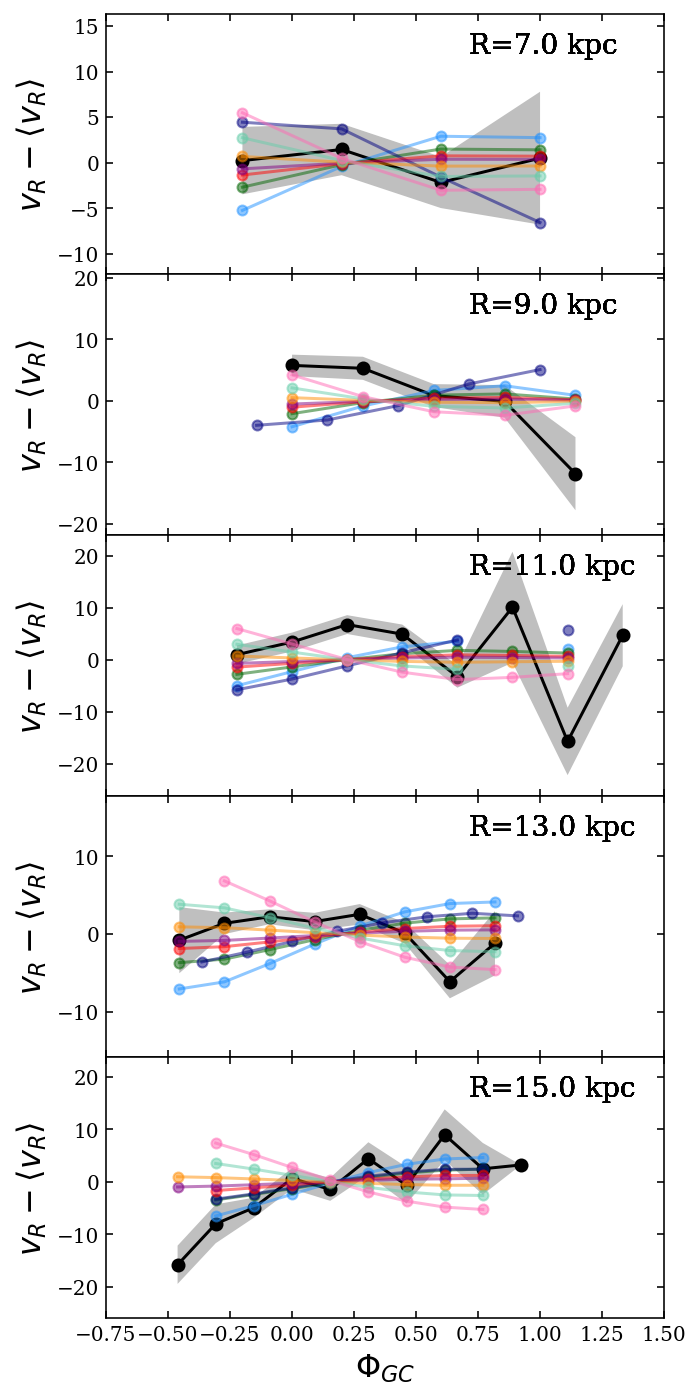

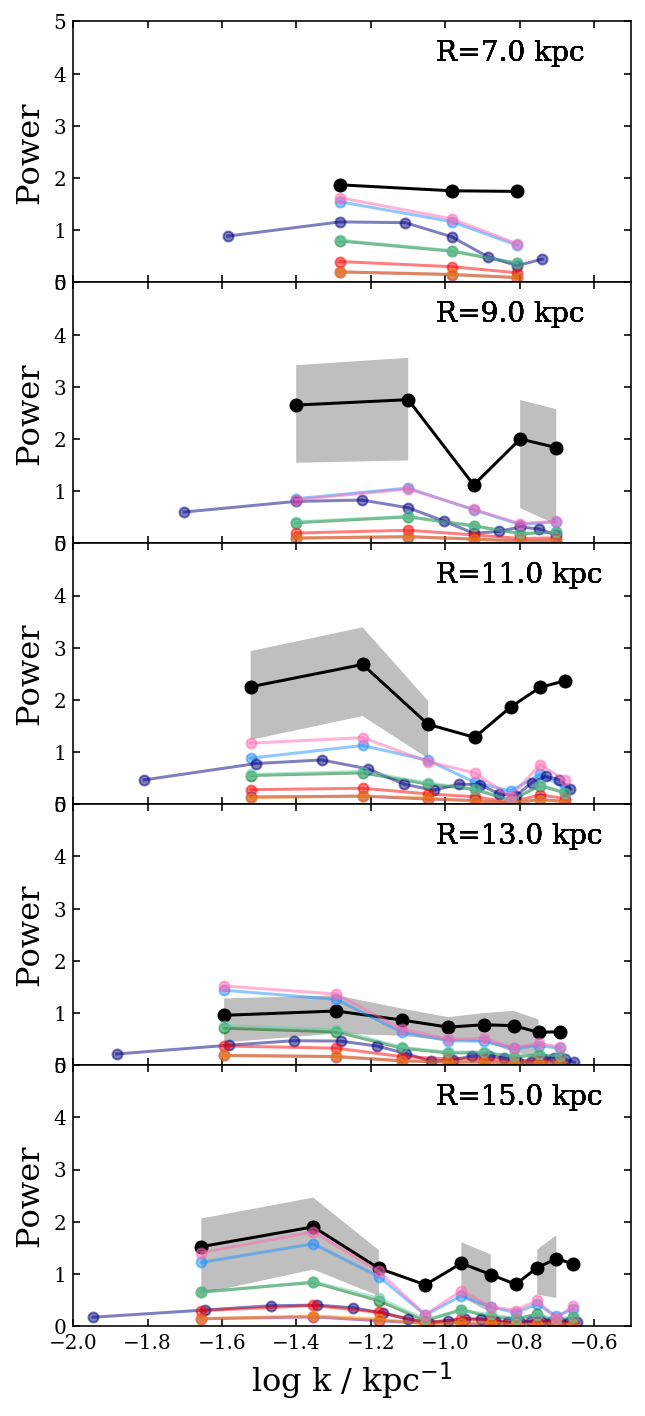

In [38]:
# Plot
fig1 = plt.figure( figsize=(5,12) )
axs1 = fig1.subplots(nrows=5, ncols=1)

fig2 = plt.figure( figsize=(5,12) )
axs2 = fig2.subplots(nrows=5, ncols=1)

# Now loop over each radial bin
for i in range( n_files ):
    
    sim_data = np.load(files[i])
    print(files[i])
    print(b_values[i])
    
    # Now loop over each radial bin
    for j in range( len(R_range) ):
        
        # Find the simulated data just at this radius
        sim_data_R = sim_data[ np.where( sim_data[:,0] == R_range[j] )[0], : ]

        # Bootstrap over the samples
        for k in range(n_bs):

            # Take a random sub-sample of Gaia stars
            sample = np.random.randint(0,len(gc_x),len(gc_x))
            samp_gc_R = gc_R[sample]
            samp_gc_phi = gc_phi[sample]
            samp_gc_vT = gc_vR[sample]

            # Select the stars in this bin
            stars_in_bin = np.where( (samp_gc_R > (R_range[j]-R_bin_size/2) ) & 
                                     (samp_gc_R < (R_range[j]+R_bin_size/2) ) )[0]
            gcvt_in_bin = -samp_gc_vT[stars_in_bin]
            gcphi_in_bin = samp_gc_phi[stars_in_bin]
            
            # Select the simulated data
            sim_vt = sim_data_R[:,4]
            sim_phi = sim_data_R[:,1]
            
            # Determine the size of the phi bins, and bin the Gaia data to match
            phi_bin_size_arc = np.diff( sim_data_R[:,1]*sim_data_R[:,0] )[0]
            phi_bin_size = np.diff( sim_data_R[:,1] )[0]
            phi_samp_bin_cents = sim_data_R[:,1]
            phi_samp_bin_edges = np.append( sim_data_R[:,1]-phi_bin_size/2, sim_data_R[-1,1]+phi_bin_size/2 ) 

            # Bin in phi
            binned_vt, _, _ = binned_statistic(gcphi_in_bin, gcvt_in_bin, 
                                               bins=phi_samp_bin_edges, 
                                               statistic='mean')

            # Make a number histogram to examine whether there is enough stars for a valid measurement
            binned_n, _, = np.histogram(gcphi_in_bin, bins=phi_samp_bin_edges)
            where_low_bin_numbers = np.where(binned_n < 10)
            
            # Exclude areas where there wasn't a valid measurement
            binned_vt[where_low_bin_numbers] = np.nan
            sim_vt[where_low_bin_numbers] = np.nan

            # Find where there was data
            where_data = np.where( np.isfinite(binned_vt) )
            where_no_data = np.where( np.isnan(binned_vt) )
            binned_vt[ where_no_data ] = np.nan
            sim_vt[ where_no_data ] = np.nan
            
            # Subtract off mean where non-zero
            mean_binned_vt = np.nanmean( binned_vt[where_data] )
            mean_sim_vt = np.nanmean( sim_vt[where_data] )
            binned_vt = binned_vt - mean_binned_vt
            sim_vt = sim_vt - mean_sim_vt

            # Get the power spectrum
            samp_ks, samp_pk = ast1501.fourier.psd(binned_vt, phi_bin_size_arc, pad=False, return_phase=False)
            sim_ks, sim_pk = ast1501.fourier.psd(sim_vt, phi_bin_size_arc, pad=False, return_phase=False)

            if k == 0:
                bs_phi_samp = np.zeros((n_bs, len(phi_samp_bin_cents)))
                bs_vT_samp = np.zeros((n_bs, len(binned_vt)))
                bs_k_vT_samp = np.zeros((n_bs, len(samp_ks)))
                bs_pk_vT_samp = np.zeros((n_bs, len(samp_pk)))
                
                bs_phi_sim = np.zeros((n_bs, len(sim_phi)))
                bs_vT_sim = np.zeros((n_bs, len(sim_vt)))
                bs_k_vT_sim = np.zeros((n_bs, len(sim_ks)))
                bs_pk_vT_sim = np.zeros((n_bs, len(sim_pk)))
            ##fi
            
            bs_phi_samp[k] = phi_samp_bin_cents
            bs_vT_samp[k] = binned_vt
            bs_k_vT_samp[k] = samp_ks
            bs_pk_vT_samp[k] = samp_pk
            
            bs_phi_sim[k] = sim_phi
            bs_vT_sim[k] = sim_vt
            bs_k_vT_sim[k] = sim_ks
            bs_pk_vT_sim[k] = sim_pk

        # Take the average and standard deviation of the azimuthal profile
        bs_avg_vT_samp = np.nanmean(bs_vT_samp, axis=0)
        bs_std_vT_samp = np.nanstd(bs_vT_samp, axis=0)
        bs_avg_vT_sim = np.nanmean(bs_vT_sim, axis=0)
        bs_std_vT_sim = np.nanstd(bs_vT_sim, axis=0)

        # Take the average and standard deviation of the power spectrum
        bs_avg_pk_vT_samp = np.nanmean(bs_pk_vT_samp, axis=0)
        bs_std_pk_vT_samp = np.nanstd(bs_pk_vT_samp, axis=0)
        bs_avg_pk_vT_sim = np.nanmean(bs_pk_vT_sim, axis=0)
        bs_std_pk_vT_sim = np.nanstd(bs_pk_vT_sim, axis=0)

        # Plot the fluctuations
        if i == 0:
            axs1[j].plot(bs_phi_samp[0], bs_avg_vT_samp, color='Black', marker='o')
            axs1[j].fill_between(bs_phi_samp[0], 
                             bs_avg_vT_samp+bs_std_vT_samp, 
                             bs_avg_vT_samp-bs_std_vT_samp, 
                             alpha=0.5, facecolor='Grey' )
        ###i
        axs1[j].plot(bs_phi_sim[0], bs_avg_vT_sim, color=file_colors[i], marker='o', markersize=5,
                    alpha=0.5)
        
        axs1[j].set_xlabel(r'$\Phi_{GC}$', fontsize=16)
        axs1[j].set_ylabel(r'$v_{R}- \langle {v_{R}} \rangle$', fontsize=16)
        axs1[j].set_xlim(-np.pi/2,np.pi/2)
        axs1[j].set_ylim( np.nanmin(bs_avg_vT_samp)-10, np.nanmax(bs_avg_vT_samp)+15 )
        axs1[j].set_xlim(-0.75,1.5)

        axs1[j].annotate('R='+str(int(R_range[j])+R_bin_size/2)+' kpc', fontsize=14, xy=(0.65,0.85), xycoords='axes fraction')
        
        if j != 4:
            axs1[j].tick_params(labelbottom='off')
        
        ind_ks_pos_samp = int(1+len(bs_k_vT_samp[0])/2)
        ind_ks_pos_sim = int(1+len(bs_k_vT_sim[0])/2)
        
        bs_k_vT_samp_pos = np.abs( bs_k_vT_samp[0,ind_ks_pos_samp:] ) 
        bs_k_vT_sim_pos = np.abs( bs_k_vT_sim[0,ind_ks_pos_sim:] ) 
        
        
        # Plot the power
        if i == 0:
            axs2[j].plot(np.log10(bs_k_vT_samp_pos), np.sqrt(bs_avg_pk_vT_samp[ind_ks_pos_samp:]), 
                 color='Black', marker='o')
            axs2[j].fill_between( np.log10(bs_k_vT_samp_pos), 
                         np.sqrt(bs_avg_pk_vT_samp[ind_ks_pos_samp:]+bs_std_pk_vT_samp[ind_ks_pos_samp:]), 
                         np.sqrt(bs_avg_pk_vT_samp[ind_ks_pos_samp:]-bs_std_pk_vT_samp[ind_ks_pos_samp:]),
                         alpha=0.5, facecolor='Grey' )
        ###i
        axs2[j].plot(np.log10(bs_k_vT_sim_pos), np.sqrt(bs_avg_pk_vT_sim[ind_ks_pos_sim:]), 
                 color=file_colors[i], marker='o', markersize=5, alpha=0.5)
        axs2[j].set_xlabel(r'log k / kpc$^{-1}$', fontsize=16)
        axs2[j].set_ylabel('Power', fontsize=16)
        axs2[j].set_ylim(0,5)
        axs2[j].set_xlim(-2,-0.5)
        
        if j != 4:
            axs2[j].tick_params(labelbottom='off')

        axs2[j].annotate('R='+str(int(R_range[j])+R_bin_size/2)+' kpc', fontsize=14, xy=(0.65,0.85), xycoords='axes fraction')
    ###j
###i

fig1.subplots_adjust(hspace=0)
fig2.subplots_adjust(hspace=0)

fig1.savefig('out3.pdf')
fig2.savefig('out4.pdf')

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice
/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: Mean of empty slice
/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/ipykernel_launcher.py:135: RuntimeWarning: invalid value encountered in sqrt


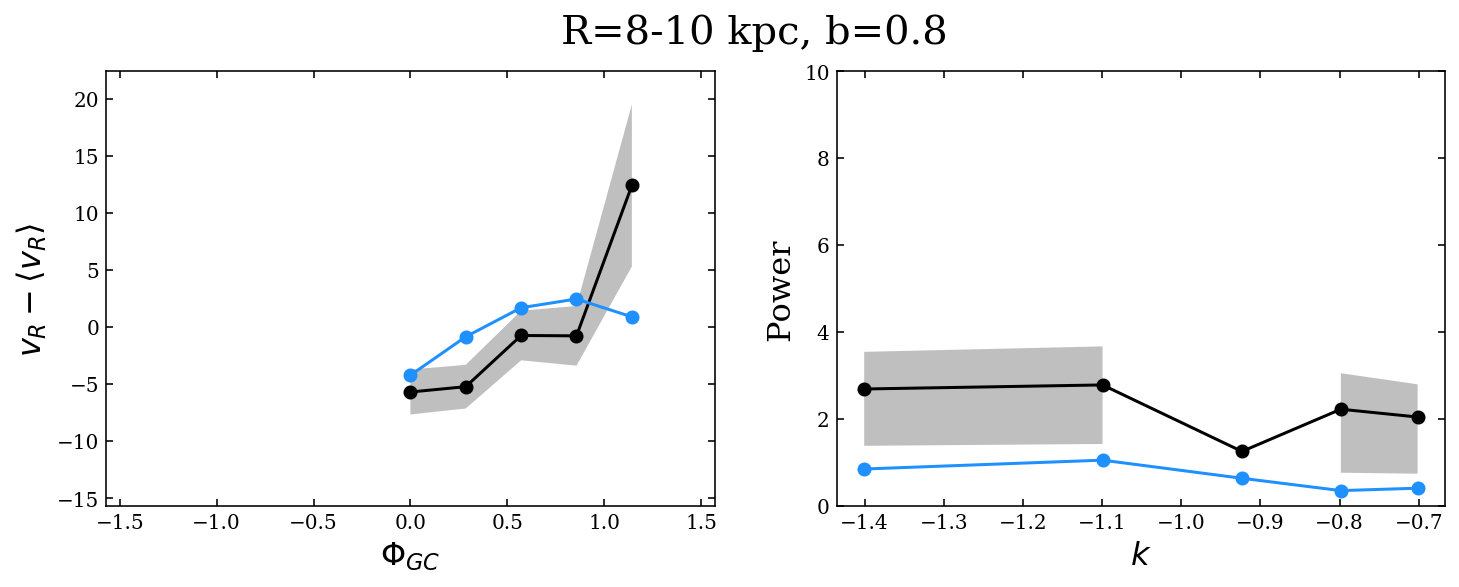

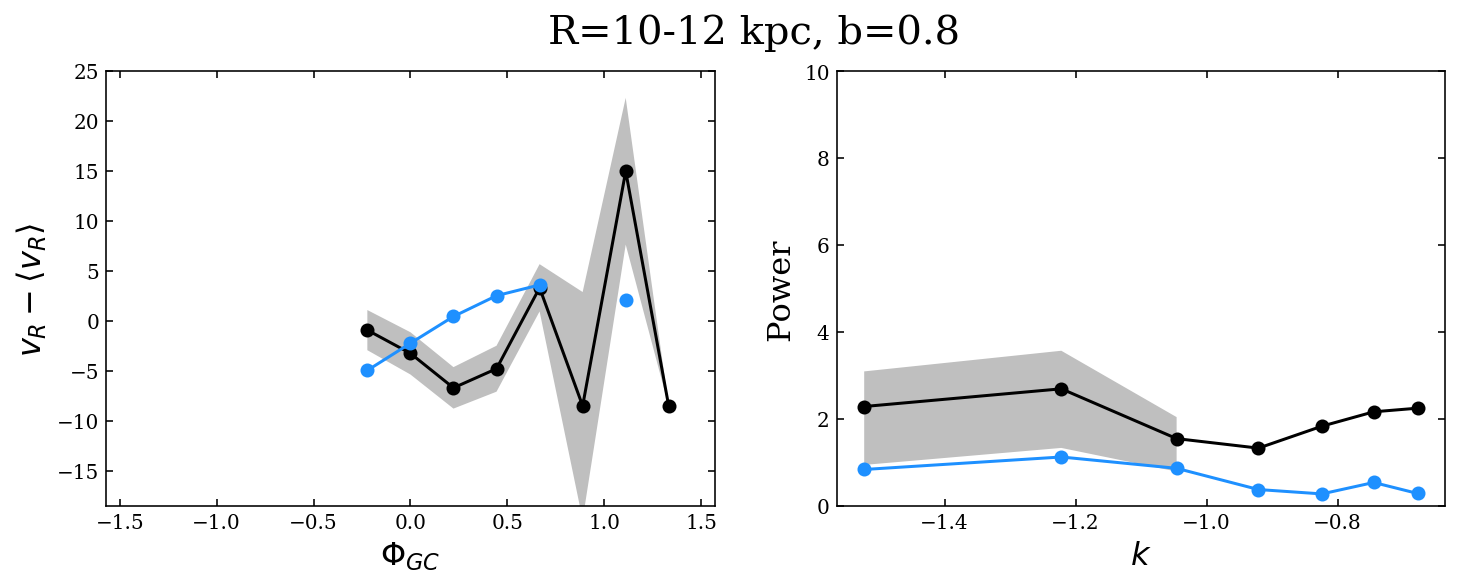

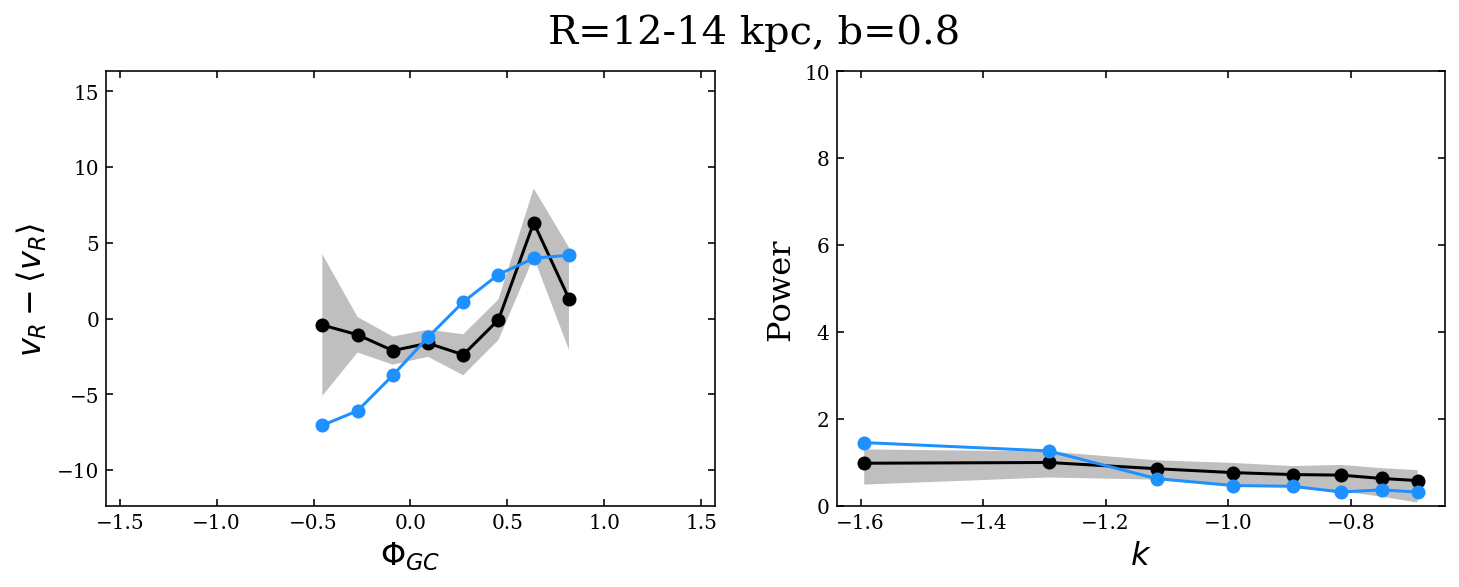

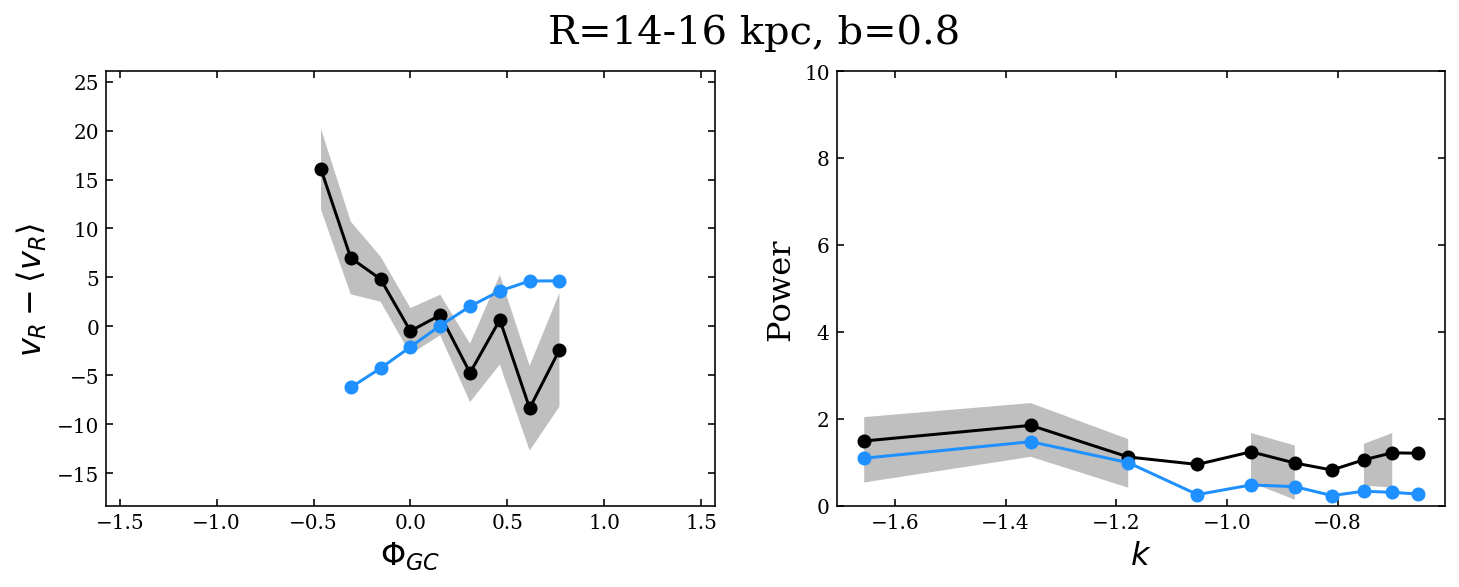



##########




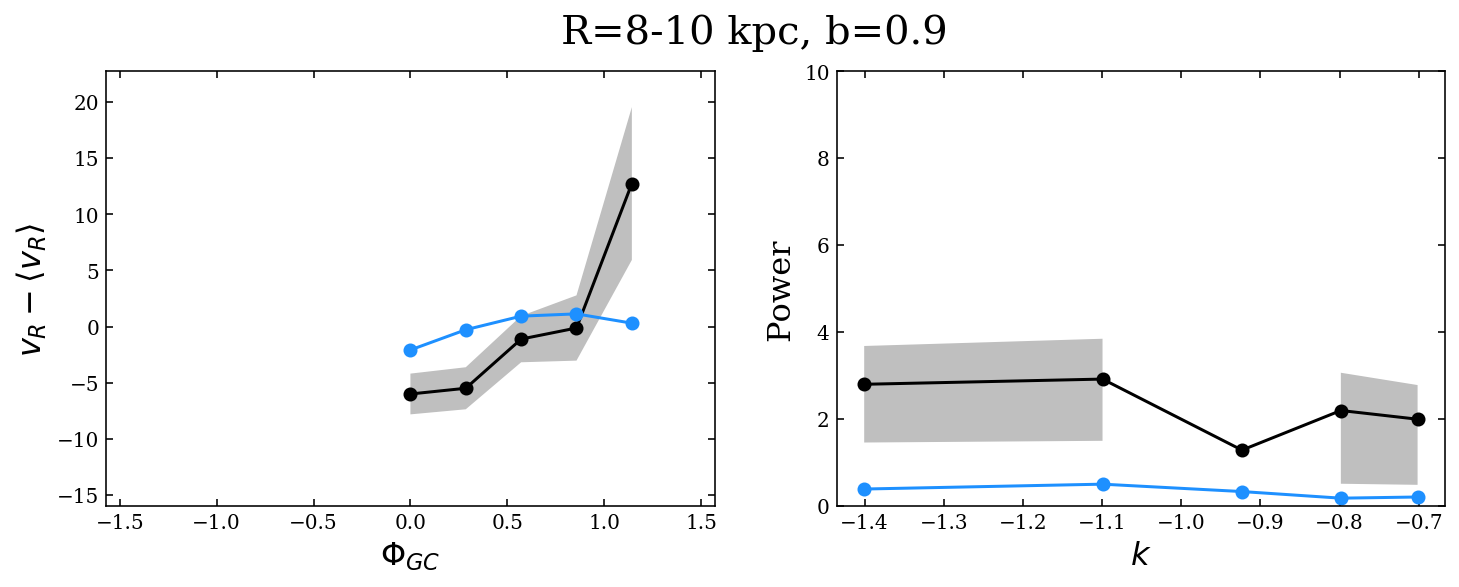

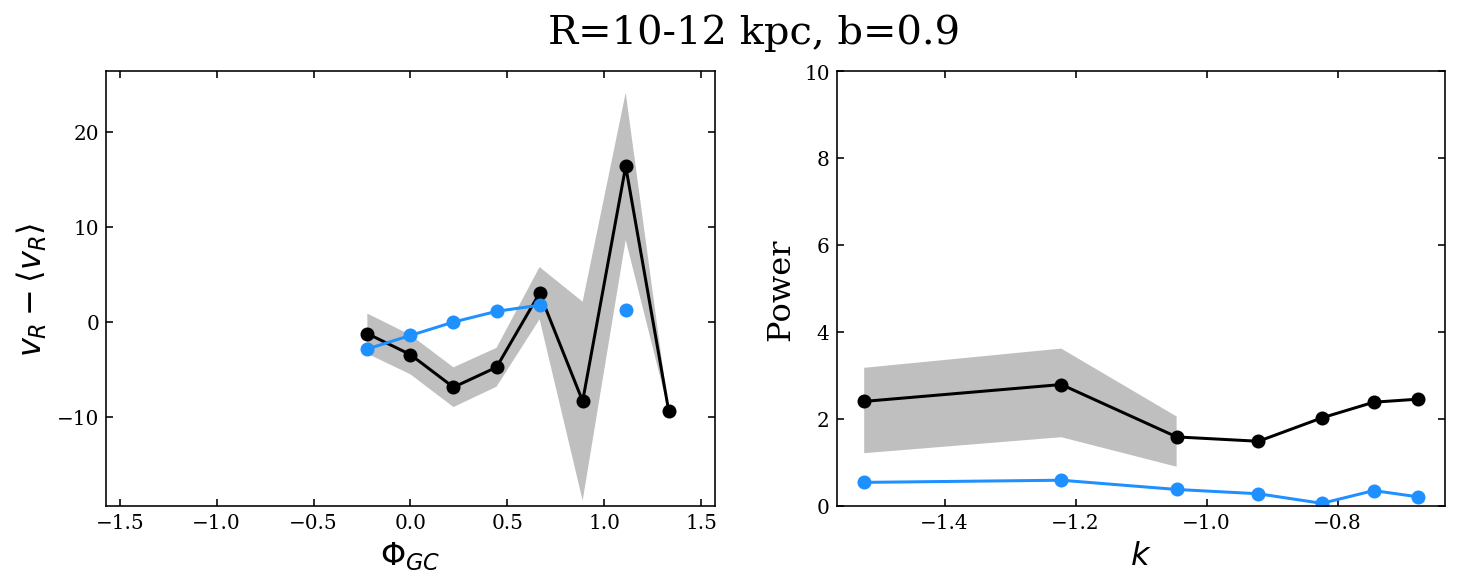

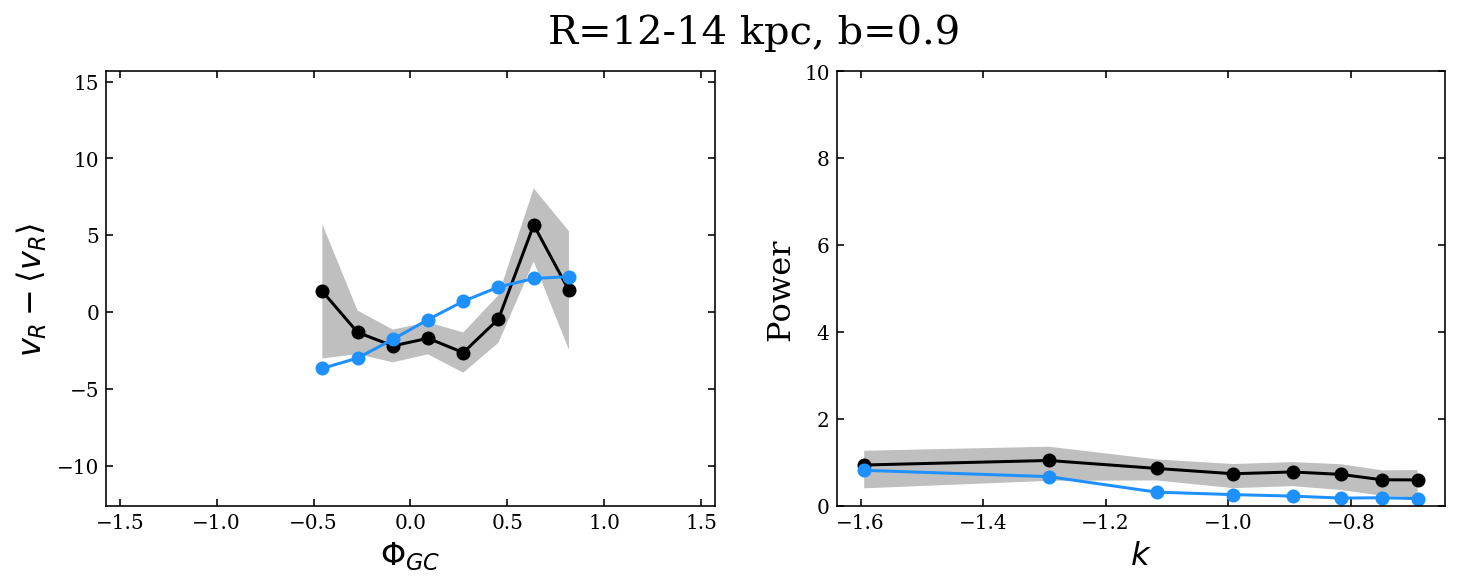

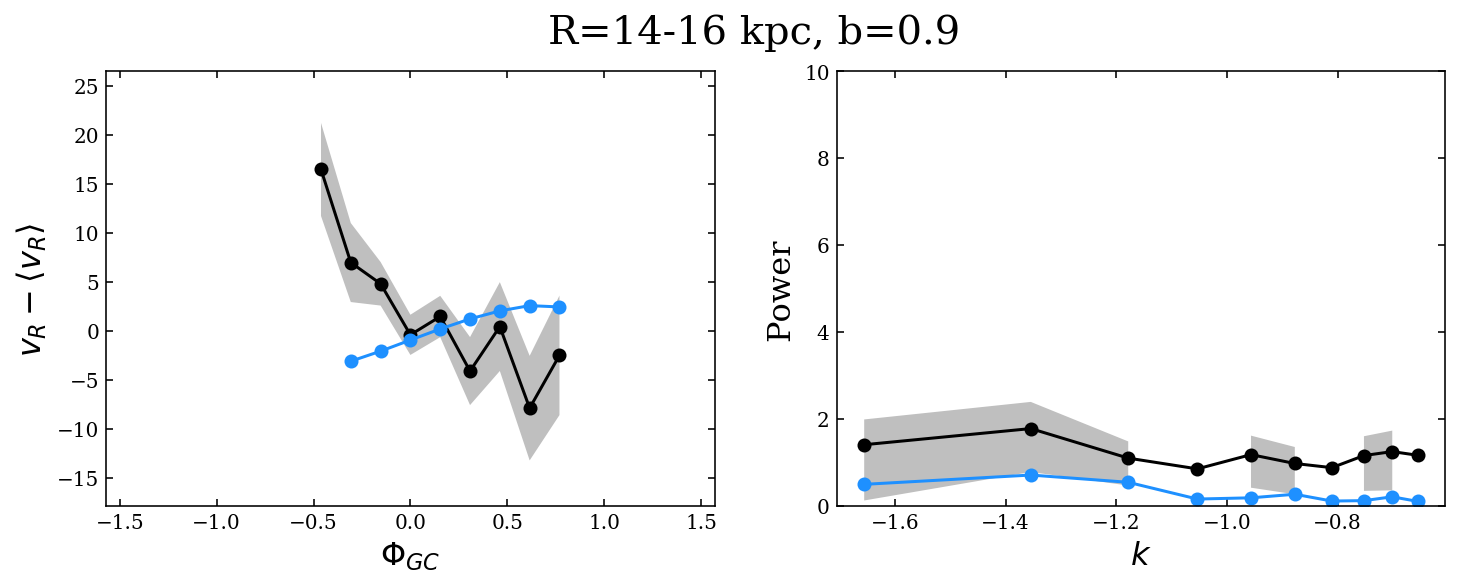



##########




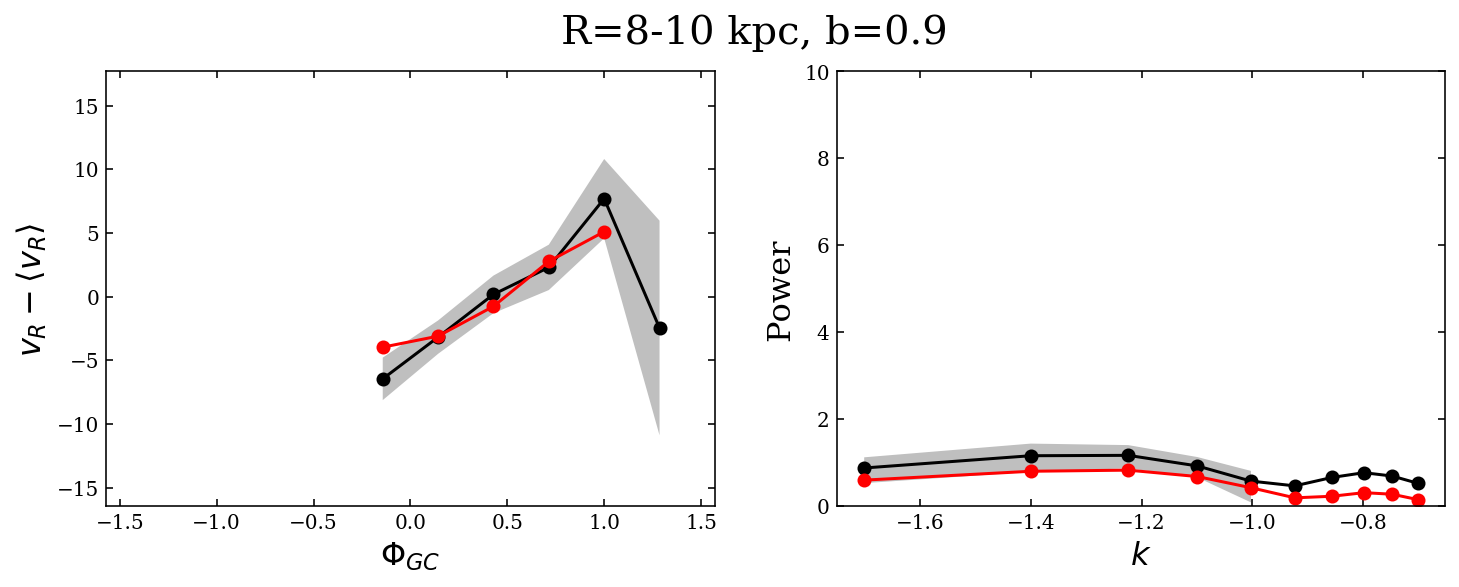

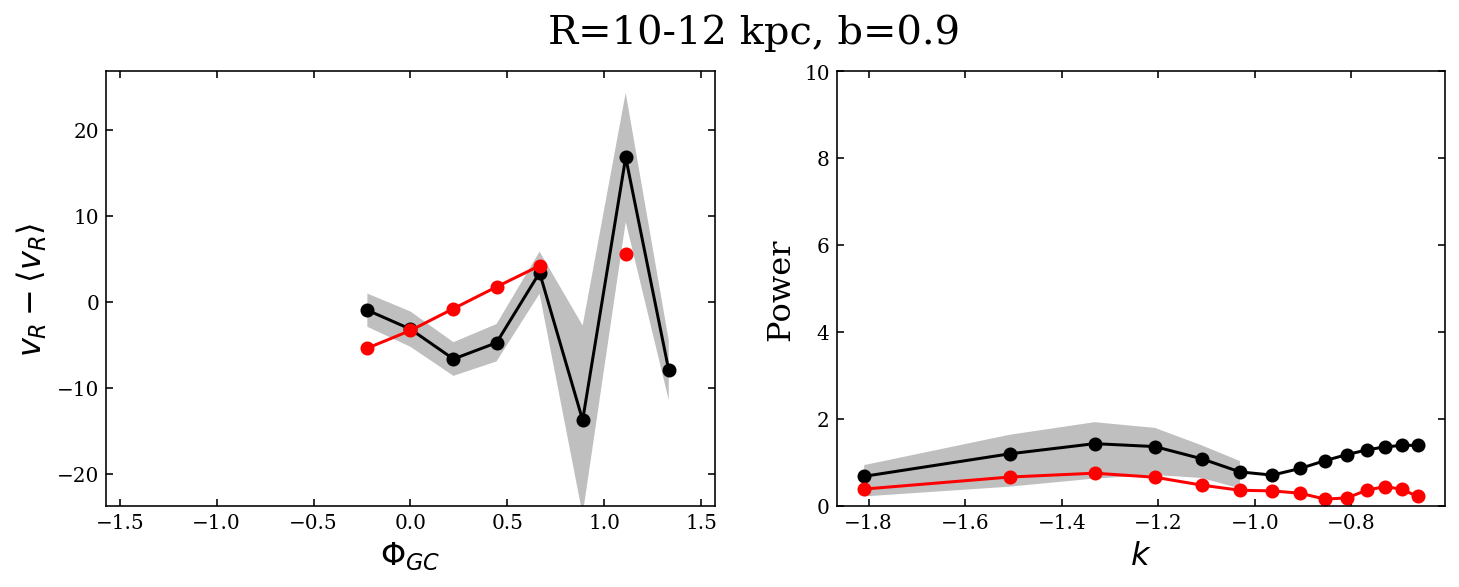

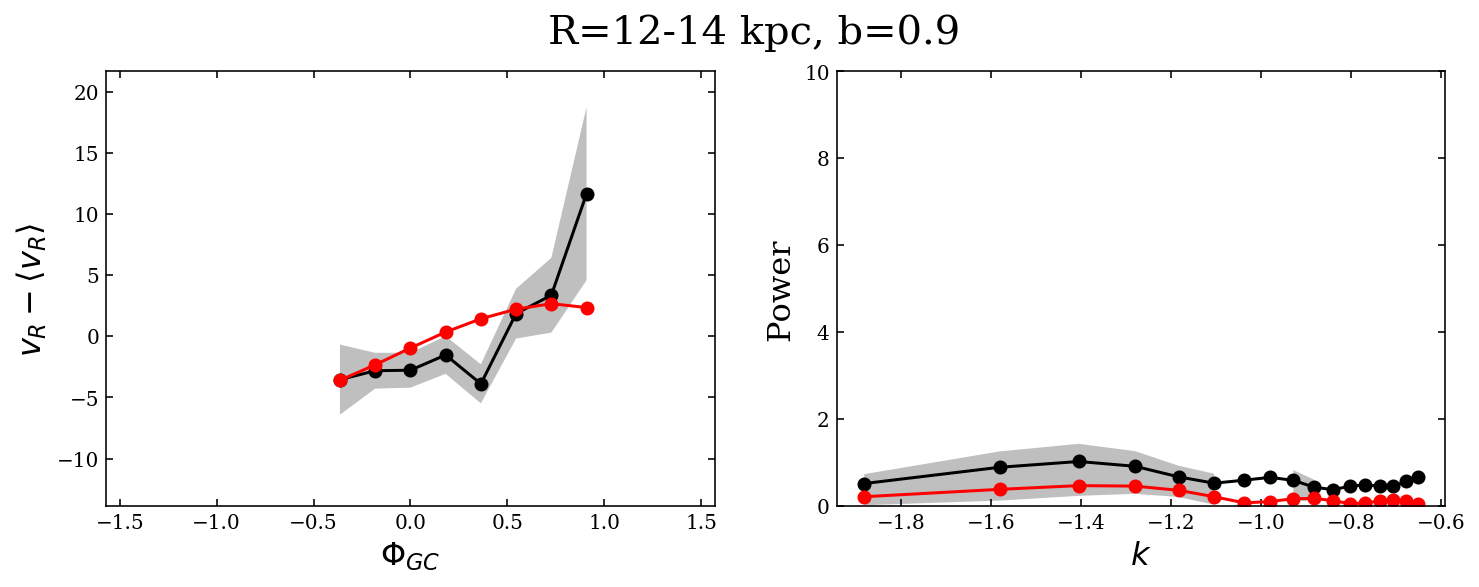

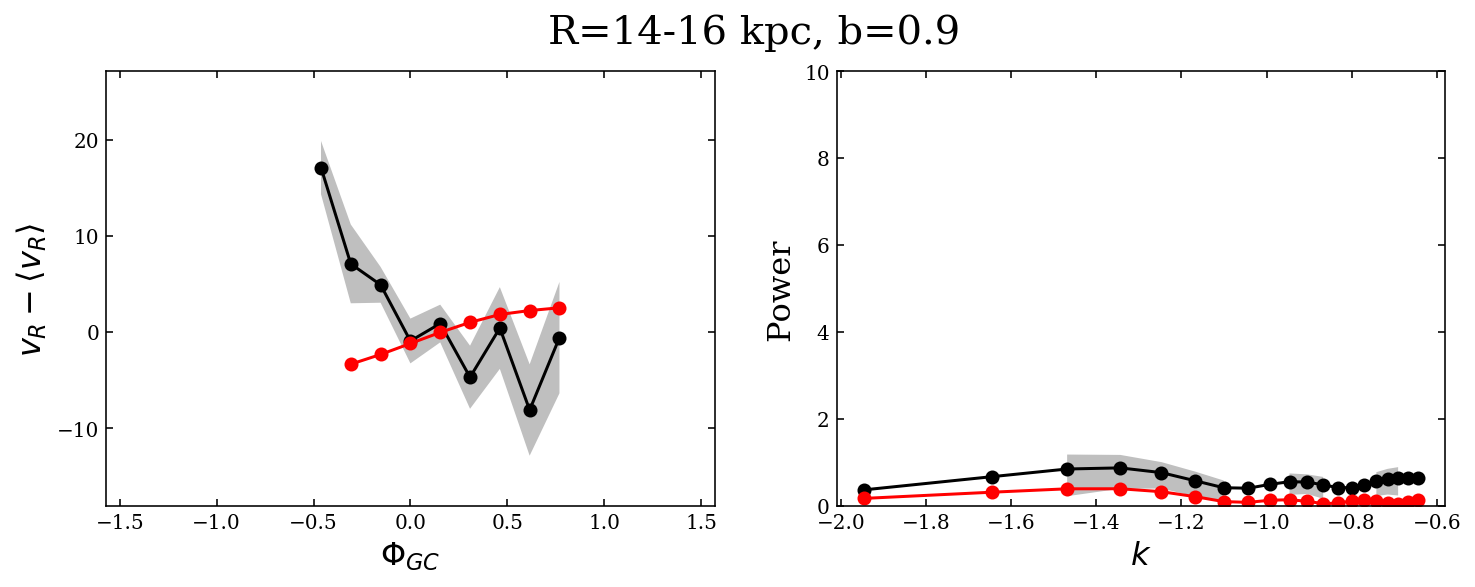



##########




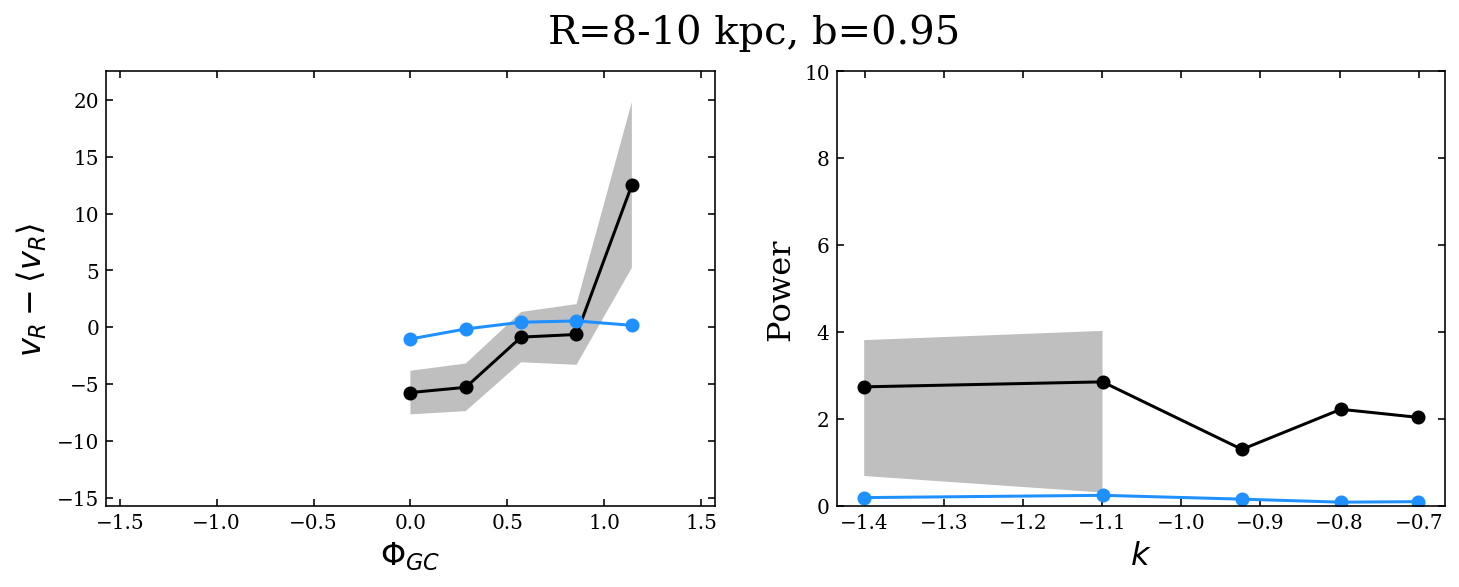

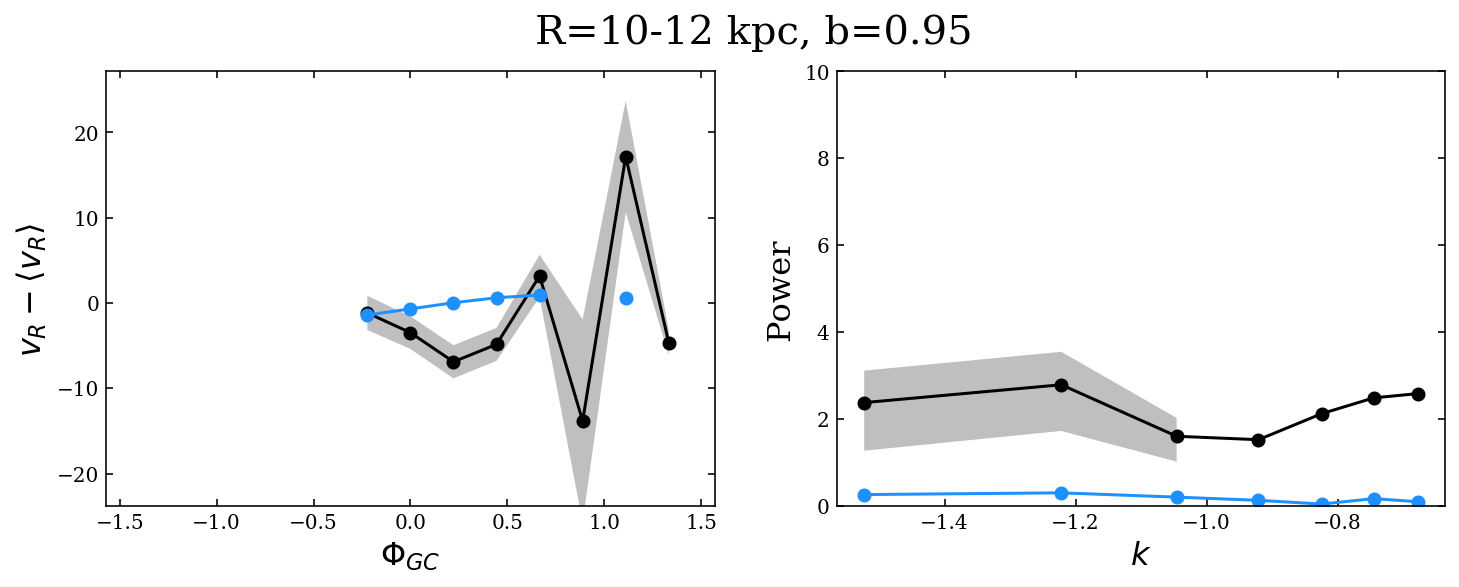

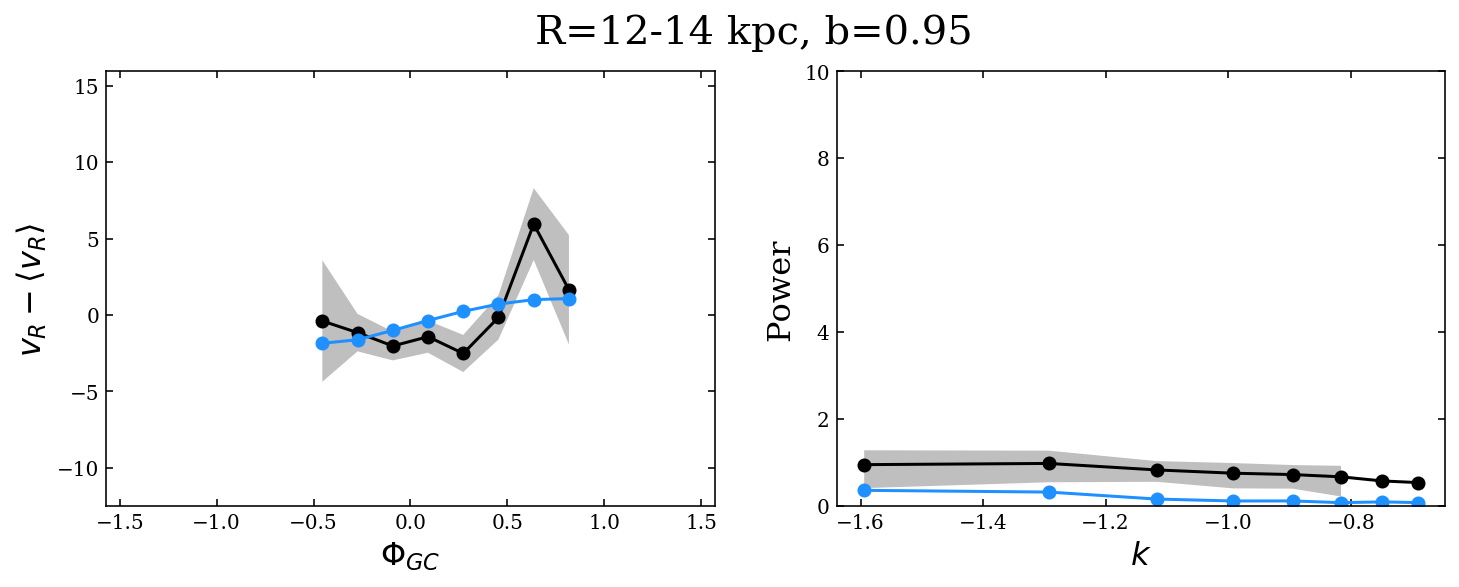

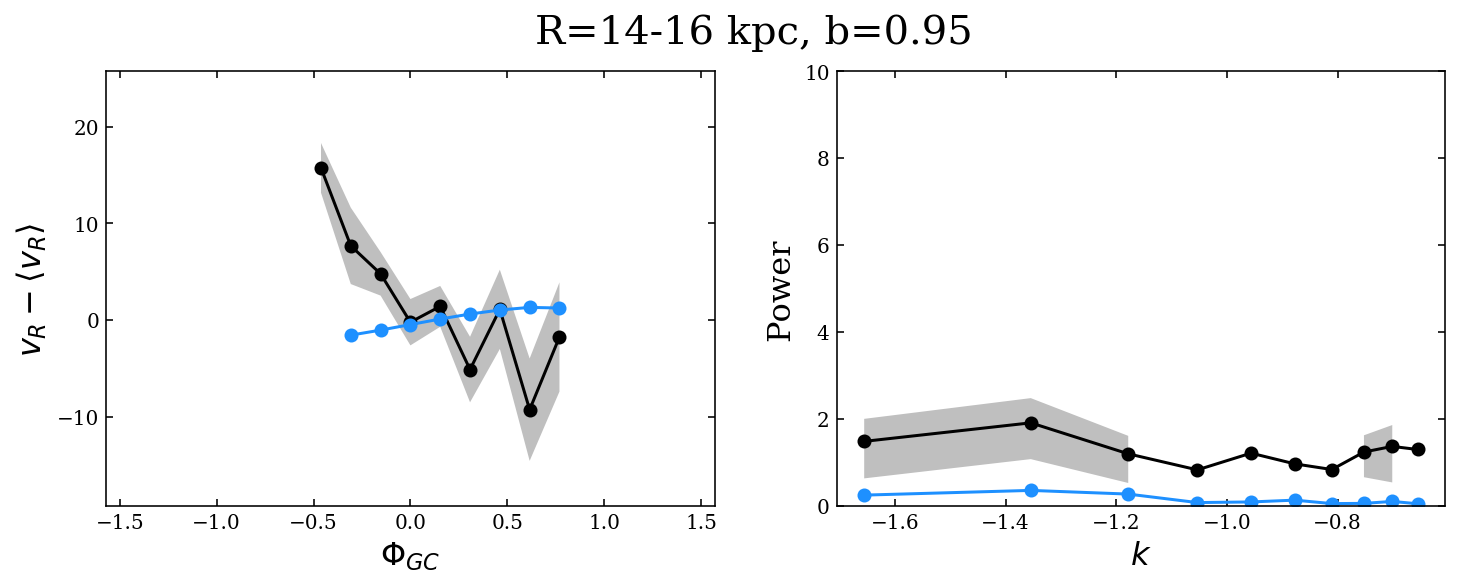



##########




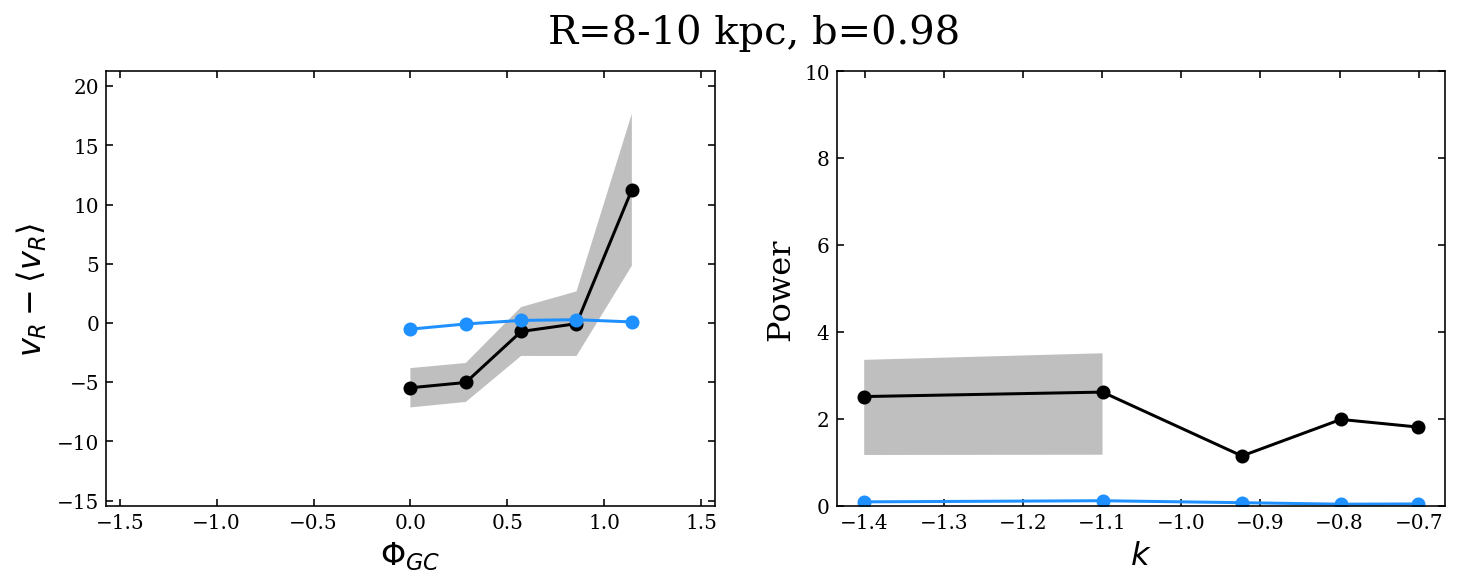

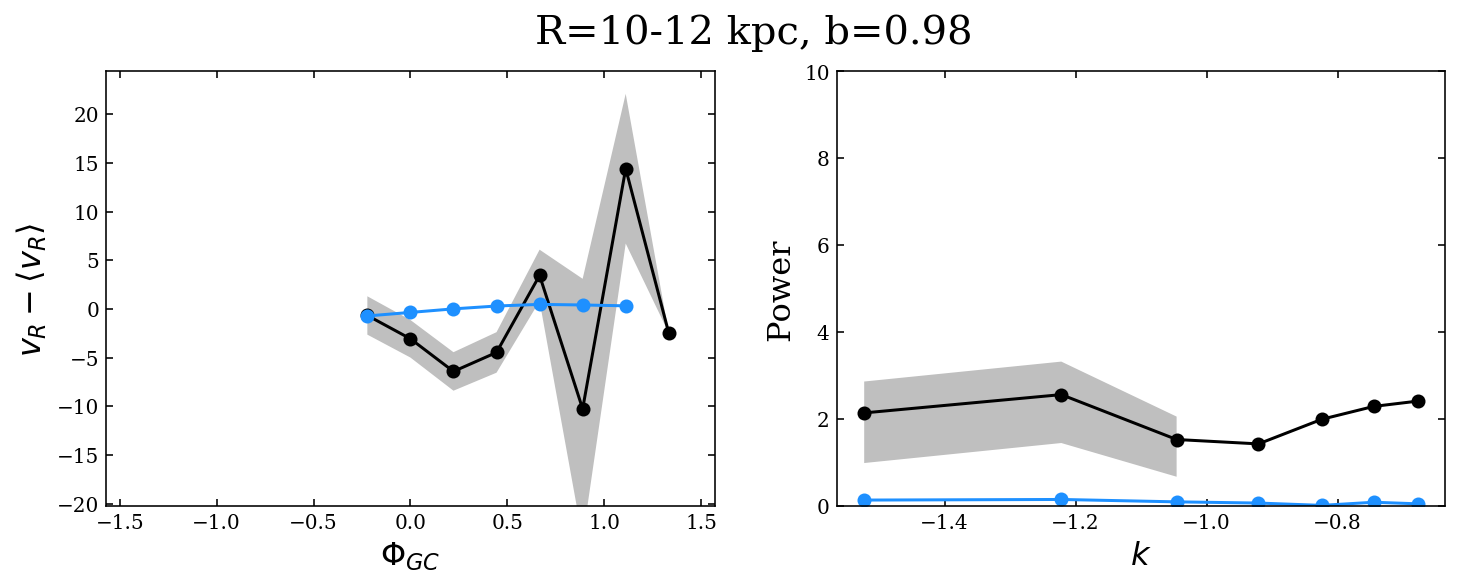

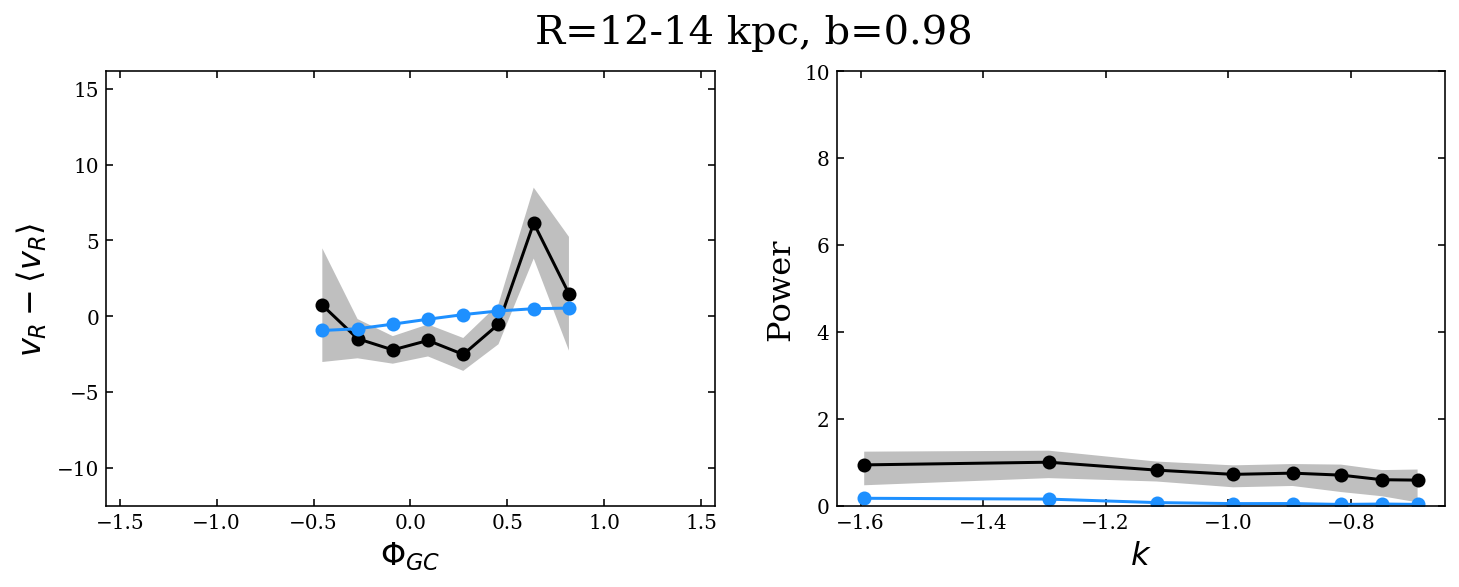

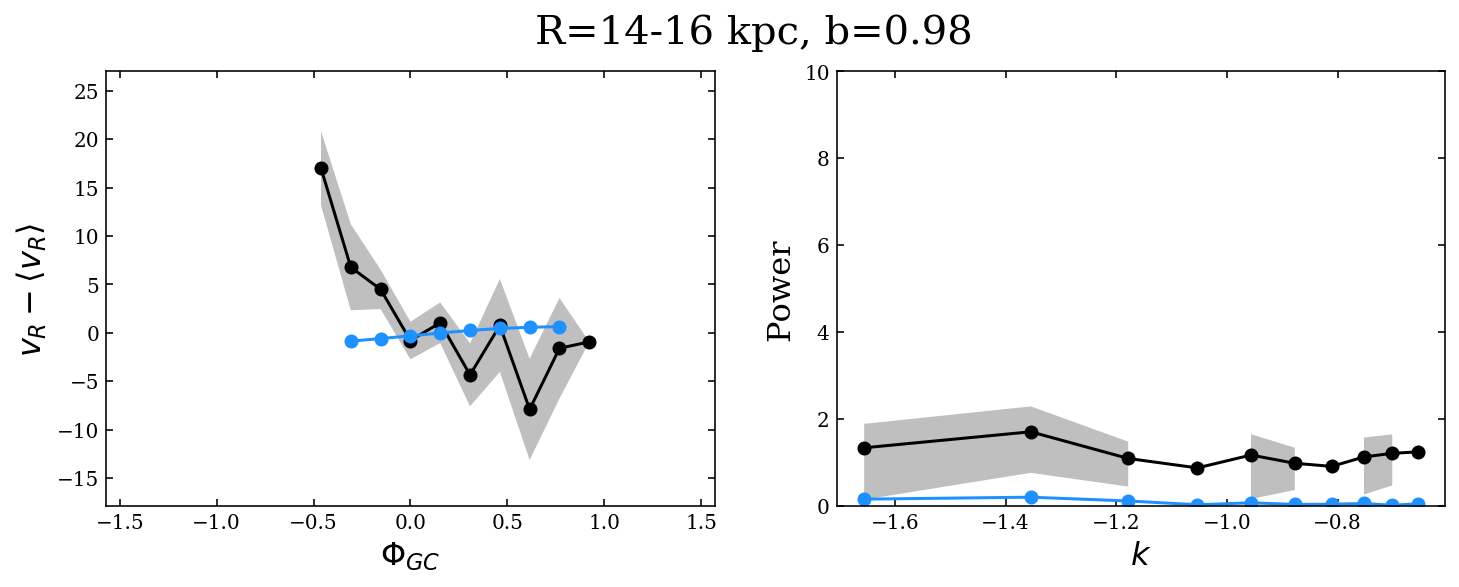



##########




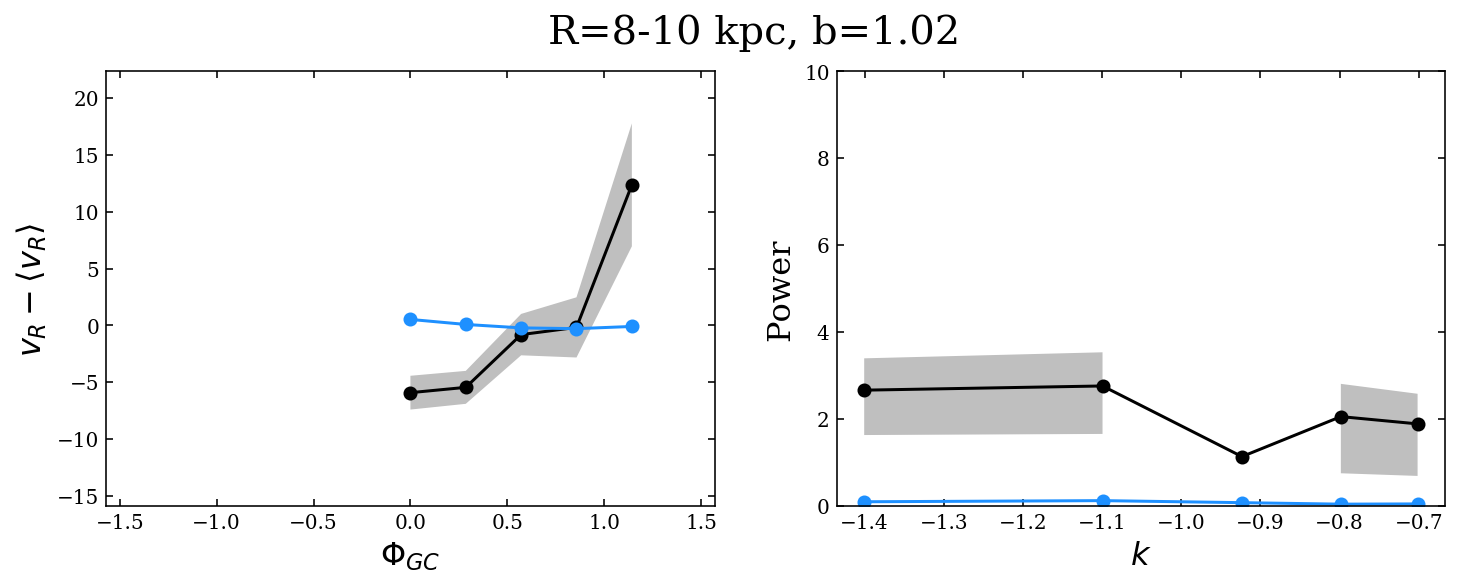

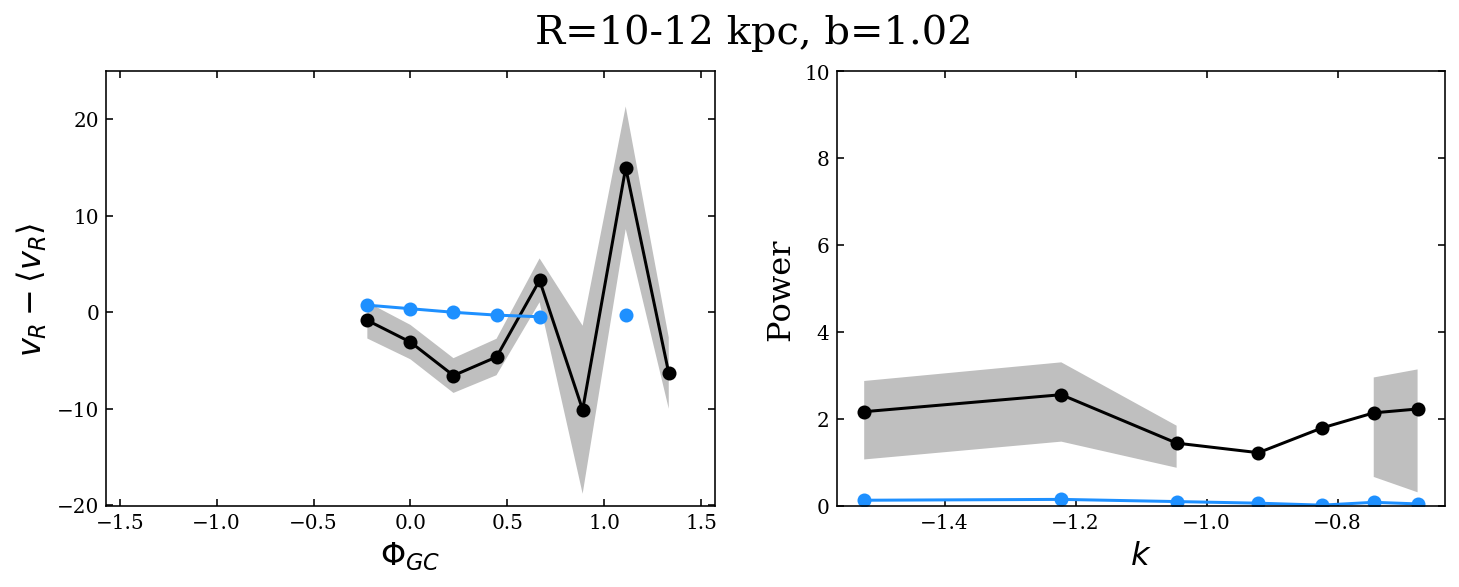

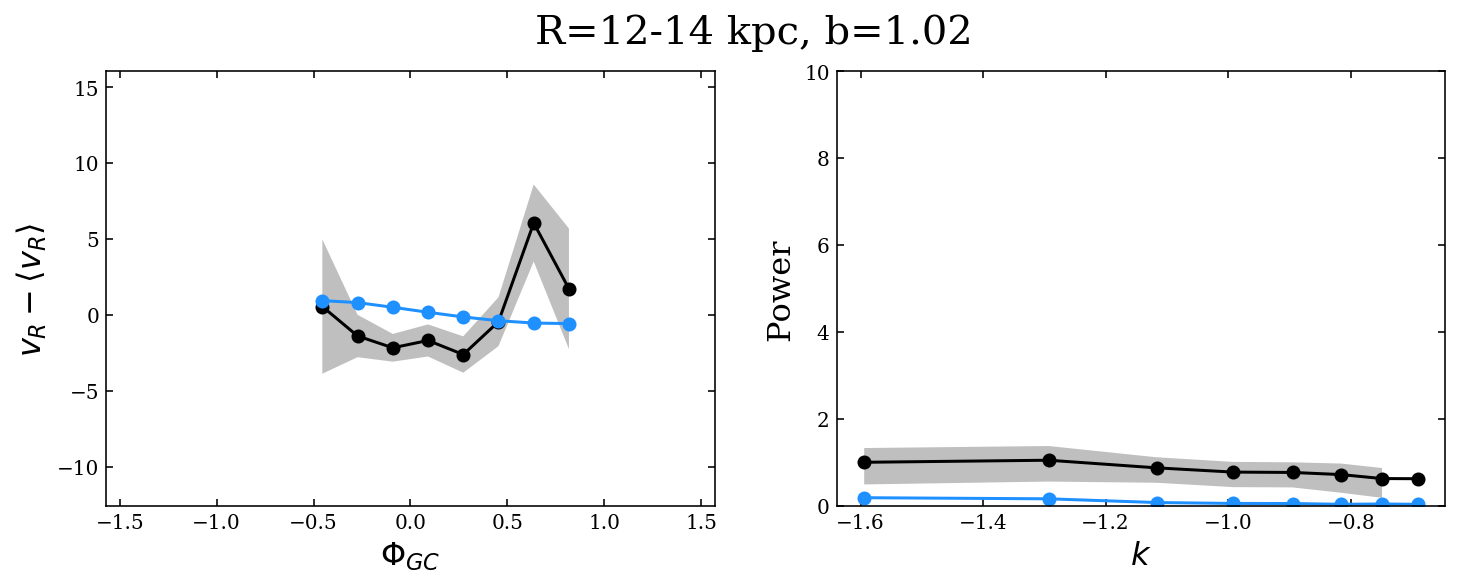

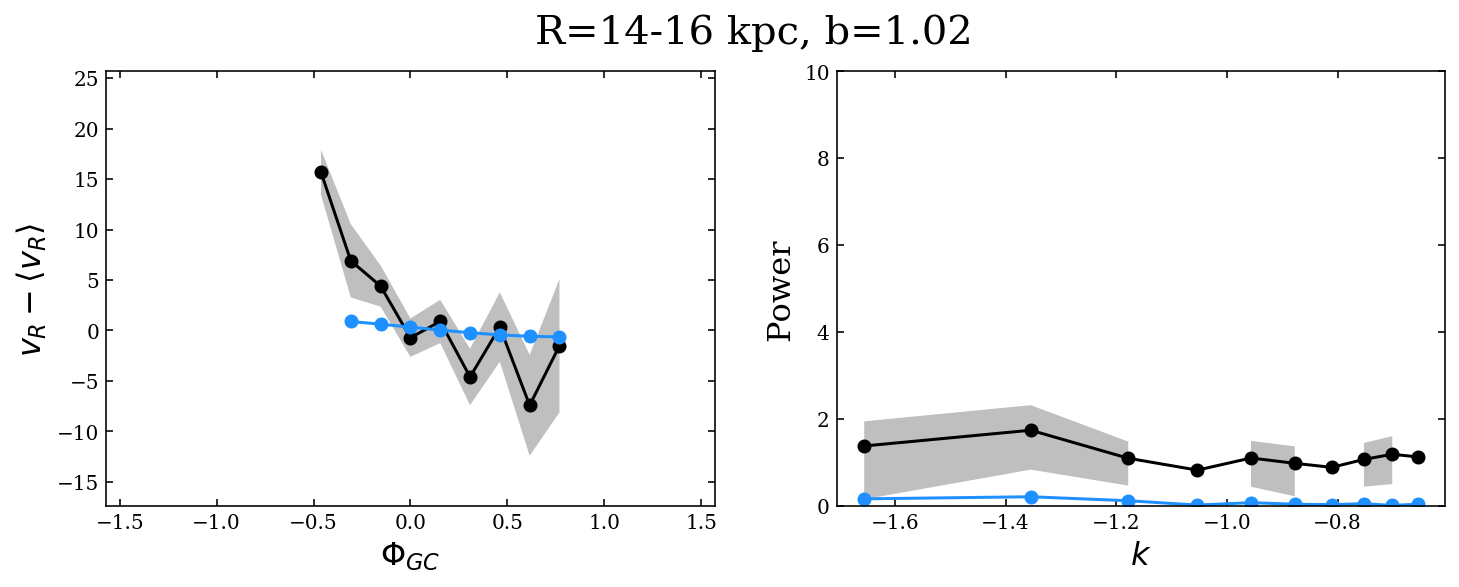



##########




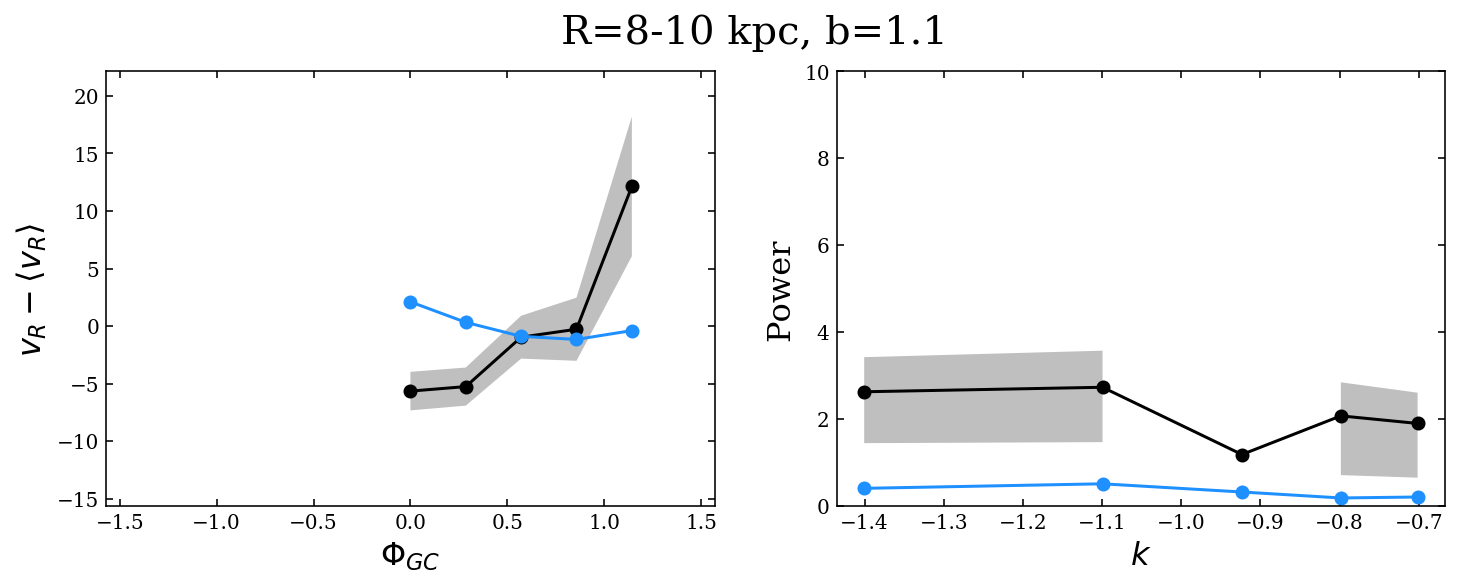

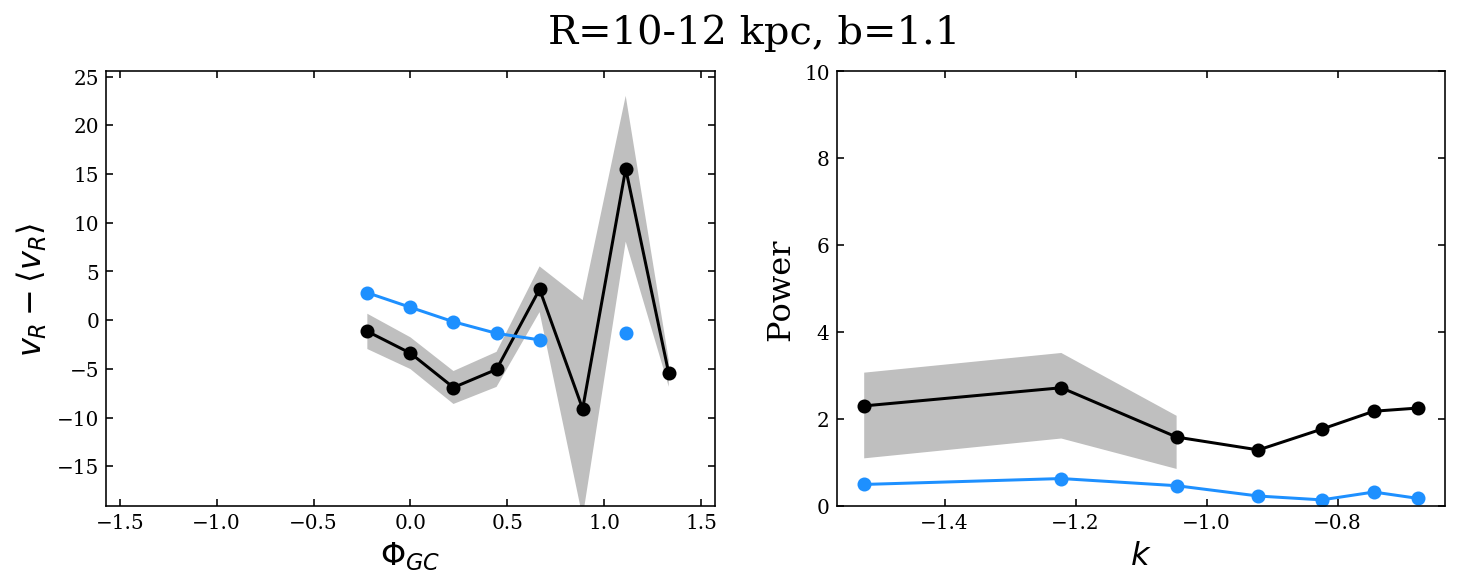

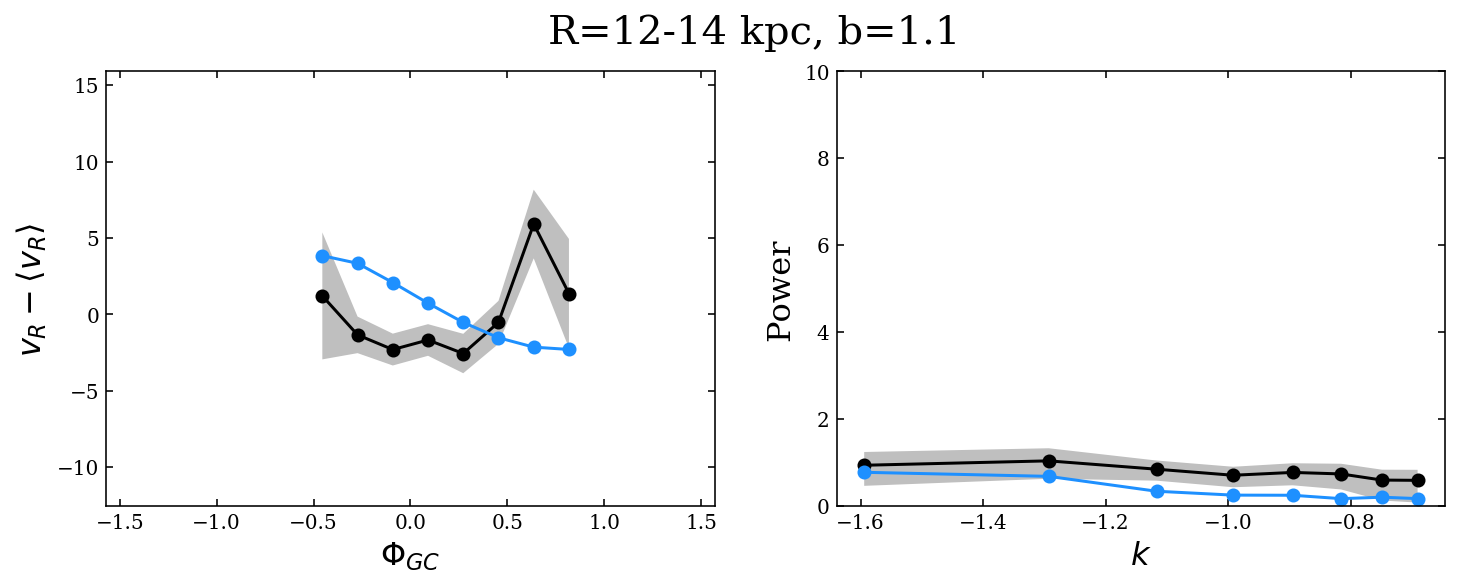

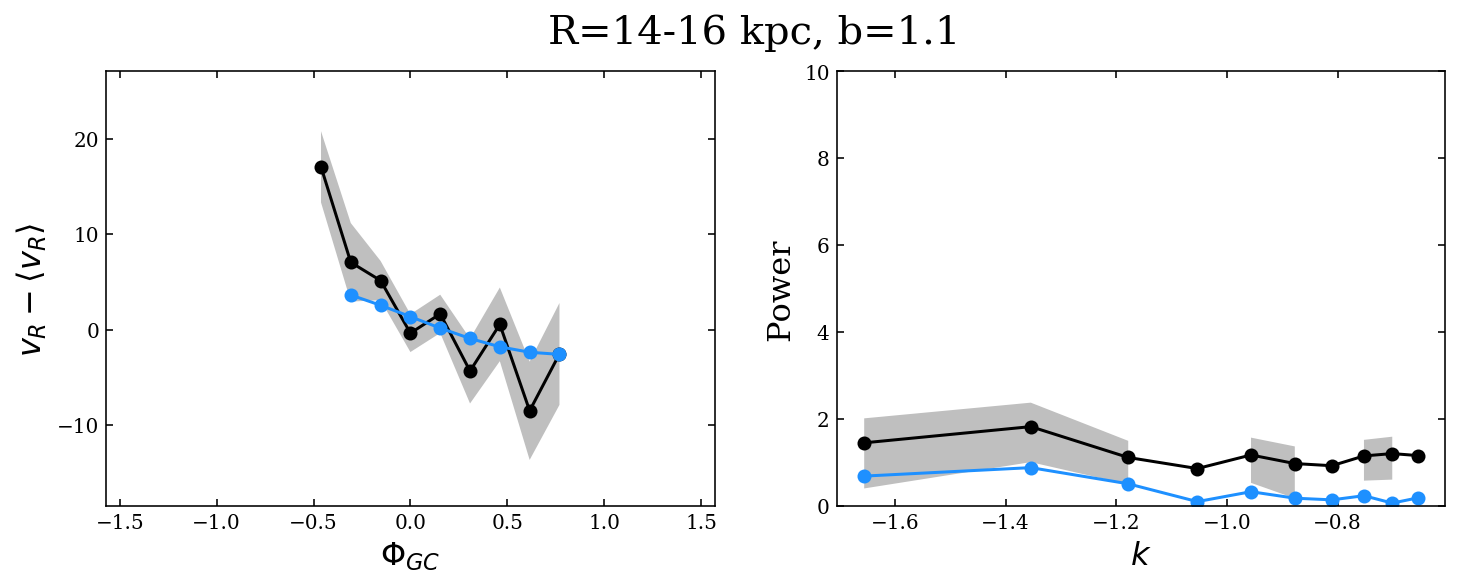



##########




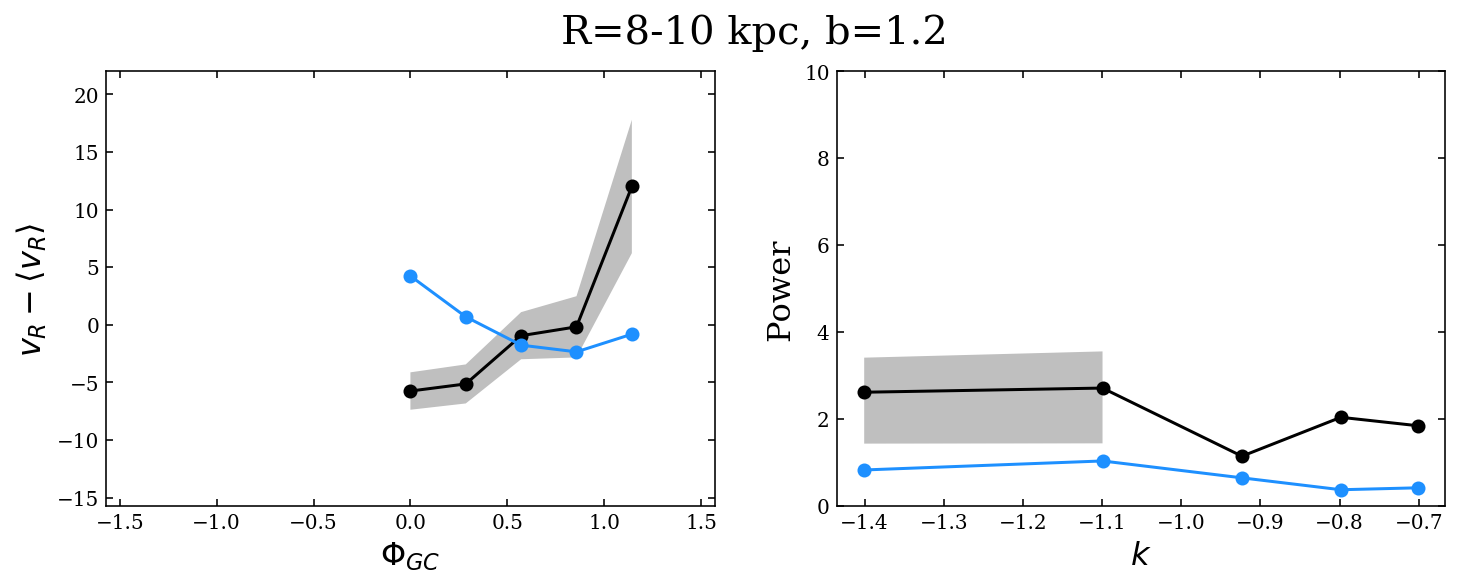

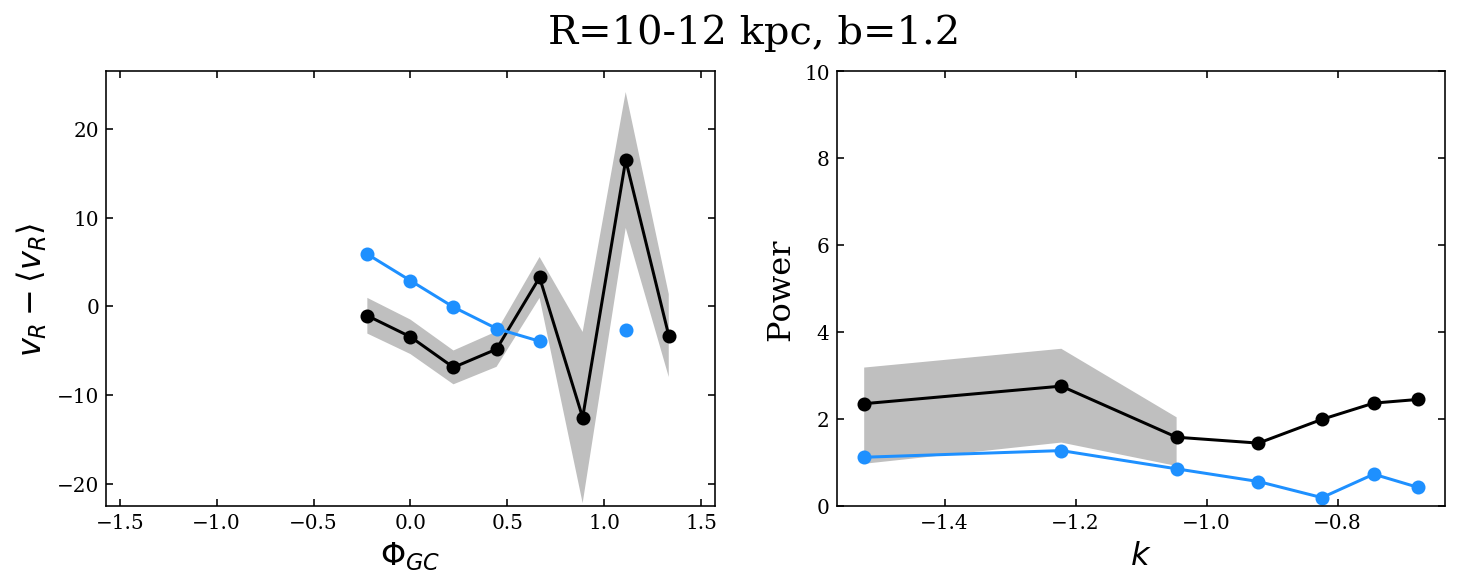

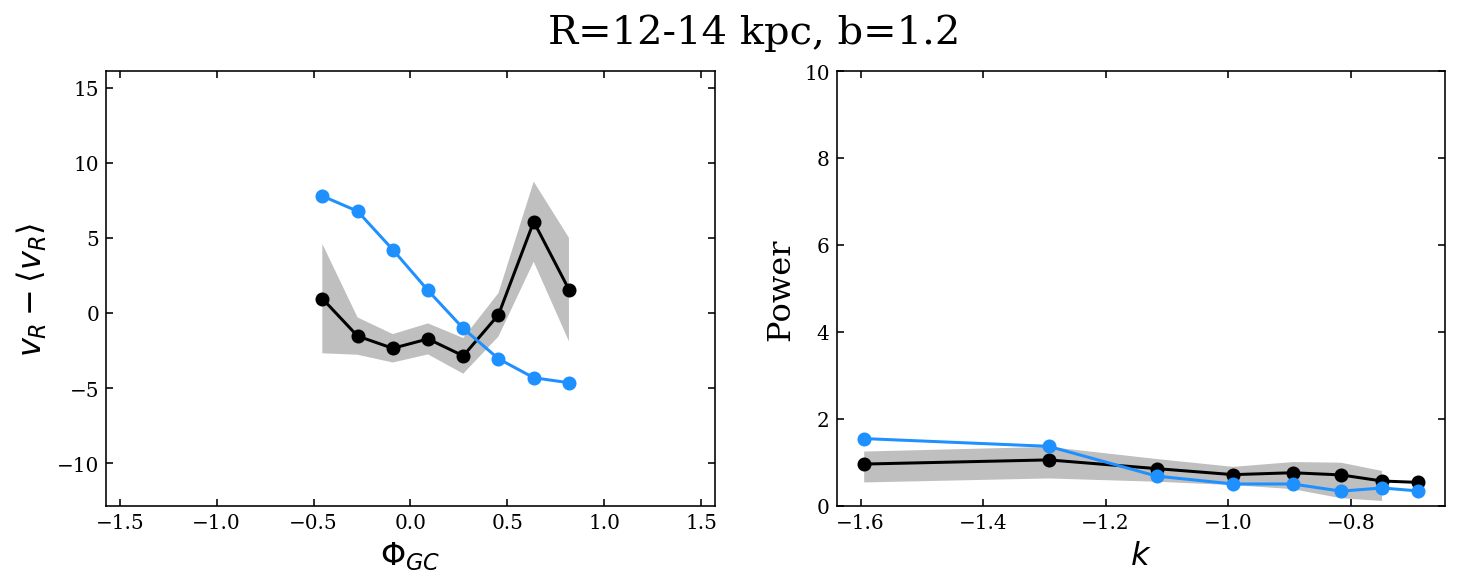

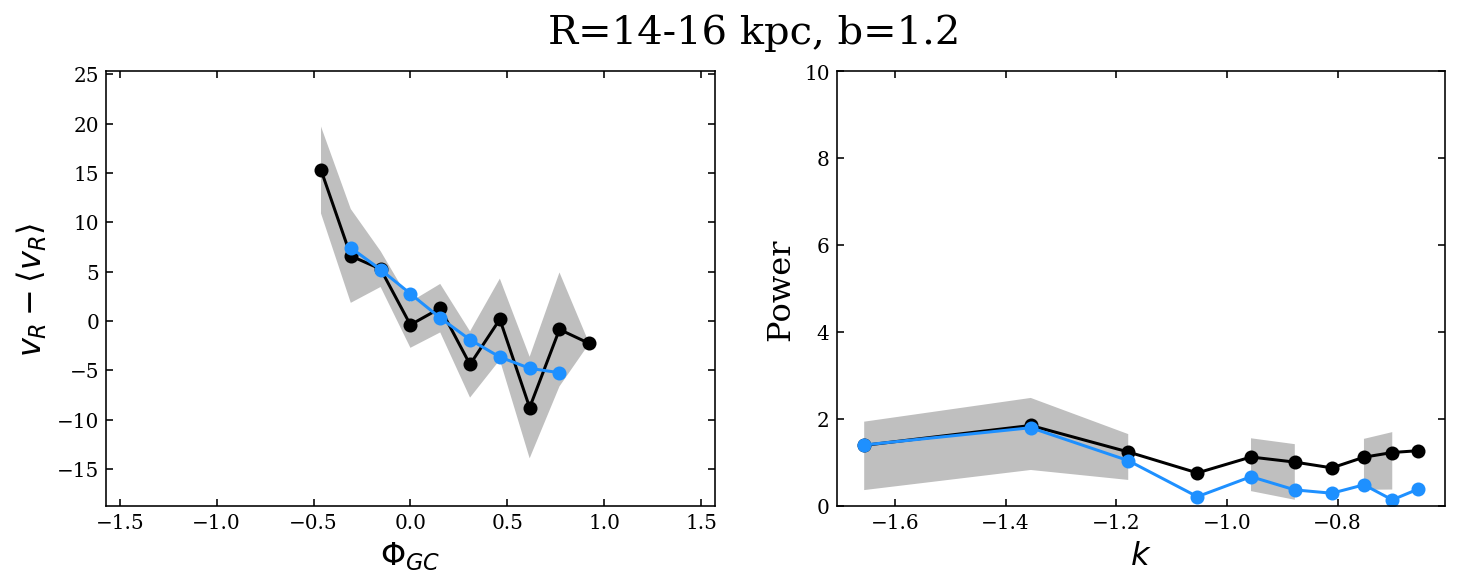



##########




In [29]:
# Plot
fig1 = plt.figure( figsize=(5,12) )
axs1 = fig1.subplots(nrows=5, ncols=1)

fig2 = plt.figure( figsize=(5,12) )
axs2 = fig2.subplots(nrows=5, ncols=1)

# Radial velocity# Now loop over each radial bin
for i in range( n_files ):
    
    sim_data = np.load(files[i])
    
    # Now loop over each radial bin
    for j in range( len(R_range) ):
        
        if R_range[j] < 8: continue
        
        # Find the simulated data just at this radius
        sim_data_R = sim_data[ np.where( sim_data[:,0] == R_range[j] )[0], : ]

        # Bootstrap over the samples
        for k in range(n_bs):

            # Take a random sub-sample of Gaia stars
            sample = np.random.randint(0,len(gc_x),len(gc_x))
            samp_gc_R = gc_R[sample]
            samp_gc_phi = gc_phi[sample]
            samp_gc_vT = gc_vR[sample]

            # Select the stars in this bin
            stars_in_bin = np.where( (samp_gc_R > (R_range[j]-R_bin_size/2) ) & 
                                     (samp_gc_R < (R_range[j]+R_bin_size/2) ) )[0]
            gcvt_in_bin = samp_gc_vT[stars_in_bin]
            gcphi_in_bin = samp_gc_phi[stars_in_bin]
            
            # Select the simulated data
            sim_vt = sim_data_R[:,4]
            sim_phi = sim_data_R[:,1]
            
            # Determine the size of the phi bins, and bin the Gaia data to match
            phi_bin_size_arc = np.diff( sim_data_R[:,1]*sim_data_R[:,0] )[0]
            phi_bin_size = np.diff( sim_data_R[:,1] )[0]
            phi_samp_bin_cents = sim_data_R[:,1]
            phi_samp_bin_edges = np.append( sim_data_R[:,1]-phi_bin_size/2, sim_data_R[-1,1]+phi_bin_size/2 ) 

            # Bin in phi
            binned_vt, _, _ = binned_statistic(gcphi_in_bin, gcvt_in_bin, 
                                               bins=phi_samp_bin_edges, 
                                               statistic='mean')

            # Make a number histogram to examine whether there is enough stars for a valid measurement
            binned_n, _, = np.histogram(gcphi_in_bin, bins=phi_samp_bin_edges)
            where_low_bin_numbers = np.where(binned_n < 10)
            
            # Exclude areas where there wasn't a valid measurement
            binned_vt[where_low_bin_numbers] = np.nan
            sim_vt[where_low_bin_numbers] = np.nan

            # Find where there was data
            where_data = np.where( np.isfinite(binned_vt) )
            where_no_data = np.where( np.isnan(binned_vt) )
            binned_vt[ where_no_data ] = np.nan
            sim_vt[ where_no_data ] = np.nan
            
            # Subtract off mean where non-zero
            mean_binned_vt = np.nanmean( binned_vt[where_data] )
            mean_sim_vt = np.nanmean( sim_vt[where_data] )
            binned_vt = binned_vt - mean_binned_vt
            sim_vt = sim_vt - mean_sim_vt

            # Get the power spectrum
            samp_ks, samp_pk = ast1501.fourier.psd(binned_vt, phi_bin_size_arc, pad=False, return_phase=False)
            sim_ks, sim_pk = ast1501.fourier.psd(sim_vt, phi_bin_size_arc, pad=False, return_phase=False)

            if k == 0:
                bs_phi_samp = np.zeros((n_bs, len(phi_samp_bin_cents)))
                bs_vT_samp = np.zeros((n_bs, len(binned_vt)))
                bs_k_vT_samp = np.zeros((n_bs, len(samp_ks)))
                bs_pk_vT_samp = np.zeros((n_bs, len(samp_pk)))
                
                bs_phi_sim = np.zeros((n_bs, len(sim_phi)))
                bs_vT_sim = np.zeros((n_bs, len(sim_vt)))
                bs_k_vT_sim = np.zeros((n_bs, len(sim_ks)))
                bs_pk_vT_sim = np.zeros((n_bs, len(sim_pk)))
            ##fi
            
            bs_phi_samp[k] = phi_samp_bin_cents
            bs_vT_samp[k] = binned_vt
            bs_k_vT_samp[k] = samp_ks
            bs_pk_vT_samp[k] = samp_pk
            
            bs_phi_sim[k] = sim_phi
            bs_vT_sim[k] = sim_vt
            bs_k_vT_sim[k] = sim_ks
            bs_pk_vT_sim[k] = sim_pk

        # Take the average and standard deviation of the azimuthal profile
        bs_avg_vT_samp = np.nanmean(bs_vT_samp, axis=0)
        bs_std_vT_samp = np.nanstd(bs_vT_samp, axis=0)
        bs_avg_vT_sim = np.nanmean(bs_vT_sim, axis=0)
        bs_std_vT_sim = np.nanstd(bs_vT_sim, axis=0)

        # Take the average and standard deviation of the power spectrum
        bs_avg_pk_vT_samp = np.nanmean(bs_pk_vT_samp, axis=0)
        bs_std_pk_vT_samp = np.nanstd(bs_pk_vT_samp, axis=0)
        bs_avg_pk_vT_sim = np.nanmean(bs_pk_vT_sim, axis=0)
        bs_std_pk_vT_sim = np.nanstd(bs_pk_vT_sim, axis=0)


        axs1[j].plot(bs_phi_samp[0], bs_avg_vT_samp, color='Black', marker='o')
        axs1[j].fill_between(bs_phi_samp[0], 
                         bs_avg_vT_samp+bs_std_vT_samp, 
                         bs_avg_vT_samp-bs_std_vT_samp, 
                         alpha=0.5, facecolor='Grey' )
        axs1[j].plot(bs_phi_sim[0], bs_avg_vT_sim, color=use_color, marker='o')
        
        axs1[j].set_xlabel(r'$\Phi_{GC}$', fontsize=16)
        axs1[j].set_ylabel(r'$v_{R}- \langle {v_{R}} \rangle$', fontsize=16)
        axs1[j].set_xlim(-np.pi/2,np.pi/2)
        axs1[j].set_ylim( np.nanmin(bs_avg_vT_samp)-10, np.nanmax(bs_avg_vT_samp)+10 )

        ind_ks_pos_samp = int(1+len(bs_k_vT_samp[0])/2)
        ind_ks_pos_sim = int(1+len(bs_k_vT_sim[0])/2)
        
        bs_k_vT_samp_pos = np.abs( bs_k_vT_samp[0,ind_ks_pos_samp:] ) 
        bs_k_vT_sim_pos = np.abs( bs_k_vT_sim[0,ind_ks_pos_sim:] ) 
        
        axs2[j].plot(np.log10(bs_k_vT_samp_pos), np.sqrt(bs_avg_pk_vT_samp[ind_ks_pos_samp:]), 
                 color='Black', marker='o')
        axs2[j].fill_between( np.log10(bs_k_vT_samp_pos), 
                         np.sqrt(bs_avg_pk_vT_samp[ind_ks_pos_samp:]+bs_std_pk_vT_samp[ind_ks_pos_samp:]), 
                         np.sqrt(bs_avg_pk_vT_samp[ind_ks_pos_samp:]-bs_std_pk_vT_samp[ind_ks_pos_samp:]),
                         alpha=0.5, facecolor='Grey' )
        axs2[j].plot(np.log10(bs_k_vT_sim_pos), np.sqrt(bs_avg_pk_vT_sim[ind_ks_pos_sim:]), 
                 color=use_color, marker='o')
        axs2[j].set_xlabel(r'$k$', fontsize=16)
        axs2[j].set_ylabel('Power', fontsize=16)
        axs2[j].set_ylim(0,10)
        axs2[j].set_xlim(-2,-0.5)

        fig.suptitle('R='+str(int(R_range[j]))+'-'+str(int(R_range[j]+R_bin_size))+' kpc, b='+str(b_values[i]), fontsize=20)

        plt.show()
        plt.close('all')
    ###j
    
    print('\n\n##########\n\n')
    
###i

In [ ]:
# Plot
fig1 = plt.figure( figsize=(5,12) )
axs1 = fig1.subplots(nrows=5, ncols=1)

fig2 = plt.figure( figsize=(5,12) )
axs2 = fig2.subplots(nrows=5, ncols=1)

# Now loop over each radial bin
for i in range( n_files ):
    
    sim_data = np.load(files[i])
    print(files[i])
    print(b_values[i])
    
    # Now loop over each radial bin
    for j in range( len(R_range) ):
        
        # Find the simulated data just at this radius
        sim_data_R = sim_data[ np.where( sim_data[:,0] == R_range[j] )[0], : ]

        # Bootstrap over the samples
        for k in range(n_bs):

            # Take a random sub-sample of Gaia stars
            sample = np.random.randint(0,len(gc_x),len(gc_x))
            samp_gc_R = gc_R[sample]
            samp_gc_phi = gc_phi[sample]
            samp_gc_vT = gc_vR[sample]

            # Select the stars in this bin
            stars_in_bin = np.where( (samp_gc_R > (R_range[j]-R_bin_size/2) ) & 
                                     (samp_gc_R < (R_range[j]+R_bin_size/2) ) )[0]
            gcvt_in_bin = -samp_gc_vT[stars_in_bin]
            gcphi_in_bin = samp_gc_phi[stars_in_bin]
            
            # Select the simulated data
            sim_vt = sim_data_R[:,8]
            sim_phi = sim_data_R[:,1]
            
            # Determine the size of the phi bins, and bin the Gaia data to match
            phi_bin_size_arc = np.diff( sim_data_R[:,1]*sim_data_R[:,0] )[0]
            phi_bin_size = np.diff( sim_data_R[:,1] )[0]
            phi_samp_bin_cents = sim_data_R[:,1]
            phi_samp_bin_edges = np.append( sim_data_R[:,1]-phi_bin_size/2, sim_data_R[-1,1]+phi_bin_size/2 ) 

            # Bin in phi
            binned_vt, _, _ = binned_statistic(gcphi_in_bin, gcvt_in_bin, 
                                               bins=phi_samp_bin_edges, 
                                               statistic='mean')

            # Make a number histogram to examine whether there is enough stars for a valid measurement
            binned_n, _, = np.histogram(gcphi_in_bin, bins=phi_samp_bin_edges)
            where_low_bin_numbers = np.where(binned_n < 10)
            
            # Exclude areas where there wasn't a valid measurement
            binned_vt[where_low_bin_numbers] = np.nan
            sim_vt[where_low_bin_numbers] = np.nan

            # Find where there was data
            where_data = np.where( np.isfinite(binned_vt) )
            where_no_data = np.where( np.isnan(binned_vt) )
            binned_vt[ where_no_data ] = np.nan
            sim_vt[ where_no_data ] = np.nan
            
            # Subtract off mean where non-zero
            mean_binned_vt = np.nanmean( binned_vt[where_data] )
            mean_sim_vt = np.nanmean( sim_vt[where_data] )
            binned_vt = binned_vt - mean_binned_vt
            sim_vt = sim_vt - mean_sim_vt

            # Get the power spectrum
            samp_ks, samp_pk = ast1501.fourier.psd(binned_vt, phi_bin_size_arc, pad=False, return_phase=False)
            sim_ks, sim_pk = ast1501.fourier.psd(sim_vt, phi_bin_size_arc, pad=False, return_phase=False)

            if k == 0:
                bs_phi_samp = np.zeros((n_bs, len(phi_samp_bin_cents)))
                bs_vT_samp = np.zeros((n_bs, len(binned_vt)))
                bs_k_vT_samp = np.zeros((n_bs, len(samp_ks)))
                bs_pk_vT_samp = np.zeros((n_bs, len(samp_pk)))
                
                bs_phi_sim = np.zeros((n_bs, len(sim_phi)))
                bs_vT_sim = np.zeros((n_bs, len(sim_vt)))
                bs_k_vT_sim = np.zeros((n_bs, len(sim_ks)))
                bs_pk_vT_sim = np.zeros((n_bs, len(sim_pk)))
            ##fi
            
            bs_phi_samp[k] = phi_samp_bin_cents
            bs_vT_samp[k] = binned_vt
            bs_k_vT_samp[k] = samp_ks
            bs_pk_vT_samp[k] = samp_pk
            
            bs_phi_sim[k] = sim_phi
            bs_vT_sim[k] = sim_vt
            bs_k_vT_sim[k] = sim_ks
            bs_pk_vT_sim[k] = sim_pk

        # Take the average and standard deviation of the azimuthal profile
        bs_avg_vT_samp = np.nanmean(bs_vT_samp, axis=0)
        bs_std_vT_samp = np.nanstd(bs_vT_samp, axis=0)
        bs_avg_vT_sim = np.nanmean(bs_vT_sim, axis=0)
        bs_std_vT_sim = np.nanstd(bs_vT_sim, axis=0)

        # Take the average and standard deviation of the power spectrum
        bs_avg_pk_vT_samp = np.nanmean(bs_pk_vT_samp, axis=0)
        bs_std_pk_vT_samp = np.nanstd(bs_pk_vT_samp, axis=0)
        bs_avg_pk_vT_sim = np.nanmean(bs_pk_vT_sim, axis=0)
        bs_std_pk_vT_sim = np.nanstd(bs_pk_vT_sim, axis=0)

        # Plot the fluctuations
        if i == 0:
            axs1[j].plot(bs_phi_samp[0], bs_avg_vT_samp, color='Black', marker='o')
            axs1[j].fill_between(bs_phi_samp[0], 
                             bs_avg_vT_samp+bs_std_vT_samp, 
                             bs_avg_vT_samp-bs_std_vT_samp, 
                             alpha=0.5, facecolor='Grey' )
        ###i
        axs1[j].plot(bs_phi_sim[0], bs_avg_vT_sim, color=file_colors[i], marker='o', markersize=10)
        
        axs1[j].set_xlabel(r'$\Phi_{GC}$', fontsize=16)
        axs1[j].set_ylabel(r'$v_{T}- \langle {v_{T}} \rangle$', fontsize=16)
        axs1[j].set_xlim(-np.pi/2,np.pi/2)
        axs1[j].set_ylim( np.nanmin(bs_avg_vT_samp)-10, np.nanmax(bs_avg_vT_samp)+10 )
        axs1[j].set_xlim(-0.75,1.5)

        axs1[j].annotate('R='+str(int(R_range[j])+R_bin_size/2)+' kpc', fontsize=14, xy=(0.1,0.1), xycoords='axes fraction')
        
        if j != 4:
            axs1[j].tick_params(labelbottom='off')
        
        ind_ks_pos_samp = int(1+len(bs_k_vT_samp[0])/2)
        ind_ks_pos_sim = int(1+len(bs_k_vT_sim[0])/2)
        
        bs_k_vT_samp_pos = np.abs( bs_k_vT_samp[0,ind_ks_pos_samp:] ) 
        bs_k_vT_sim_pos = np.abs( bs_k_vT_sim[0,ind_ks_pos_sim:] ) 
        
        
        # Plot the power
        if i == 0:
            axs2[j].plot(np.log10(bs_k_vT_samp_pos), np.sqrt(bs_avg_pk_vT_samp[ind_ks_pos_samp:]), 
                 color='Black', marker='o')
            axs2[j].fill_between( np.log10(bs_k_vT_samp_pos), 
                         np.sqrt(bs_avg_pk_vT_samp[ind_ks_pos_samp:]+bs_std_pk_vT_samp[ind_ks_pos_samp:]), 
                         np.sqrt(bs_avg_pk_vT_samp[ind_ks_pos_samp:]-bs_std_pk_vT_samp[ind_ks_pos_samp:]),
                         alpha=0.5, facecolor='Grey' )
        ###i
        axs2[j].plot(np.log10(bs_k_vT_sim_pos), np.sqrt(bs_avg_pk_vT_sim[ind_ks_pos_sim:]), 
                 color=file_colors[i], marker='o', markersize=10)
        axs2[j].set_xlabel(r'log k / kpc$^{-1}$', fontsize=16)
        axs2[j].set_ylabel('Power', fontsize=16)
        axs2[j].set_ylim(0,7)
        axs2[j].set_xlim(-2,-0.5)

        axs2[j].annotate('R='+str(int(R_range[j])+R_bin_size/2)+' kpc', fontsize=14, xy=(0.65,0.85), xycoords='axes fraction')

#         plt.show()
#         plt.close('all')
    ###j
###i

fig1.subplots_adjust(hspace=0)
fig2.subplots_adjust(hspace=0)

fig1.savefig('out1.pdf')
fig2.savefig('out2.pdf')

# Radial velocity

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice
/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: Mean of empty slice
/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/ipykernel_launcher.py:135: RuntimeWarning: invalid value encountered in sqrt


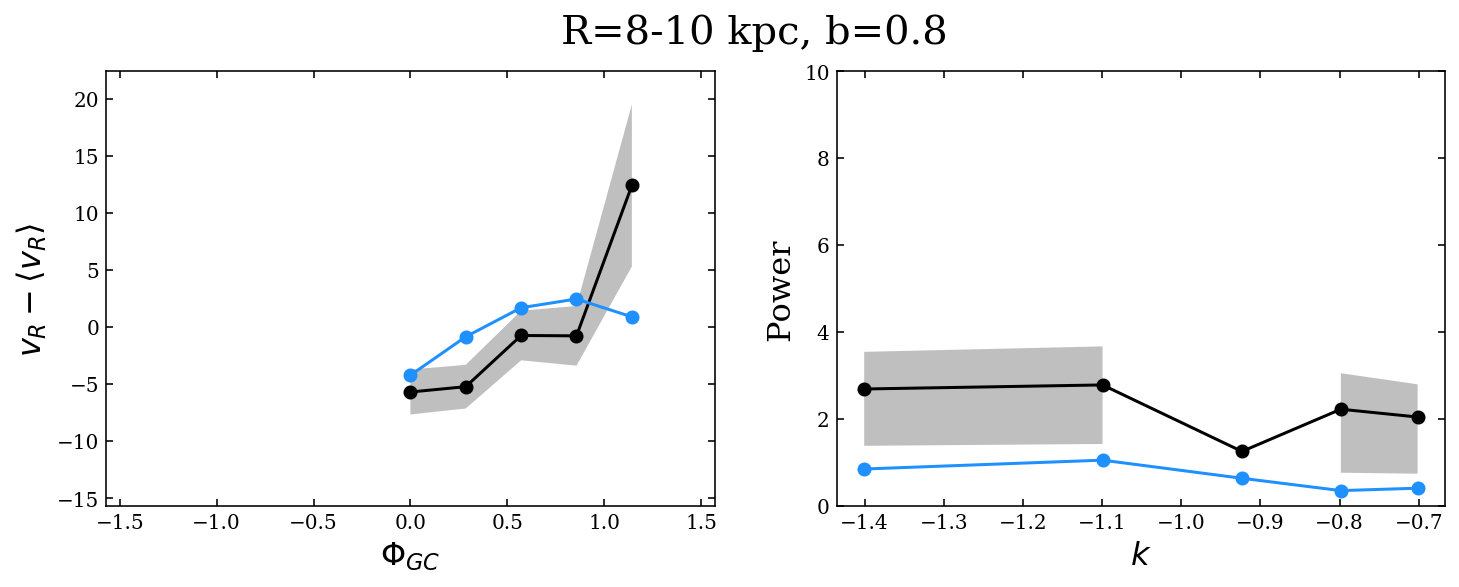

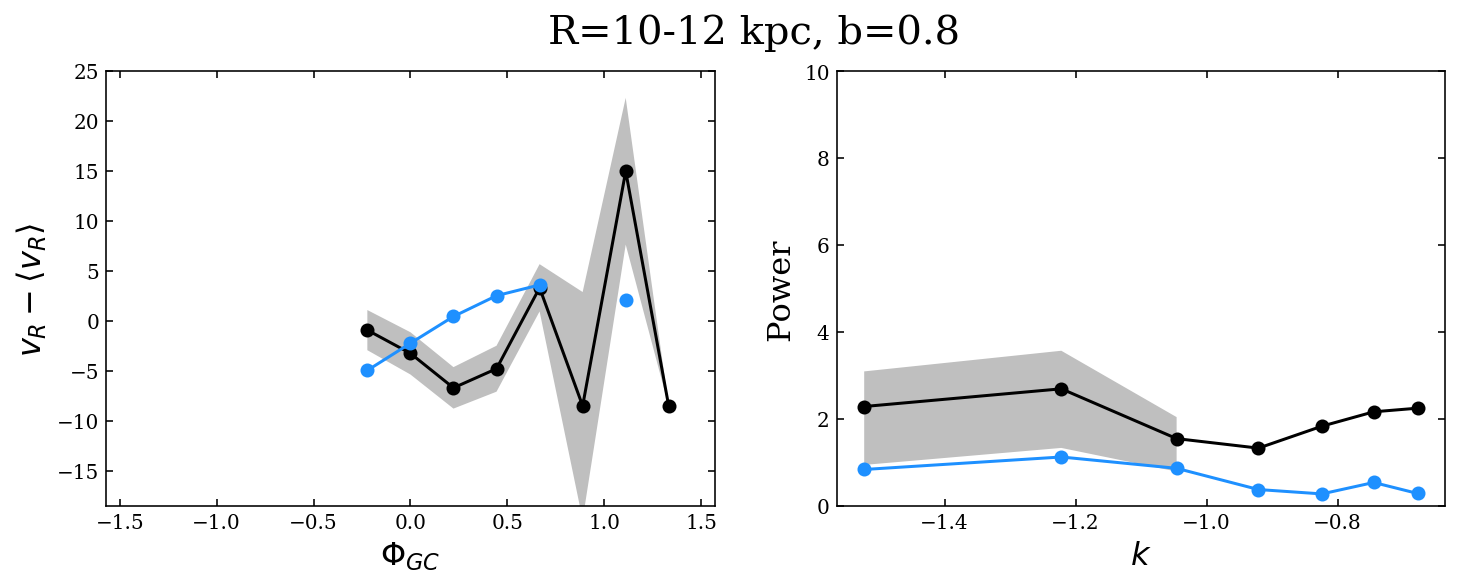

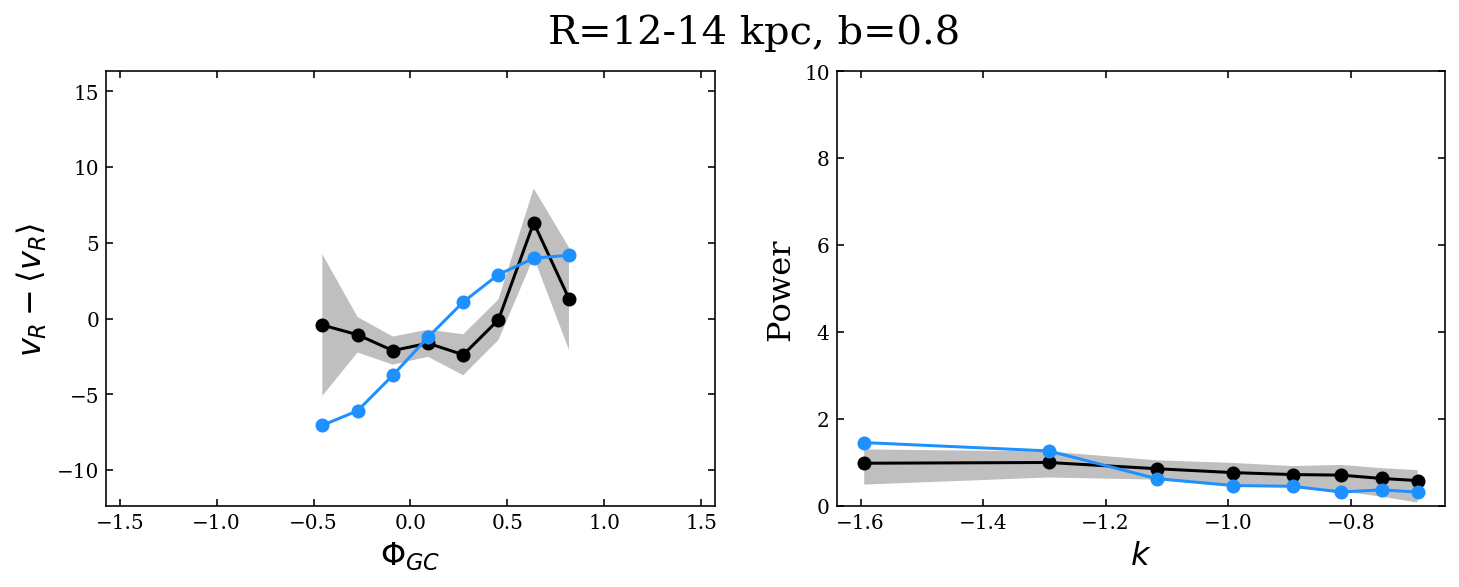

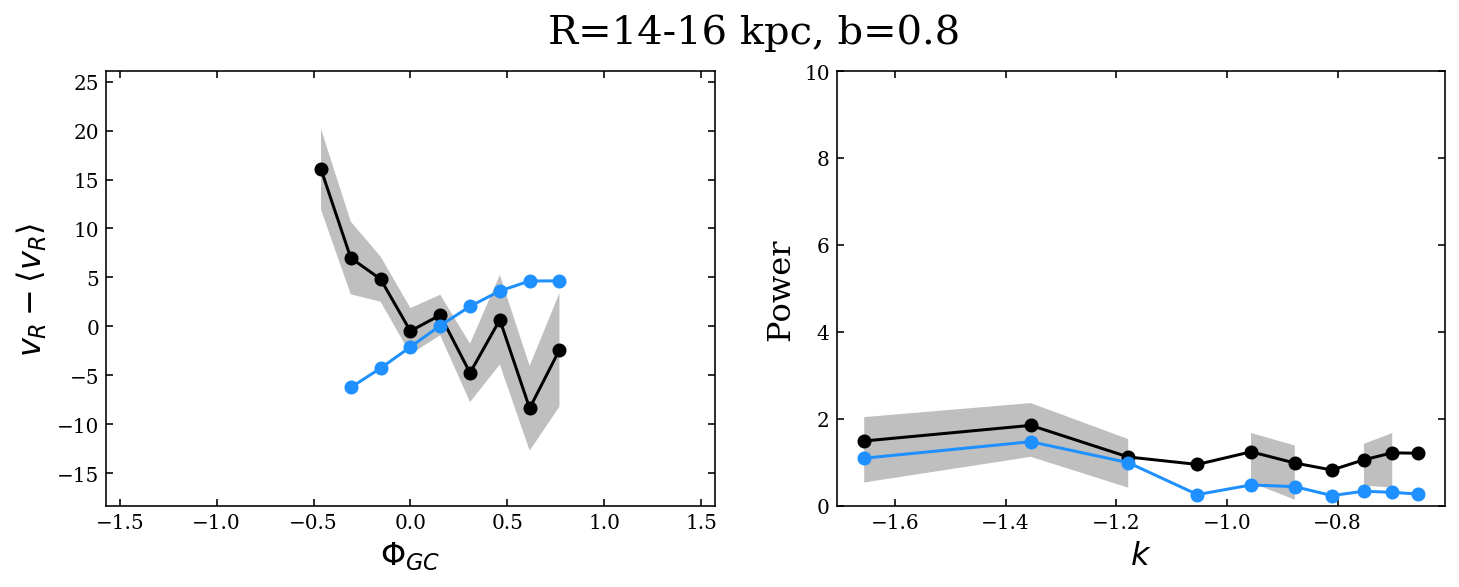



##########




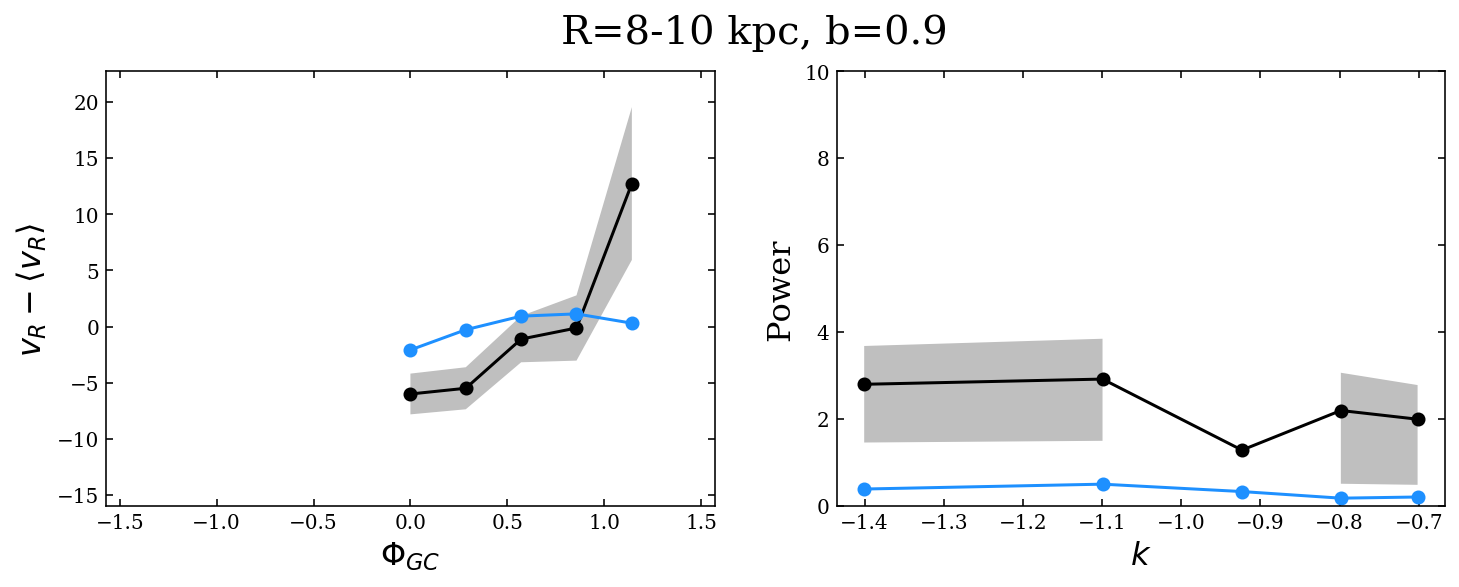

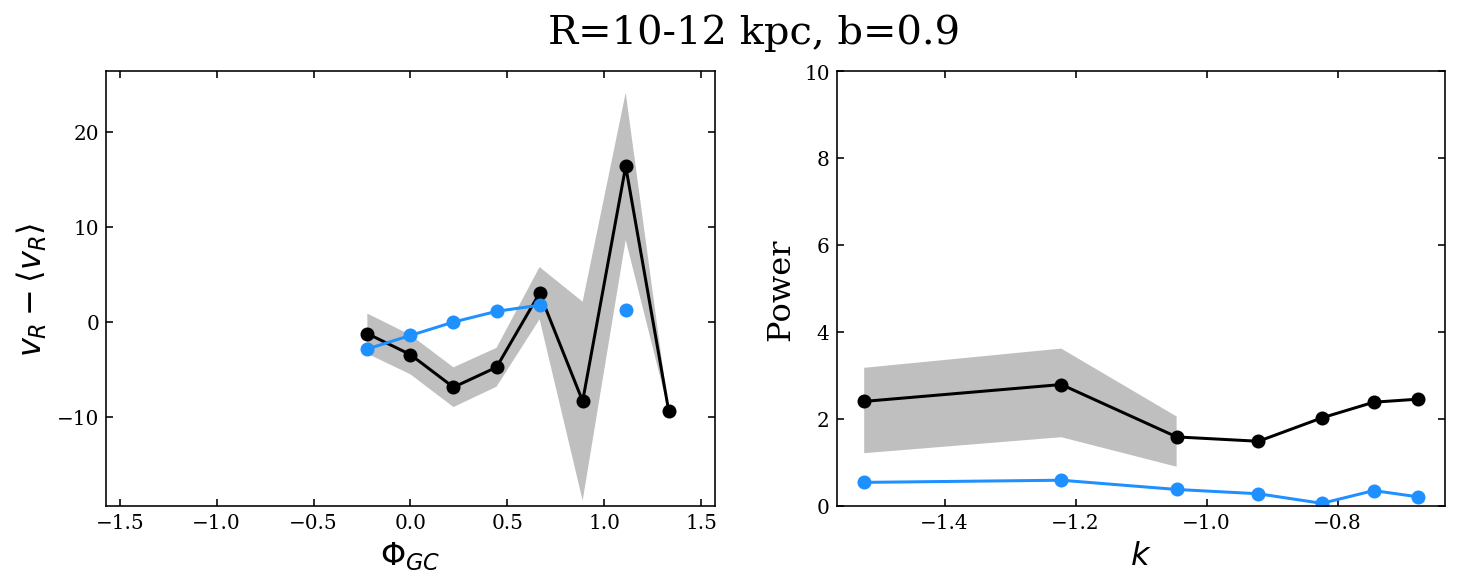

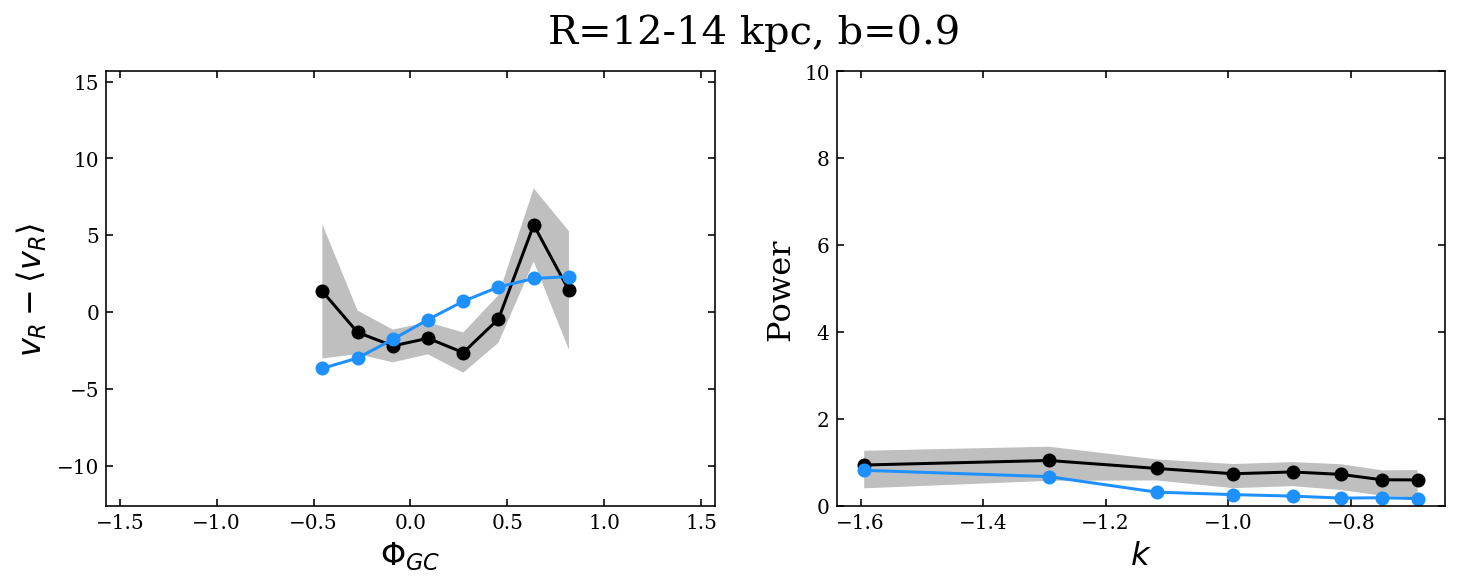

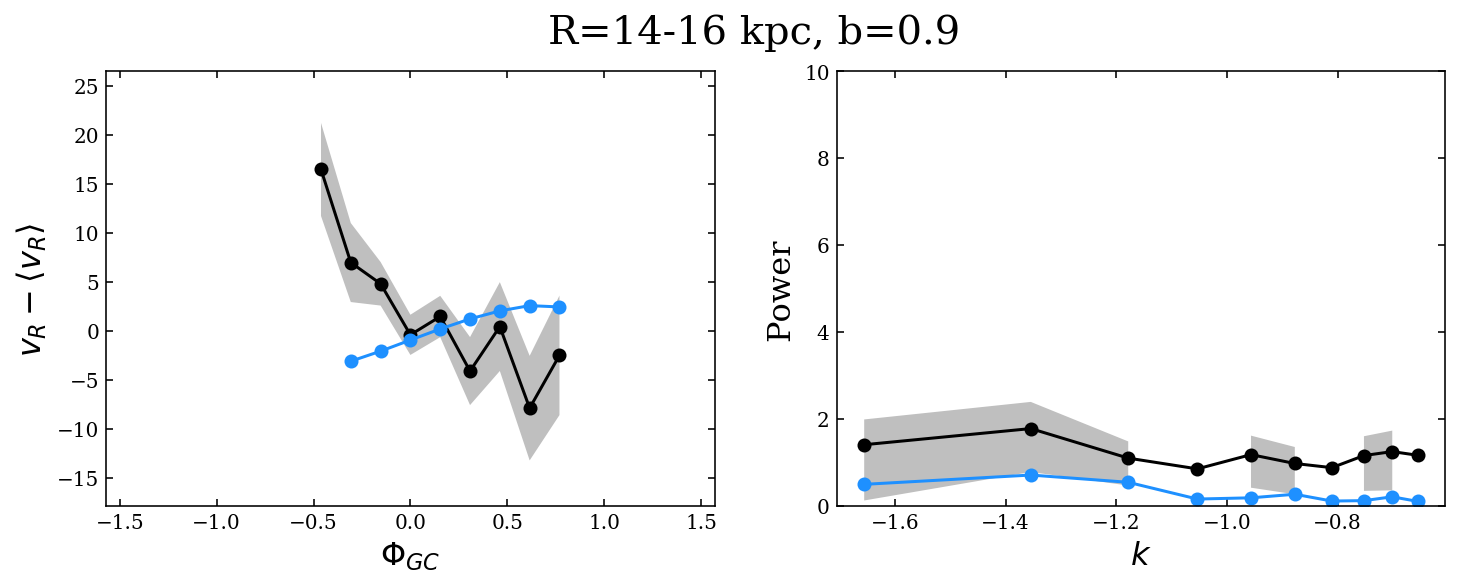



##########




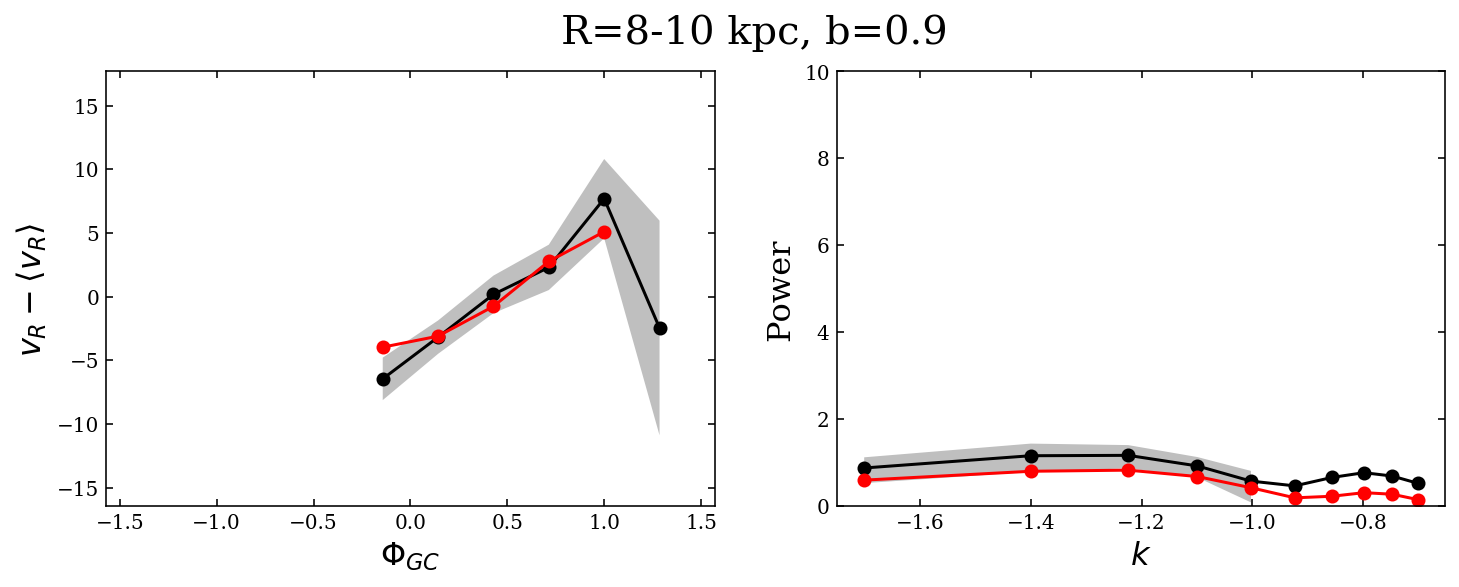

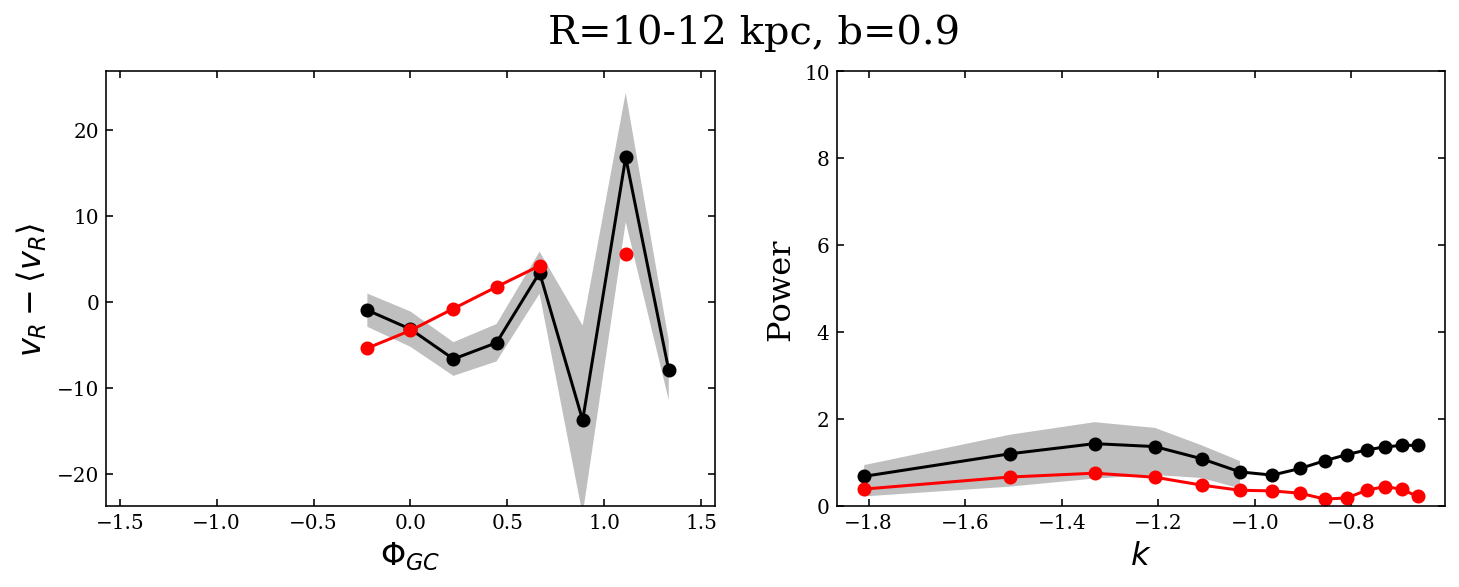

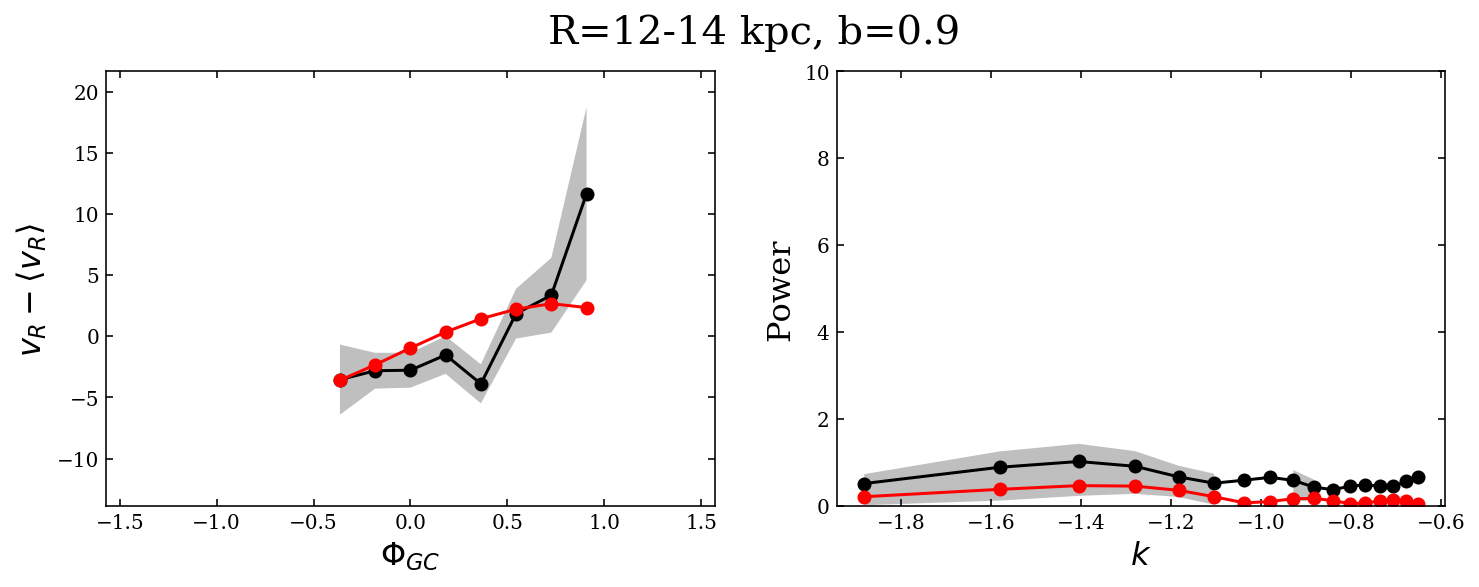

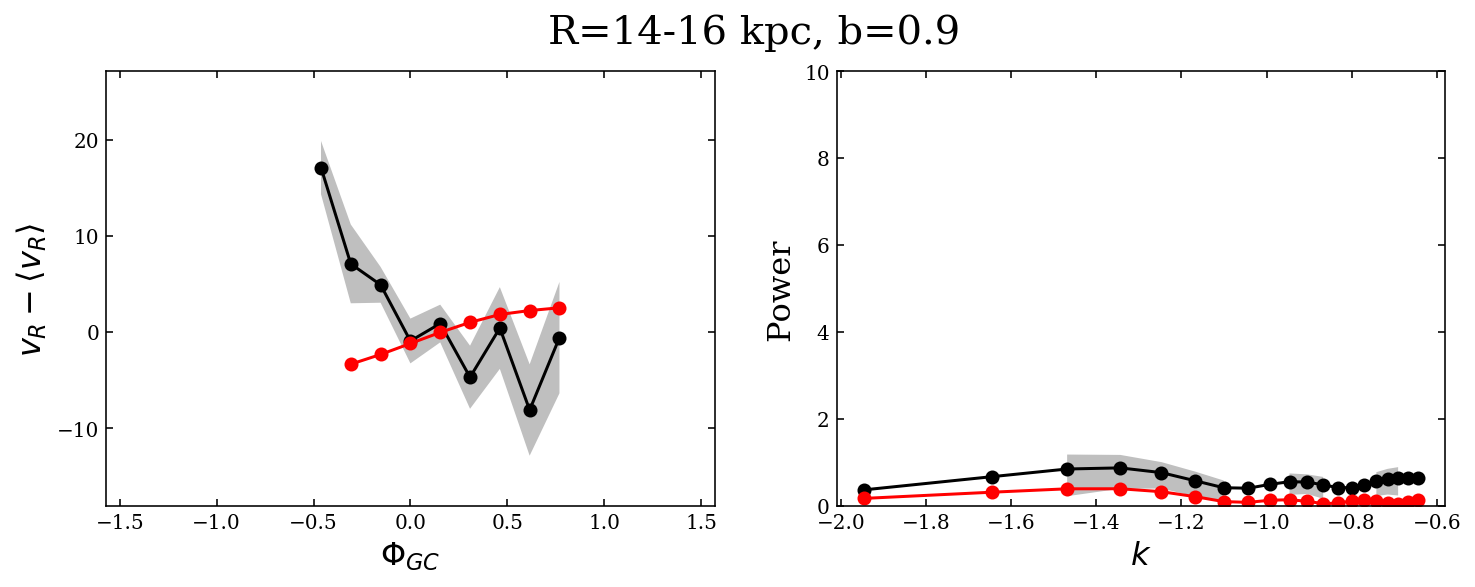



##########




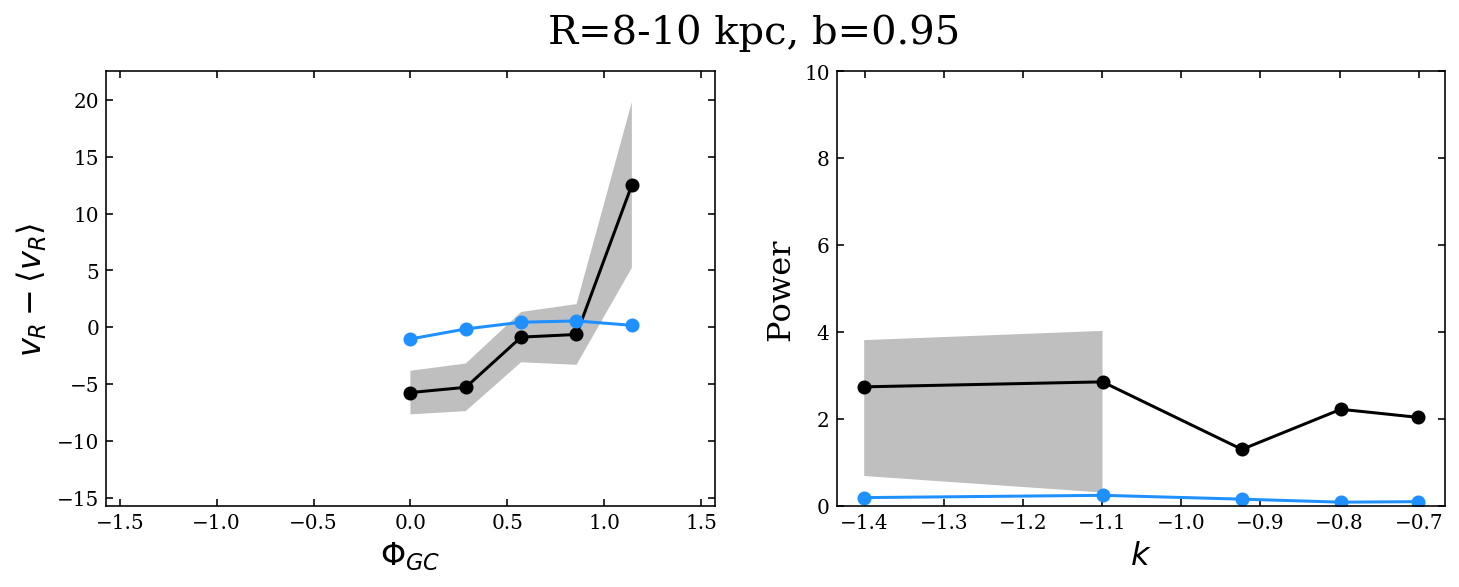

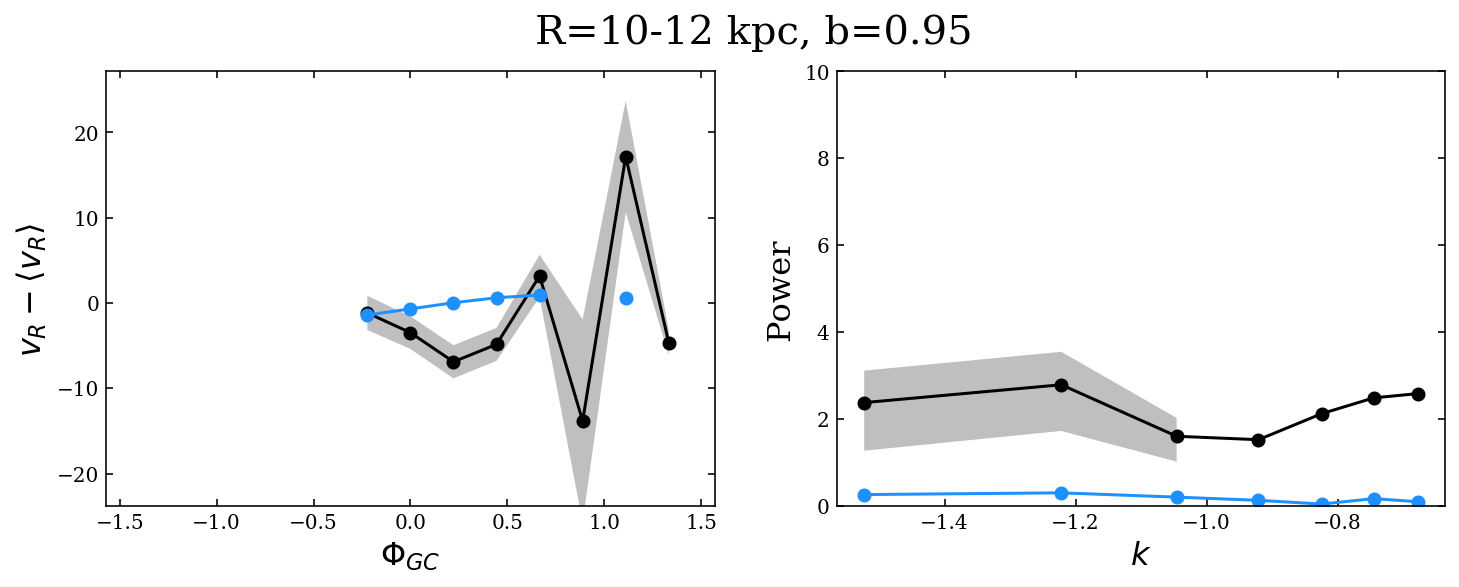

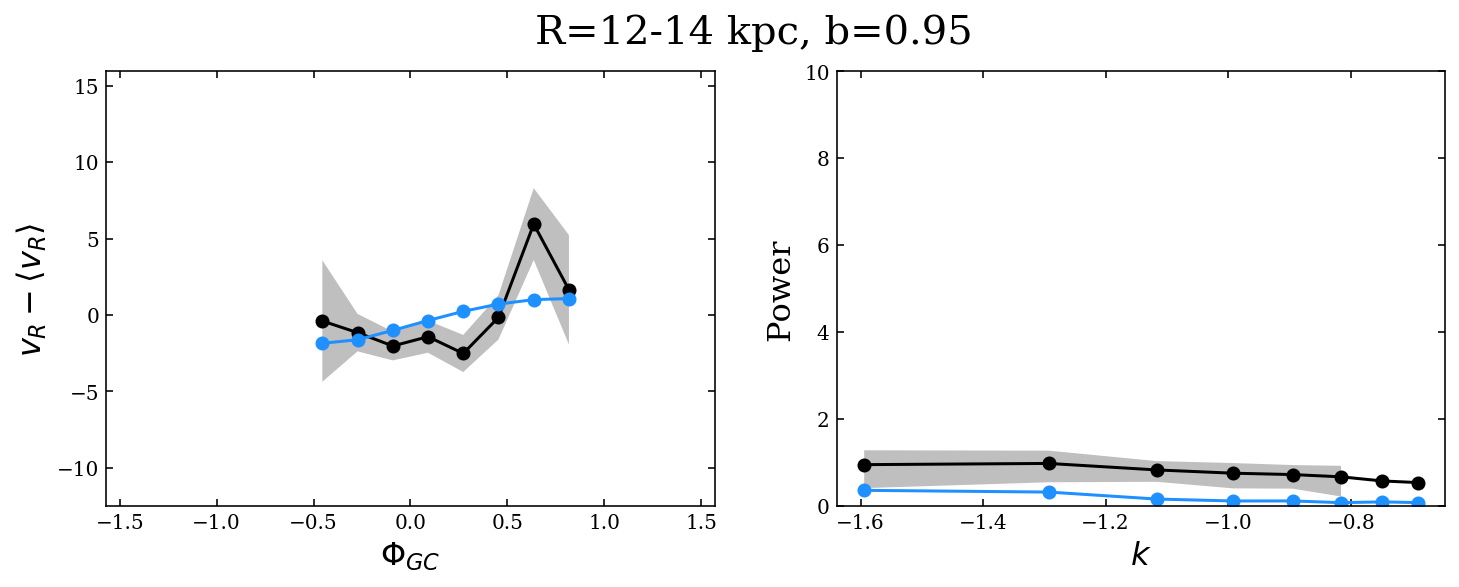

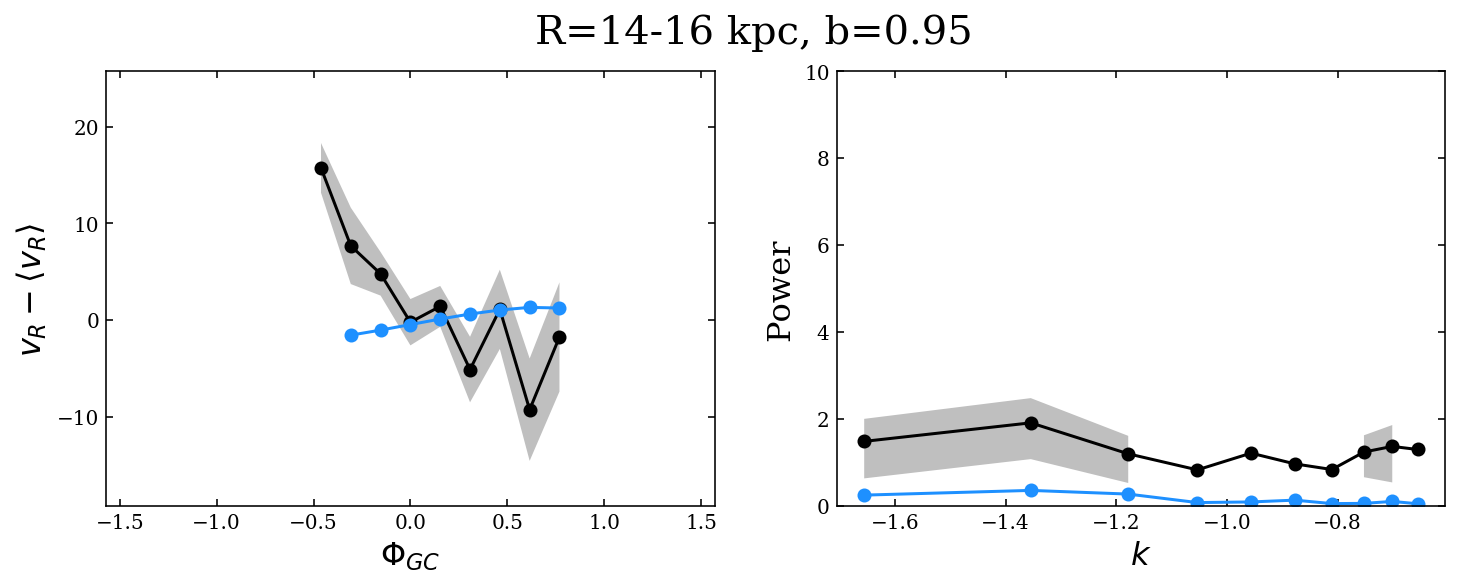



##########




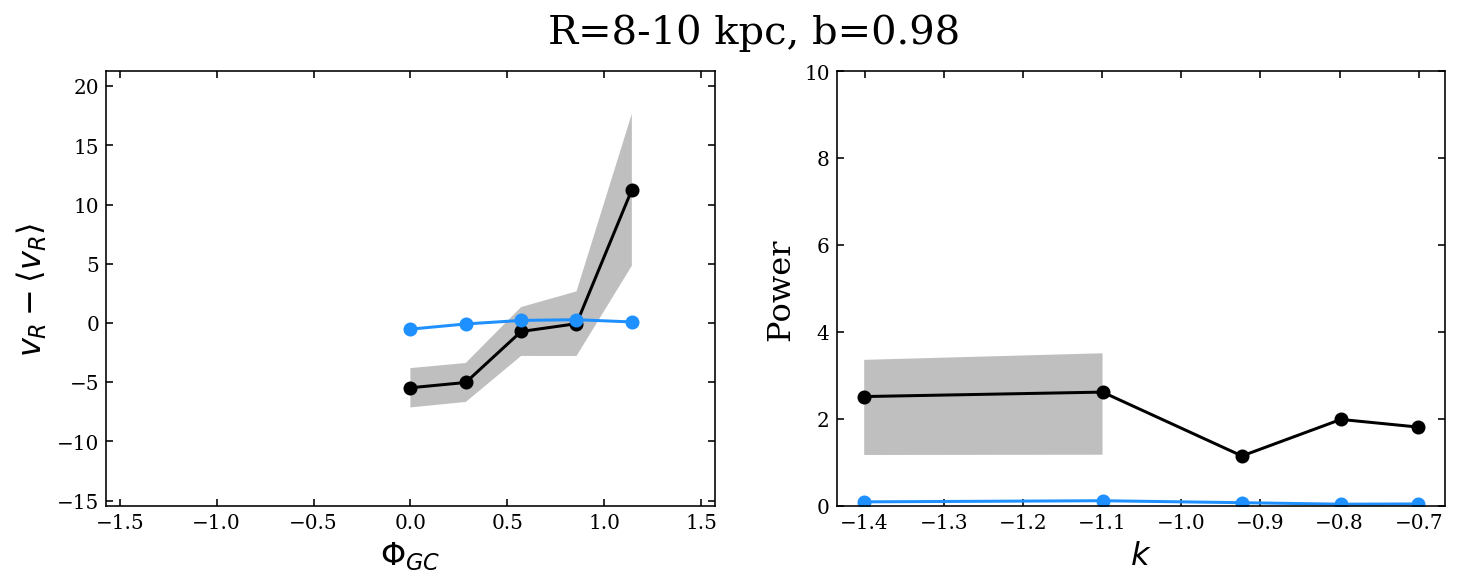

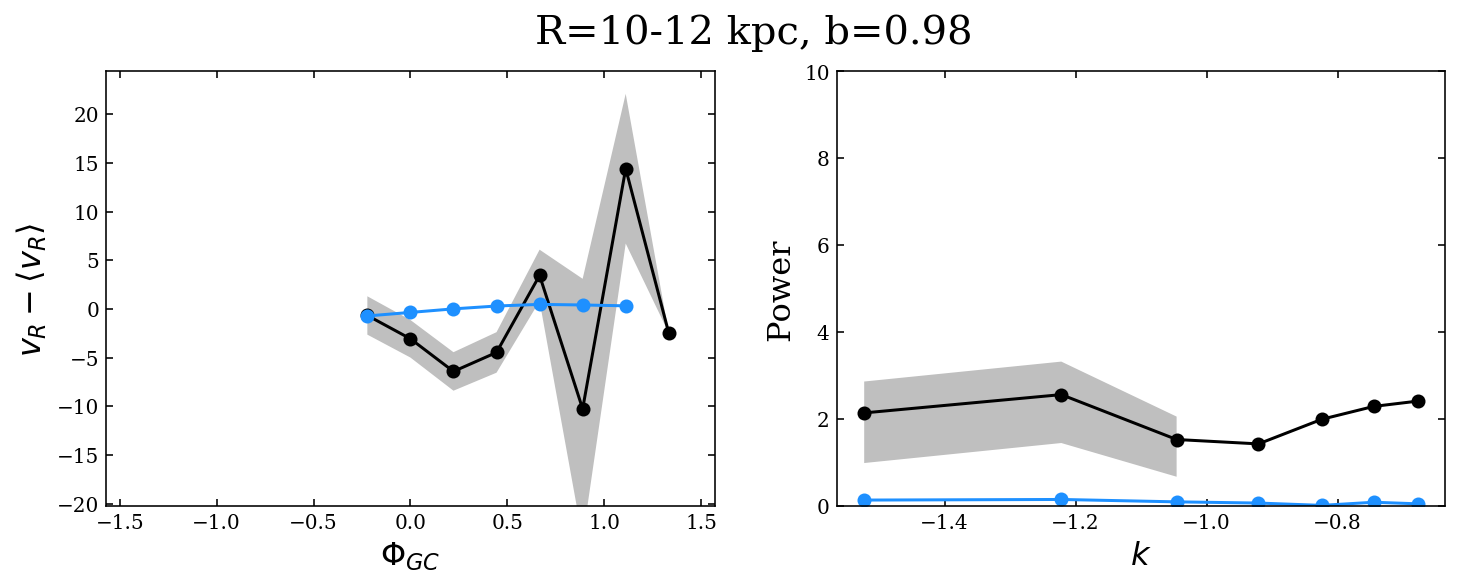

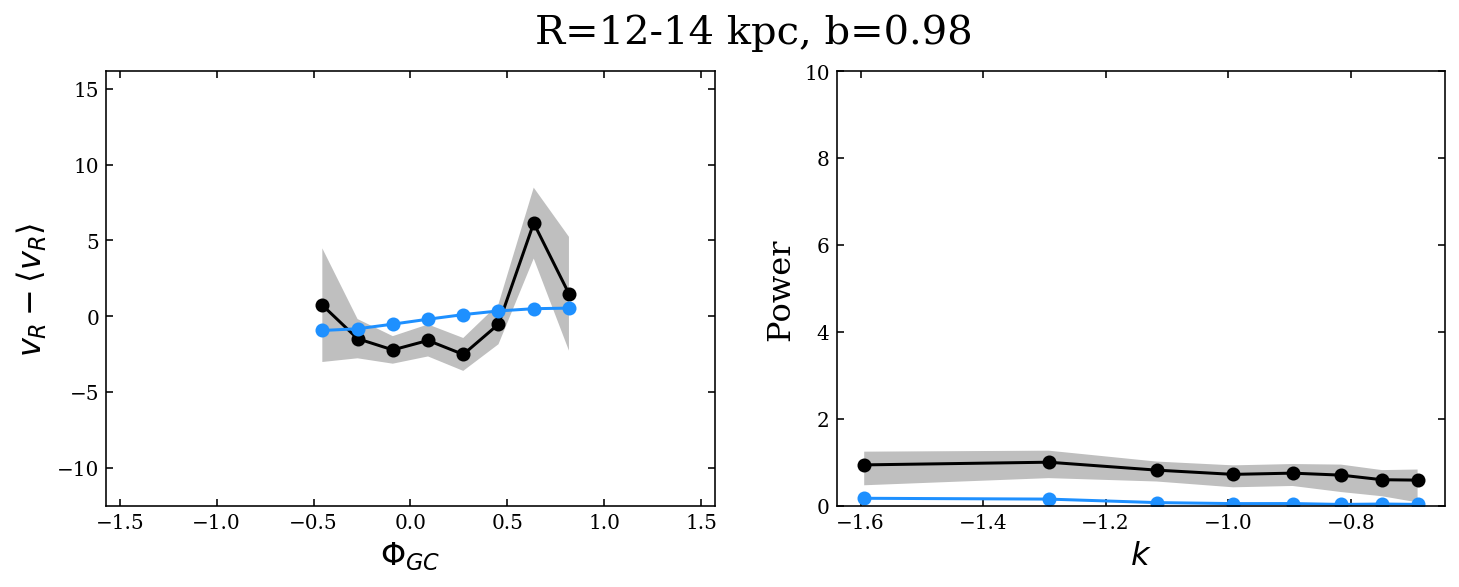

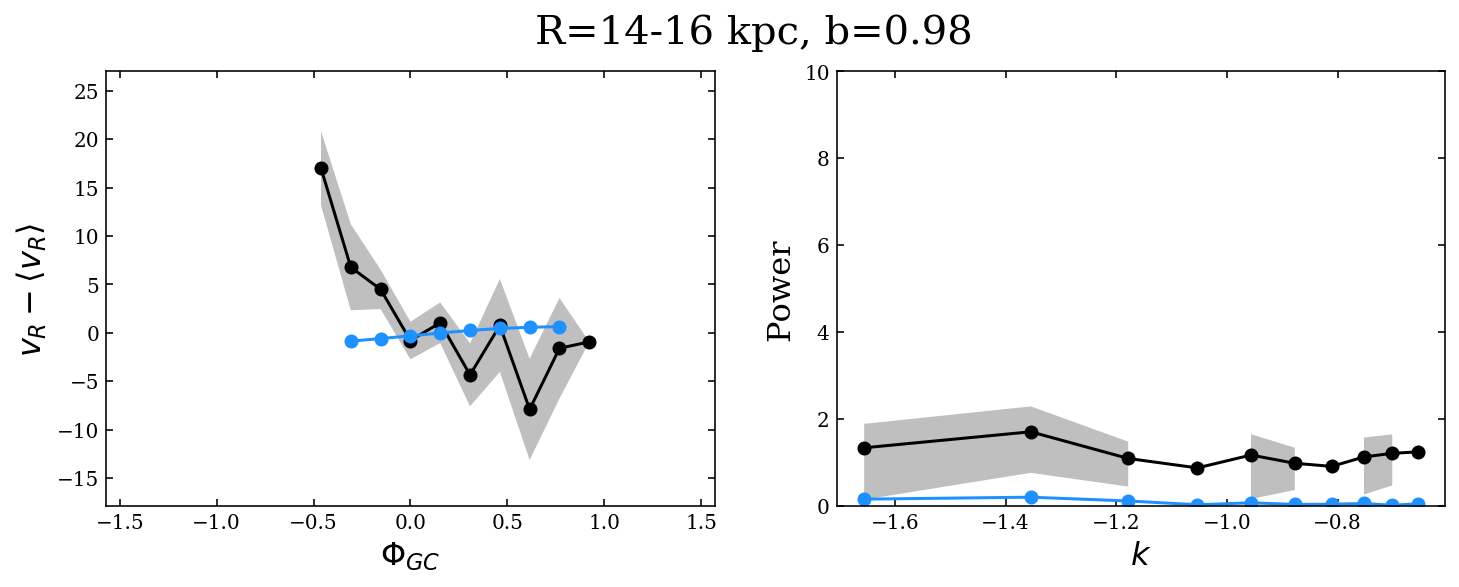



##########




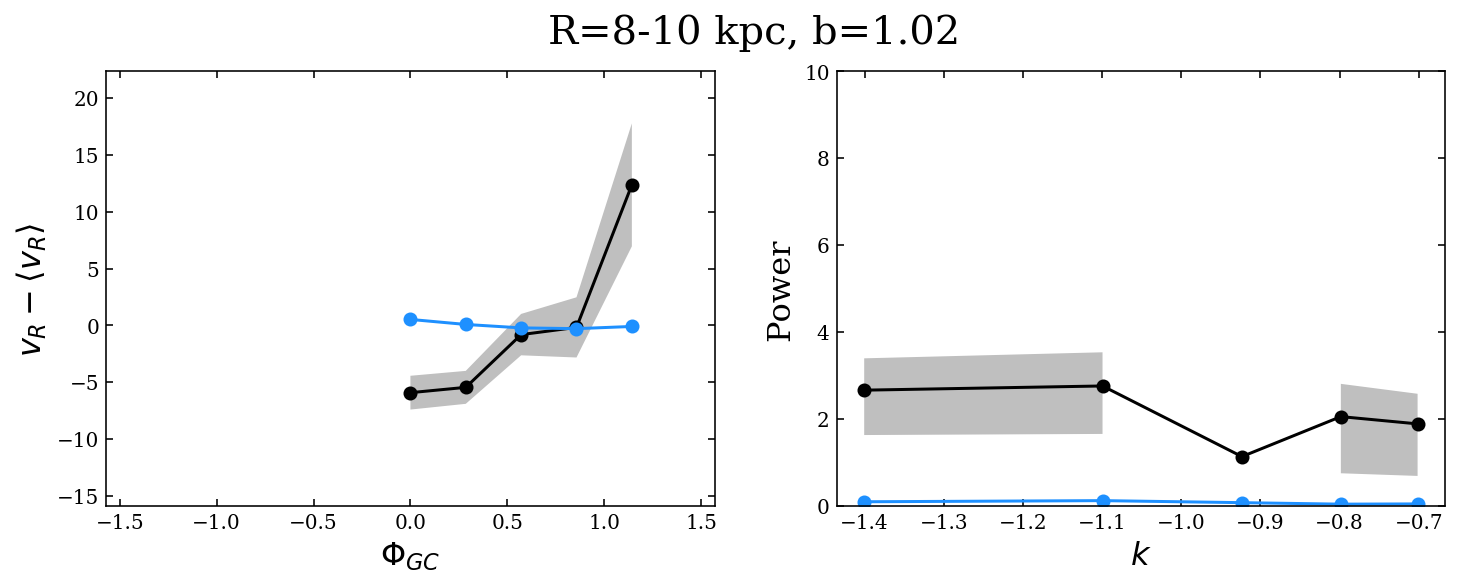

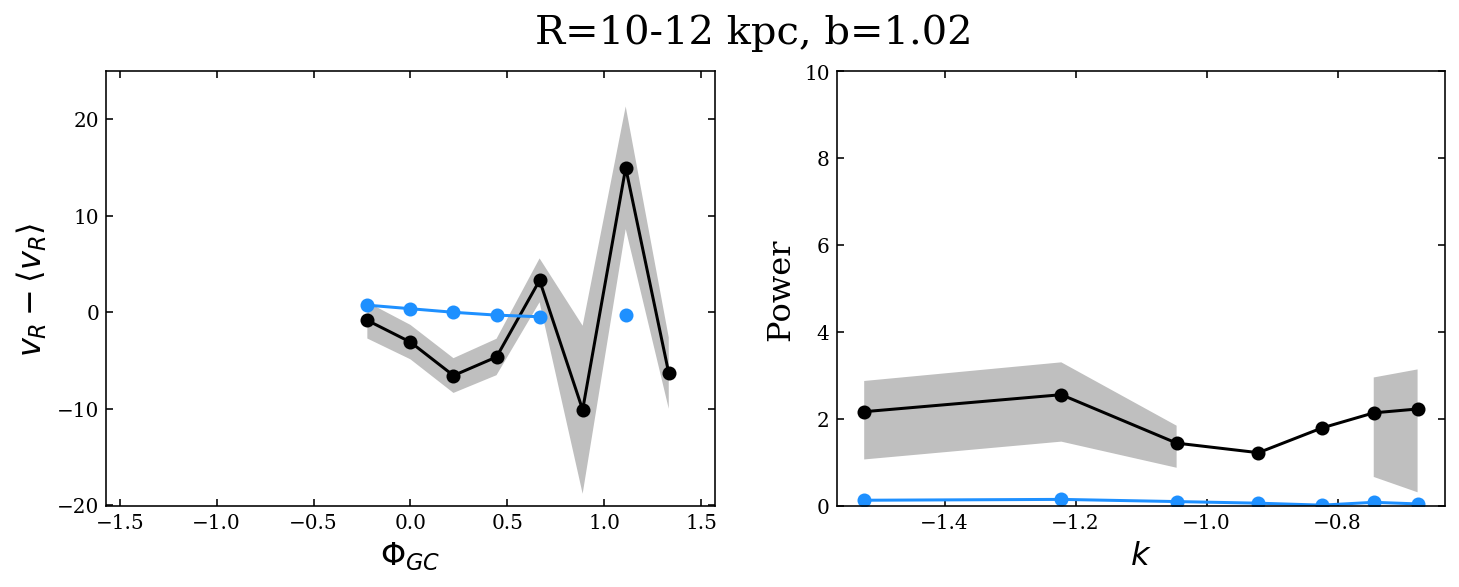

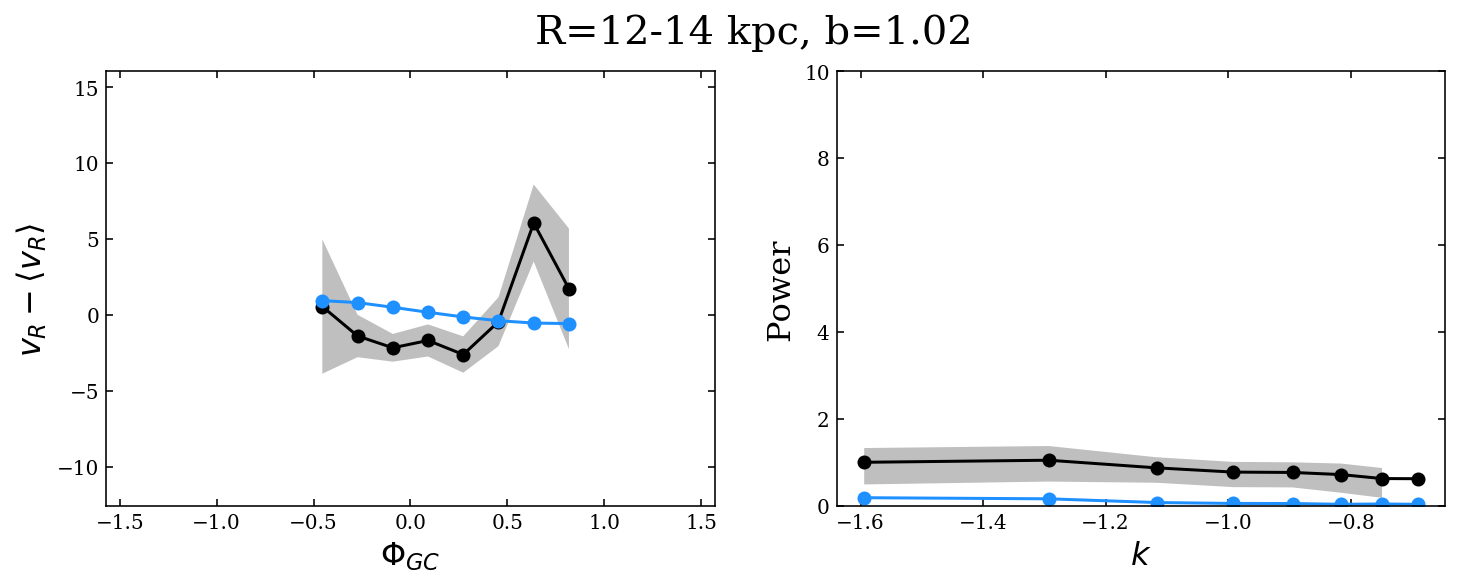

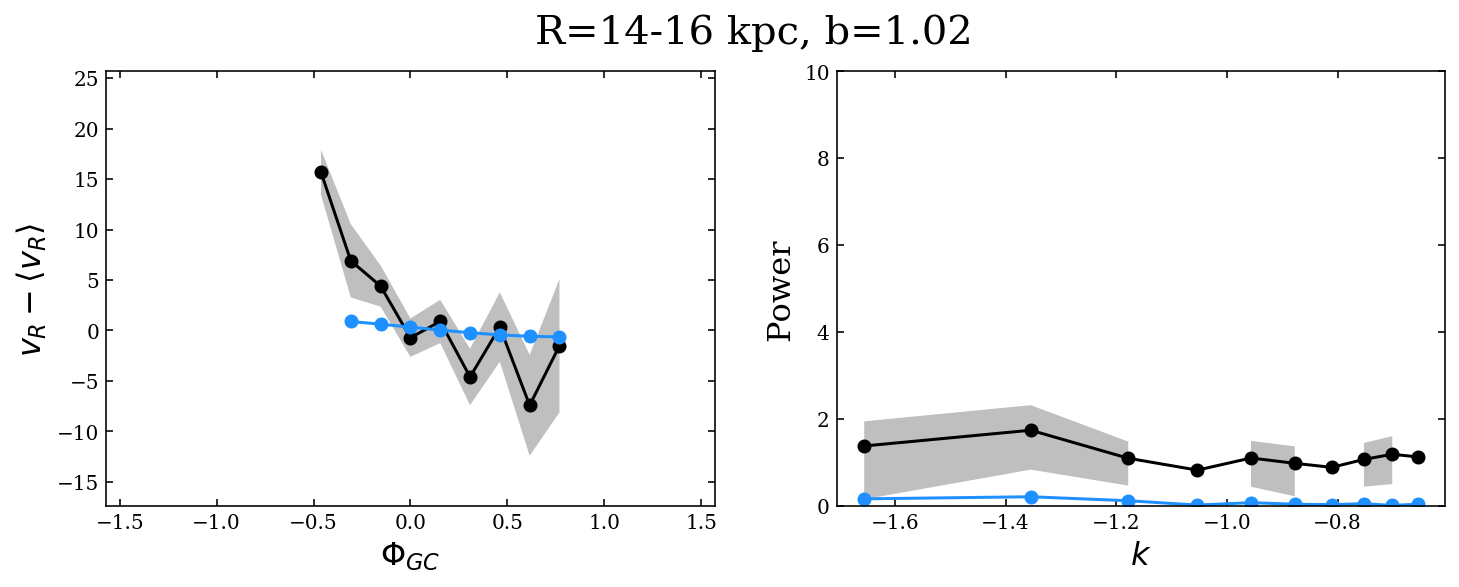



##########




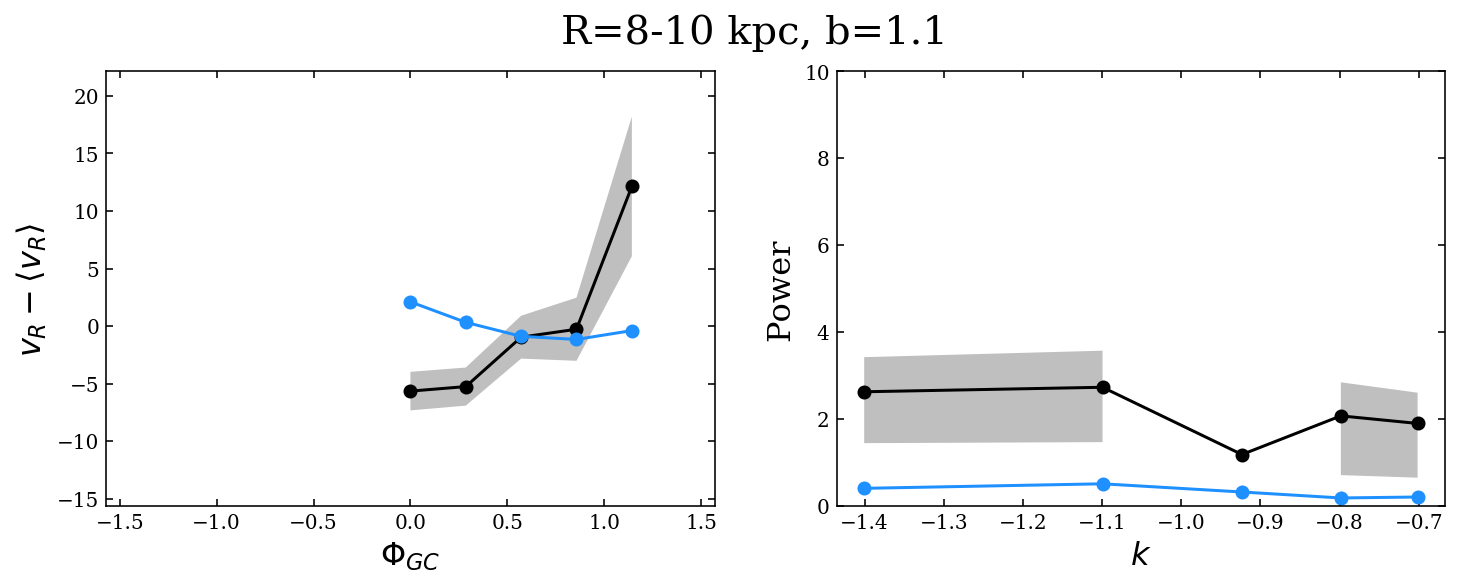

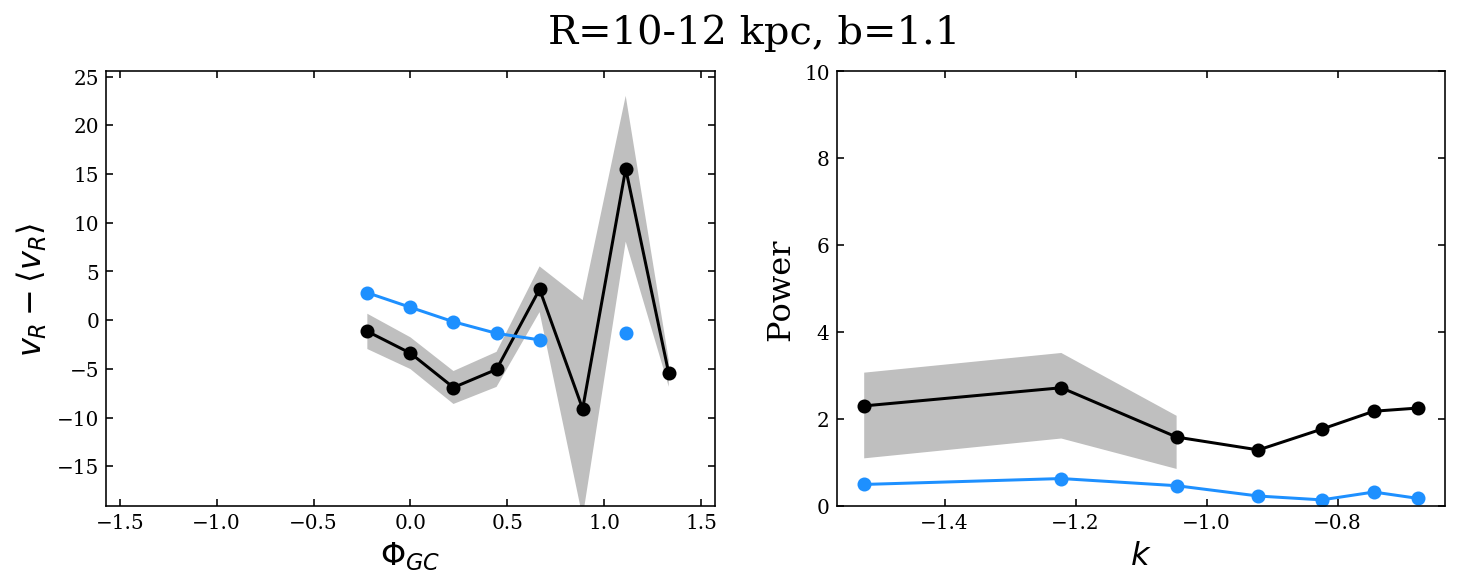

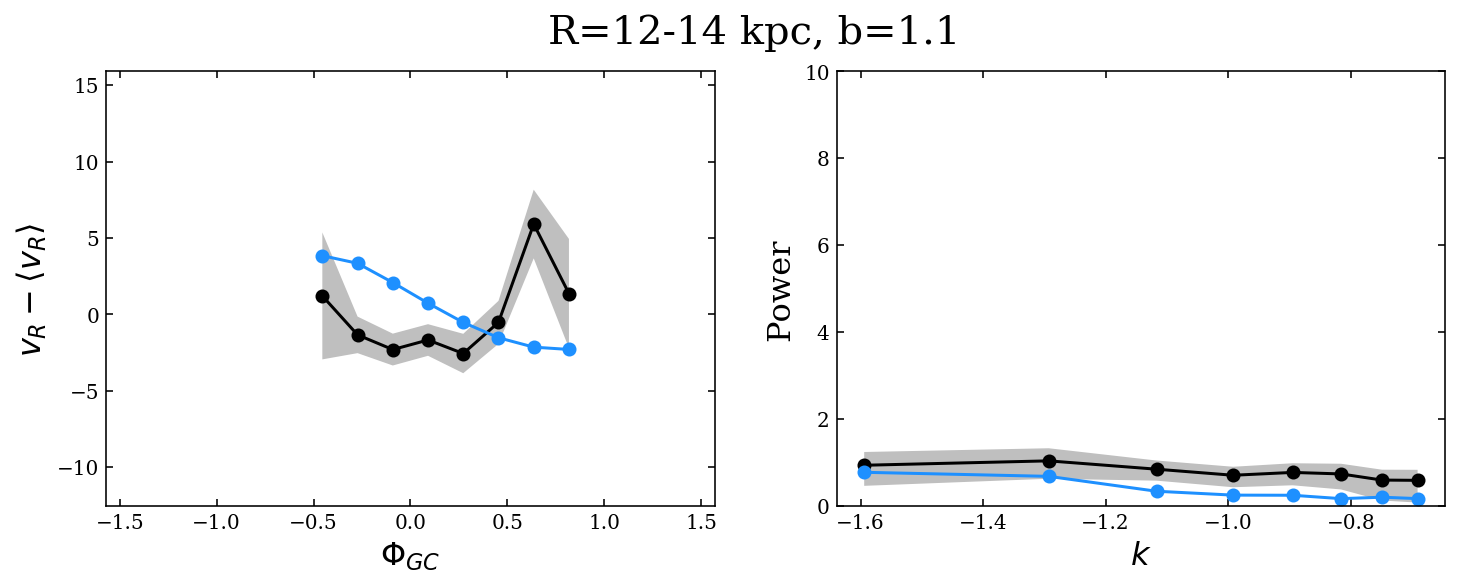

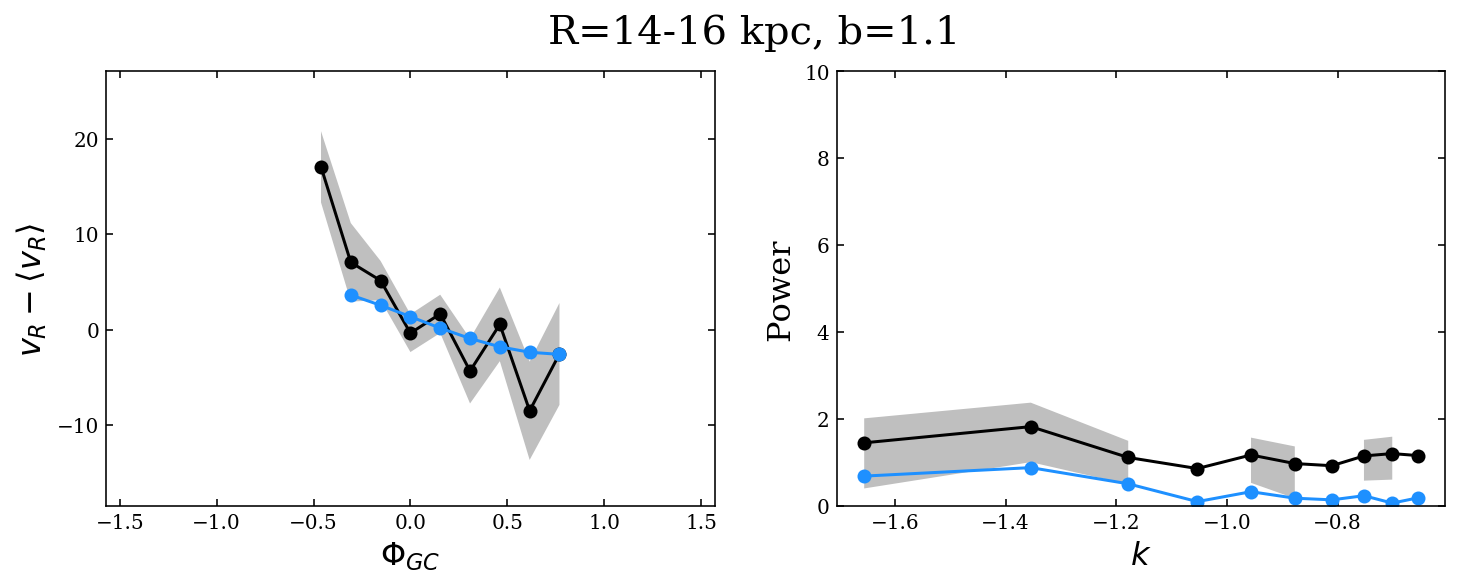



##########




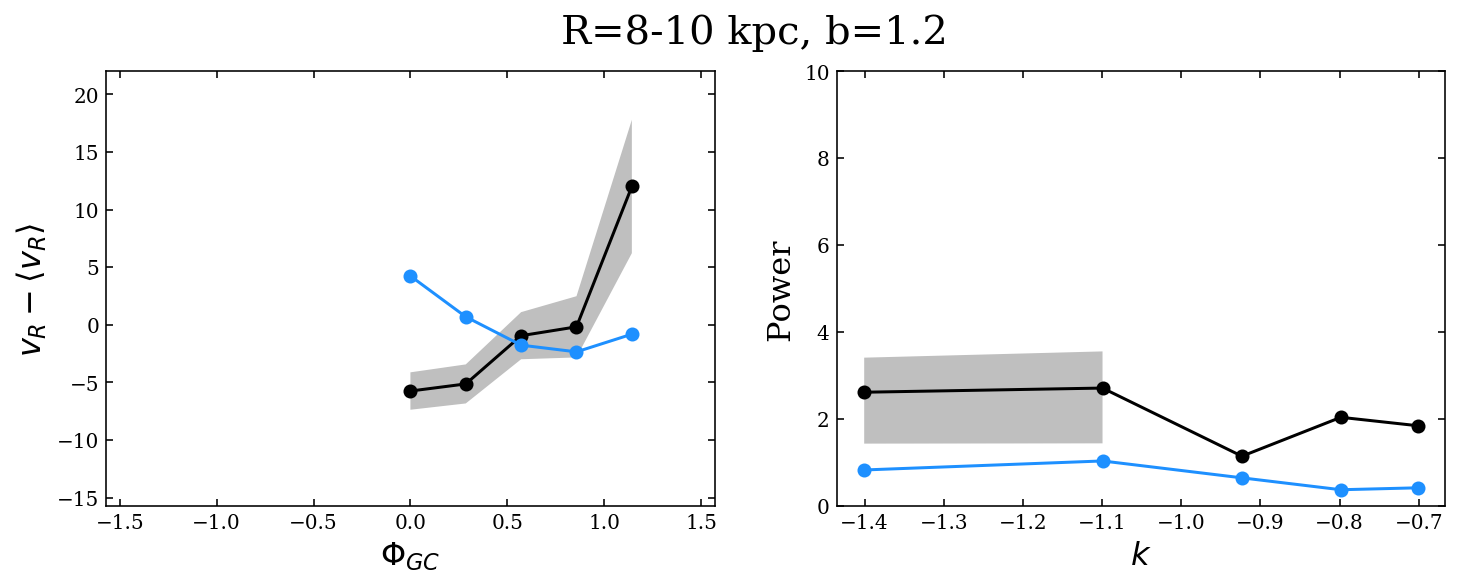

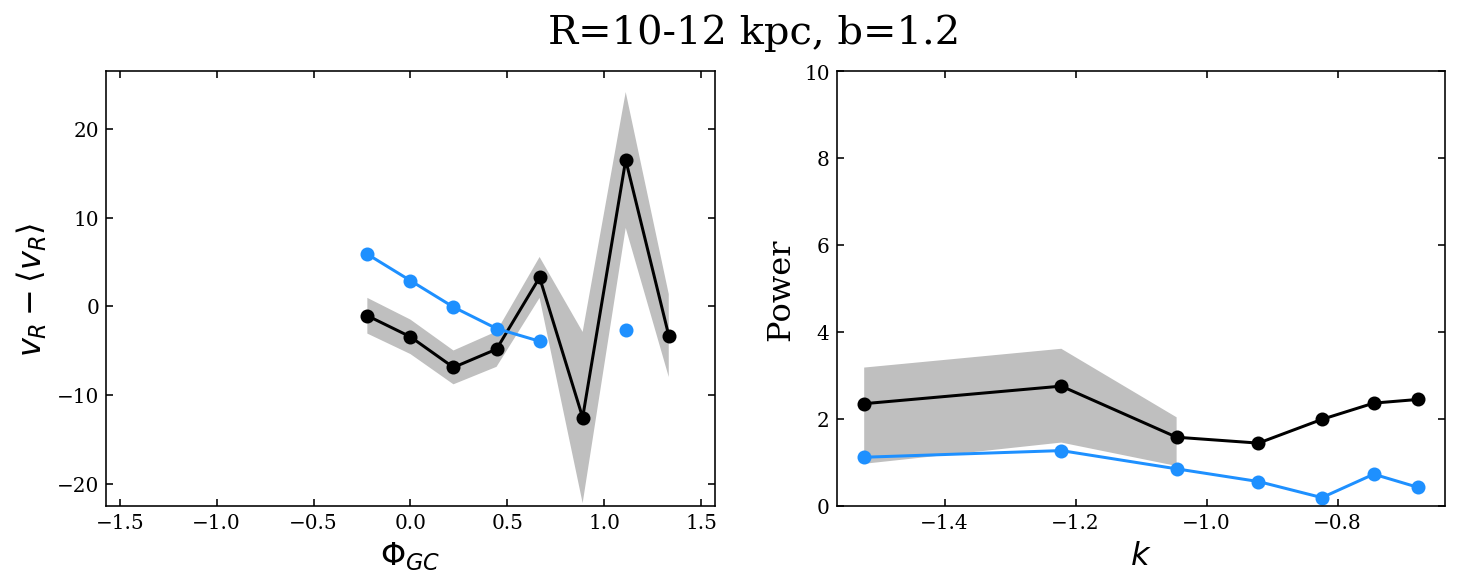

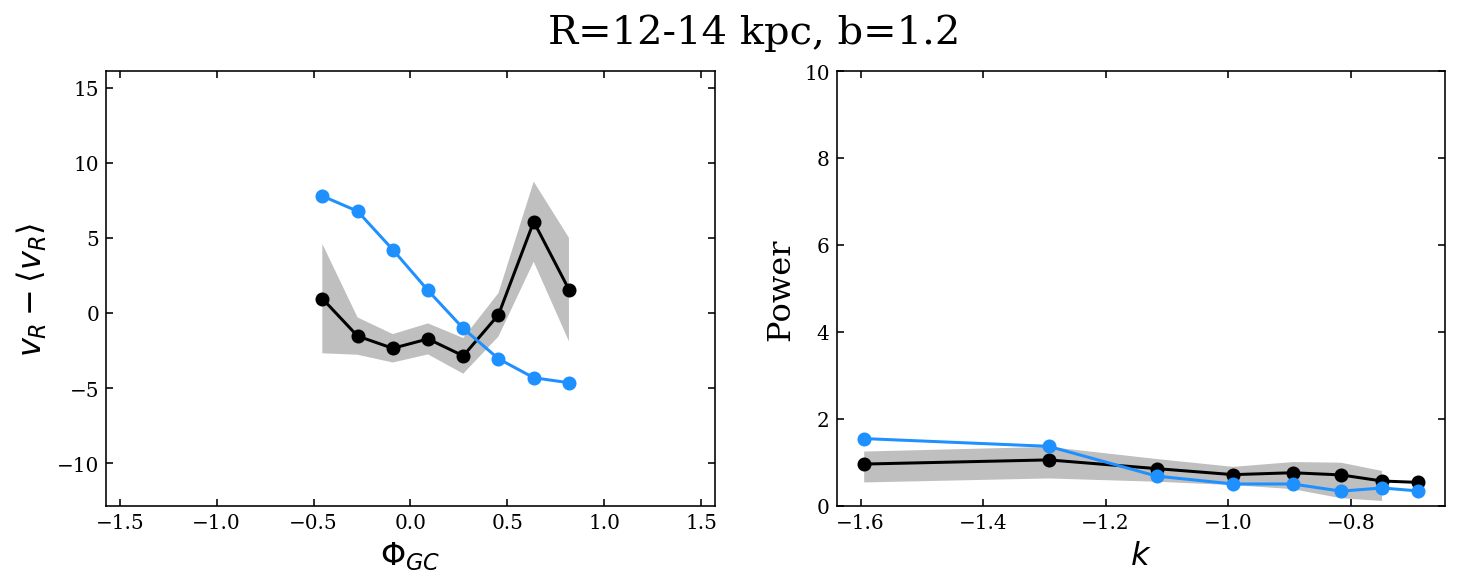

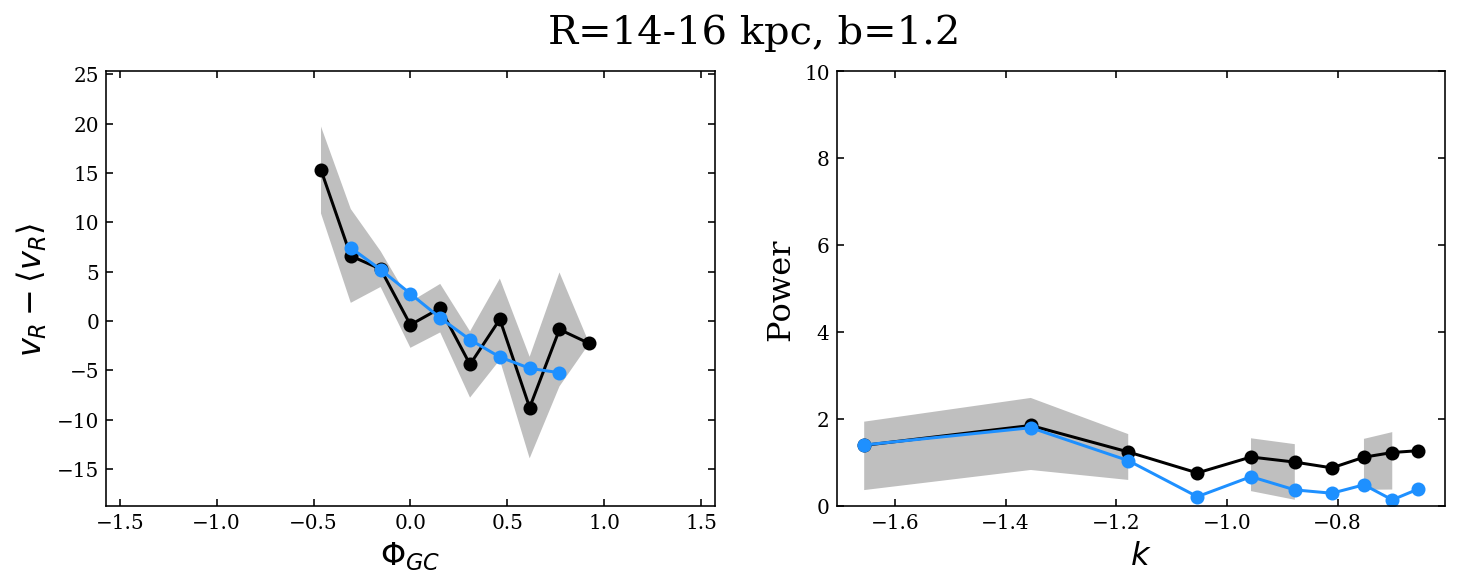



##########




In [29]:
# Now loop over each radial bin
for i in range( n_files ):
    
    sim_data = np.load(files[i])
    
    # Now loop over each radial bin
    for j in range( len(R_range) ):
        
        if R_range[j] < 8: continue
        
        # Find the simulated data just at this radius
        sim_data_R = sim_data[ np.where( sim_data[:,0] == R_range[j] )[0], : ]

        # Bootstrap over the samples
        for k in range(n_bs):

            # Take a random sub-sample of Gaia stars
            sample = np.random.randint(0,len(gc_x),len(gc_x))
            samp_gc_R = gc_R[sample]
            samp_gc_phi = gc_phi[sample]
            samp_gc_vT = gc_vR[sample]

            # Select the stars in this bin
            stars_in_bin = np.where( (samp_gc_R > (R_range[j]-R_bin_size/2) ) & 
                                     (samp_gc_R < (R_range[j]+R_bin_size/2) ) )[0]
            gcvt_in_bin = samp_gc_vT[stars_in_bin]
            gcphi_in_bin = samp_gc_phi[stars_in_bin]
            
            # Select the simulated data
            sim_vt = sim_data_R[:,4]
            sim_phi = sim_data_R[:,1]
            
            # Determine the size of the phi bins, and bin the Gaia data to match
            phi_bin_size_arc = np.diff( sim_data_R[:,1]*sim_data_R[:,0] )[0]
            phi_bin_size = np.diff( sim_data_R[:,1] )[0]
            phi_samp_bin_cents = sim_data_R[:,1]
            phi_samp_bin_edges = np.append( sim_data_R[:,1]-phi_bin_size/2, sim_data_R[-1,1]+phi_bin_size/2 ) 

            # Bin in phi
            binned_vt, _, _ = binned_statistic(gcphi_in_bin, gcvt_in_bin, 
                                               bins=phi_samp_bin_edges, 
                                               statistic='mean')

            # Make a number histogram to examine whether there is enough stars for a valid measurement
            binned_n, _, = np.histogram(gcphi_in_bin, bins=phi_samp_bin_edges)
            where_low_bin_numbers = np.where(binned_n < 10)
            
            # Exclude areas where there wasn't a valid measurement
            binned_vt[where_low_bin_numbers] = np.nan
            sim_vt[where_low_bin_numbers] = np.nan

            # Find where there was data
            where_data = np.where( np.isfinite(binned_vt) )
            where_no_data = np.where( np.isnan(binned_vt) )
            binned_vt[ where_no_data ] = np.nan
            sim_vt[ where_no_data ] = np.nan
            
            # Subtract off mean where non-zero
            mean_binned_vt = np.nanmean( binned_vt[where_data] )
            mean_sim_vt = np.nanmean( sim_vt[where_data] )
            binned_vt = binned_vt - mean_binned_vt
            sim_vt = sim_vt - mean_sim_vt

            # Get the power spectrum
            samp_ks, samp_pk = ast1501.fourier.psd(binned_vt, phi_bin_size_arc, pad=False, return_phase=False)
            sim_ks, sim_pk = ast1501.fourier.psd(sim_vt, phi_bin_size_arc, pad=False, return_phase=False)

            if k == 0:
                bs_phi_samp = np.zeros((n_bs, len(phi_samp_bin_cents)))
                bs_vT_samp = np.zeros((n_bs, len(binned_vt)))
                bs_k_vT_samp = np.zeros((n_bs, len(samp_ks)))
                bs_pk_vT_samp = np.zeros((n_bs, len(samp_pk)))
                
                bs_phi_sim = np.zeros((n_bs, len(sim_phi)))
                bs_vT_sim = np.zeros((n_bs, len(sim_vt)))
                bs_k_vT_sim = np.zeros((n_bs, len(sim_ks)))
                bs_pk_vT_sim = np.zeros((n_bs, len(sim_pk)))
            ##fi
            
            bs_phi_samp[k] = phi_samp_bin_cents
            bs_vT_samp[k] = binned_vt
            bs_k_vT_samp[k] = samp_ks
            bs_pk_vT_samp[k] = samp_pk
            
            bs_phi_sim[k] = sim_phi
            bs_vT_sim[k] = sim_vt
            bs_k_vT_sim[k] = sim_ks
            bs_pk_vT_sim[k] = sim_pk

        # Take the average and standard deviation of the azimuthal profile
        bs_avg_vT_samp = np.nanmean(bs_vT_samp, axis=0)
        bs_std_vT_samp = np.nanstd(bs_vT_samp, axis=0)
        bs_avg_vT_sim = np.nanmean(bs_vT_sim, axis=0)
        bs_std_vT_sim = np.nanstd(bs_vT_sim, axis=0)

        # Take the average and standard deviation of the power spectrum
        bs_avg_pk_vT_samp = np.nanmean(bs_pk_vT_samp, axis=0)
        bs_std_pk_vT_samp = np.nanstd(bs_pk_vT_samp, axis=0)
        bs_avg_pk_vT_sim = np.nanmean(bs_pk_vT_sim, axis=0)
        bs_std_pk_vT_sim = np.nanstd(bs_pk_vT_sim, axis=0)

        # pdb.set_trace()
        
        use_color = 'DodgerBlue'
        if i == 2:
            use_color = 'Red'
        ##fi
        
        # Plot
        fig = plt.figure( figsize=(12,4) )
        ax1, ax2 = fig.subplots(nrows=1, ncols=2)

        ax1.plot(bs_phi_samp[0], bs_avg_vT_samp, color='Black', marker='o')
        ax1.fill_between(bs_phi_samp[0], 
                         bs_avg_vT_samp+bs_std_vT_samp, 
                         bs_avg_vT_samp-bs_std_vT_samp, 
                         alpha=0.5, facecolor='Grey' )
        ax1.plot(bs_phi_sim[0], bs_avg_vT_sim, color=use_color, marker='o')
        
        ax1.set_xlabel(r'$\Phi_{GC}$', fontsize=16)
        ax1.set_ylabel(r'$v_{R}- \langle {v_{R}} \rangle$', fontsize=16)
        ax1.set_xlim(-np.pi/2,np.pi/2)
        ax1.set_ylim( np.nanmin(bs_avg_vT_samp)-10, np.nanmax(bs_avg_vT_samp)+10 )

        ind_ks_pos_samp = int(1+len(bs_k_vT_samp[0])/2)
        ind_ks_pos_sim = int(1+len(bs_k_vT_sim[0])/2)
        
        bs_k_vT_samp_pos = np.abs( bs_k_vT_samp[0,ind_ks_pos_samp:] ) 
        bs_k_vT_sim_pos = np.abs( bs_k_vT_sim[0,ind_ks_pos_sim:] ) 
        
        ax2.plot(np.log10(bs_k_vT_samp_pos), np.sqrt(bs_avg_pk_vT_samp[ind_ks_pos_samp:]), 
                 color='Black', marker='o')
        ax2.fill_between( np.log10(bs_k_vT_samp_pos), 
                         np.sqrt(bs_avg_pk_vT_samp[ind_ks_pos_samp:]+bs_std_pk_vT_samp[ind_ks_pos_samp:]), 
                         np.sqrt(bs_avg_pk_vT_samp[ind_ks_pos_samp:]-bs_std_pk_vT_samp[ind_ks_pos_samp:]),
                         alpha=0.5, facecolor='Grey' )
        ax2.plot(np.log10(bs_k_vT_sim_pos), np.sqrt(bs_avg_pk_vT_sim[ind_ks_pos_sim:]), 
                 color=use_color, marker='o')
        ax2.set_xlabel(r'$k$', fontsize=16)
        ax2.set_ylabel('Power', fontsize=16)
        ax2.set_ylim(0,10)

        fig.suptitle('R='+str(int(R_range[j]))+'-'+str(int(R_range[j]+R_bin_size))+' kpc, b='+str(b_values[i]), fontsize=20)

        plt.show()
        plt.close('all')
    ###j
    
    print('\n\n##########\n\n')
    
###i

## Radial Velocity

In [111]:
# First decide on the radial bins
n_R_bins = 5
R_max = 15
R_min = 5
# R_range = np.linspace(R_min, R_max, n_R_bins, endpoint=False)
R_range = np.arange(5,15,2)
# R_bin_size = (R_max-R_min)/n_R_bins
R_bin_size = 1.0
R_range_cents = R_range + (R_bin_size/2)

# Make a galactic azimuth angle
gc_az = np.arctan2( -gc_x, -gc_y ) * 180 /  np.pi - 90

n_az_bins = 18
az_range = np.linspace(-90, 90, n_az_bins, endpoint=False)
az_bin_size = 180/n_az_bins
az_range_cents = az_range + (az_bin_size/2)

n_bs = 100

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)



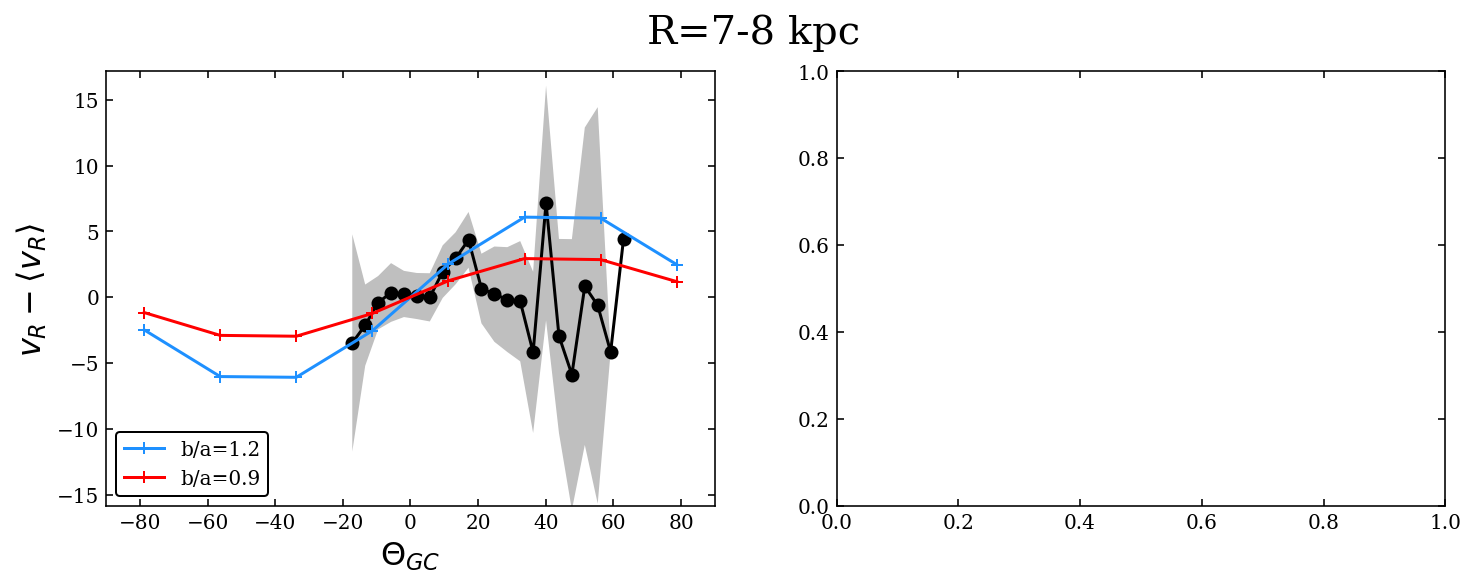

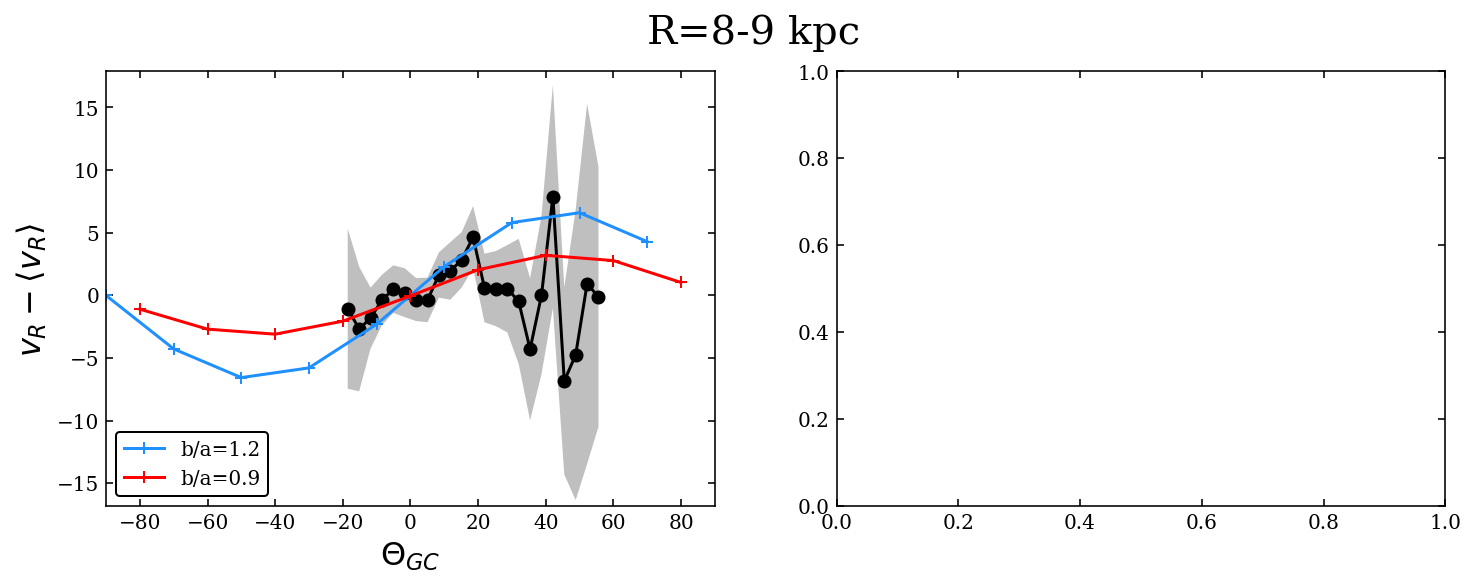

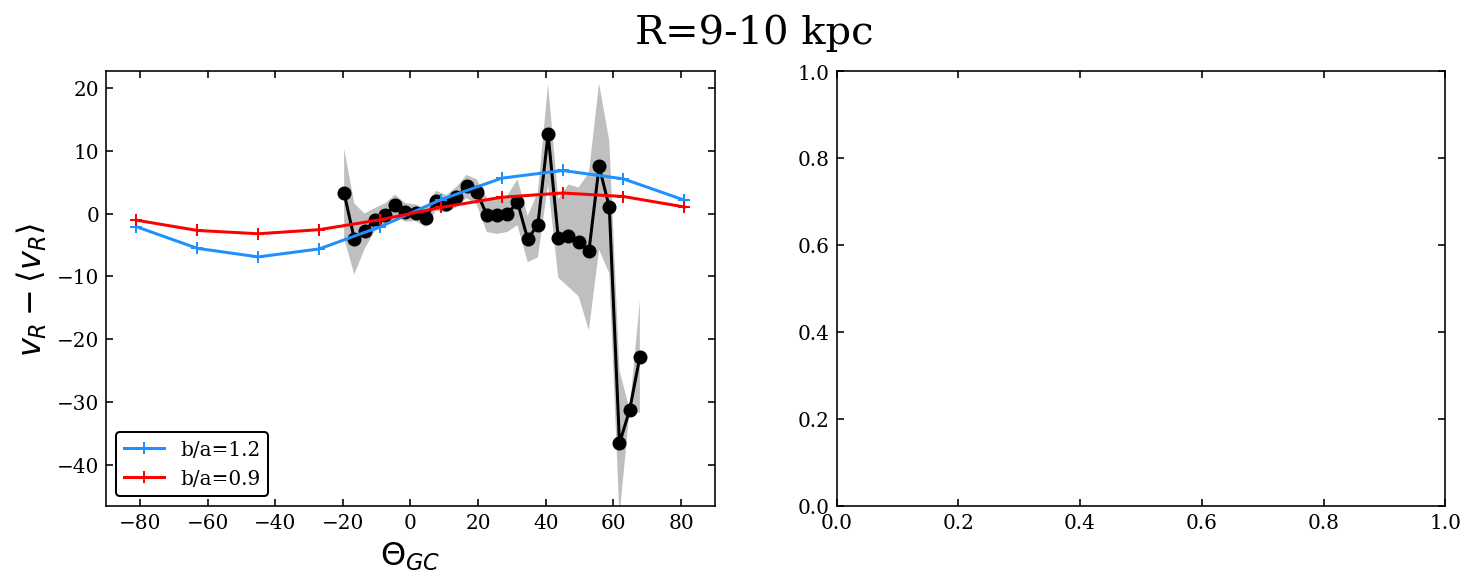

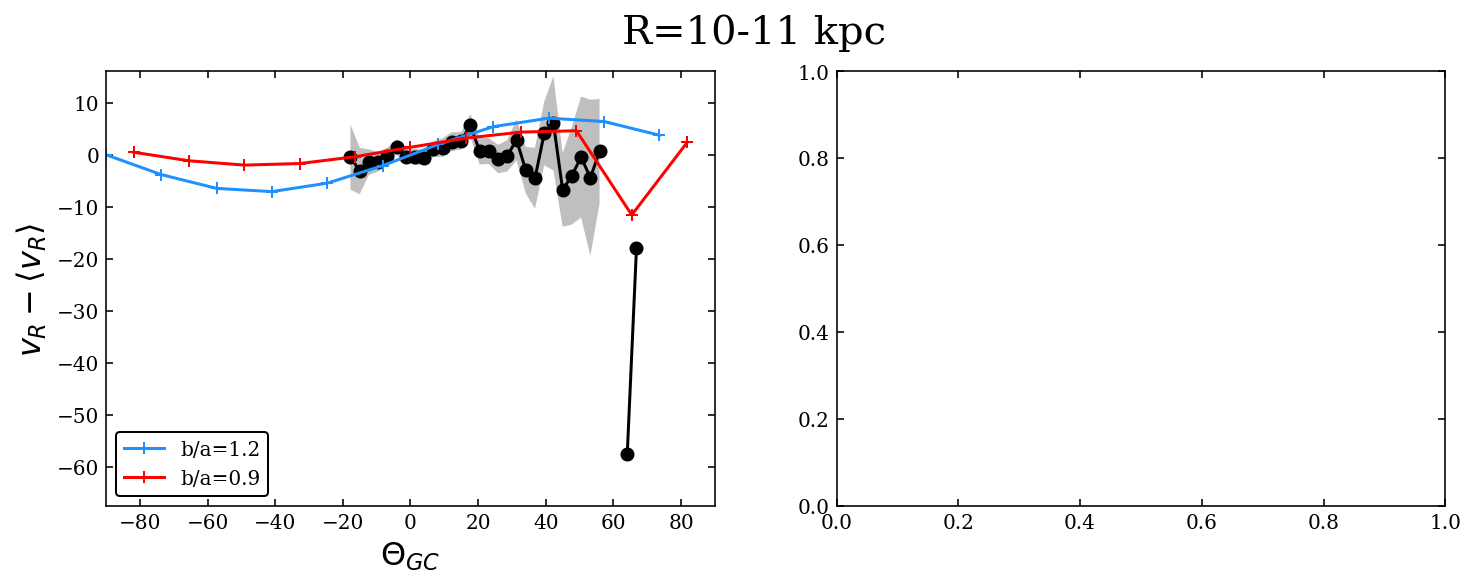

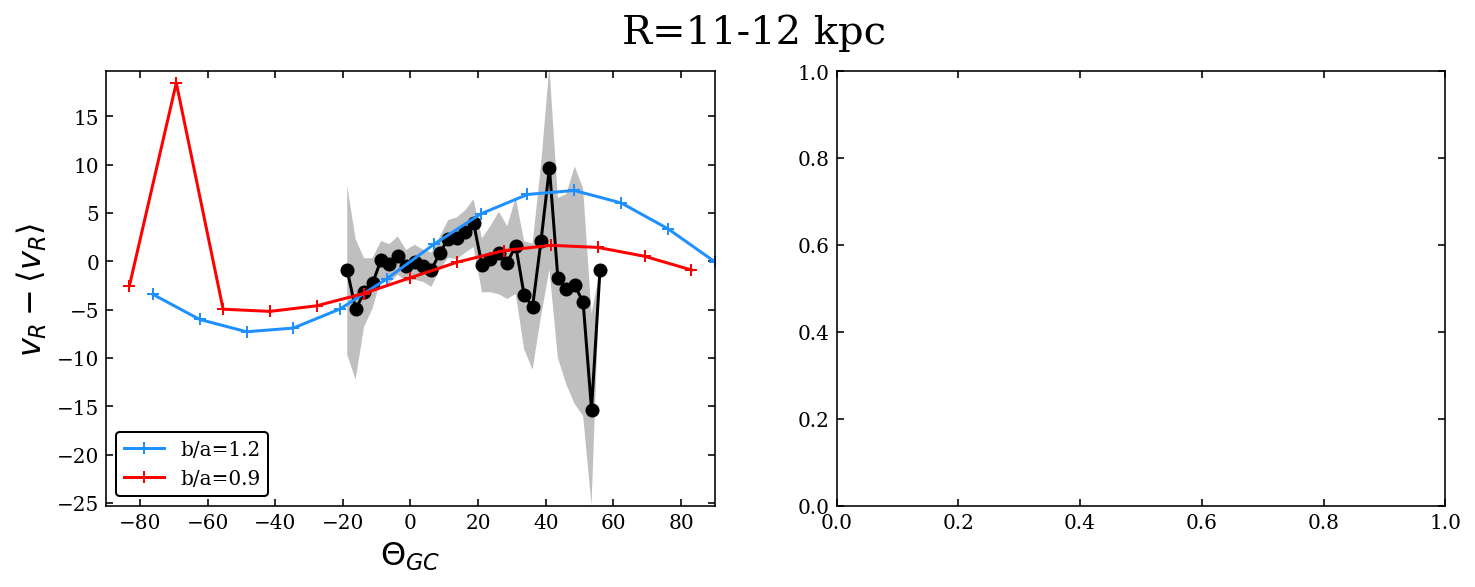

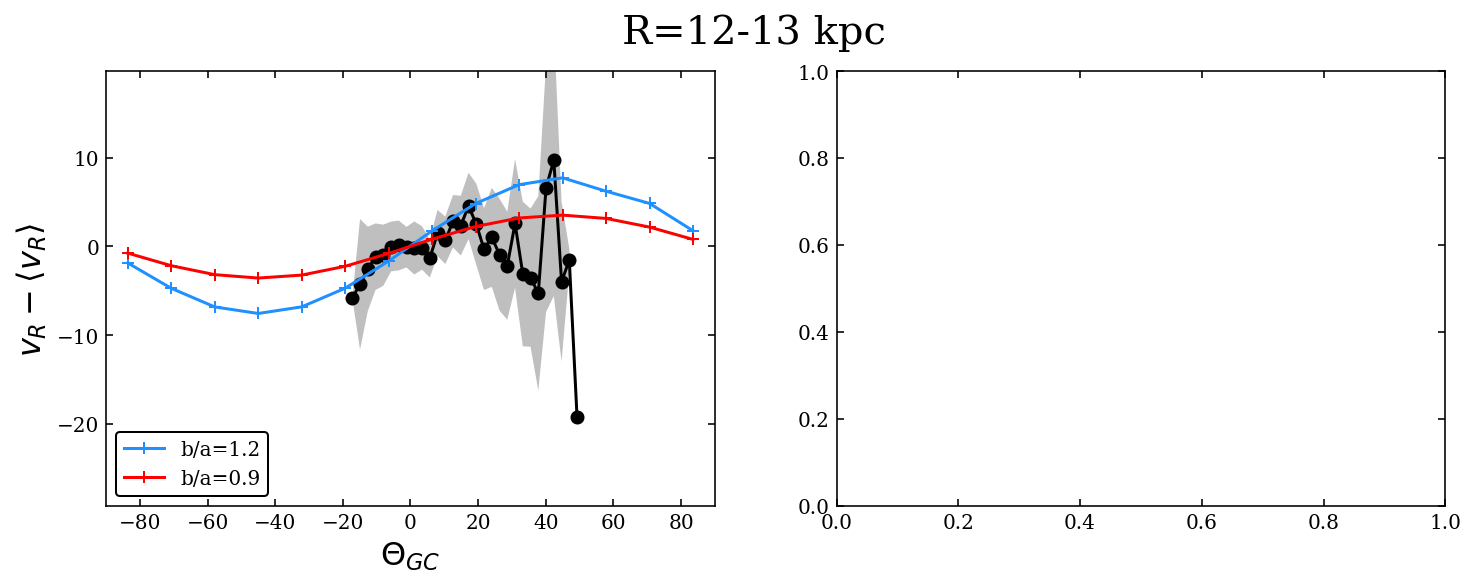

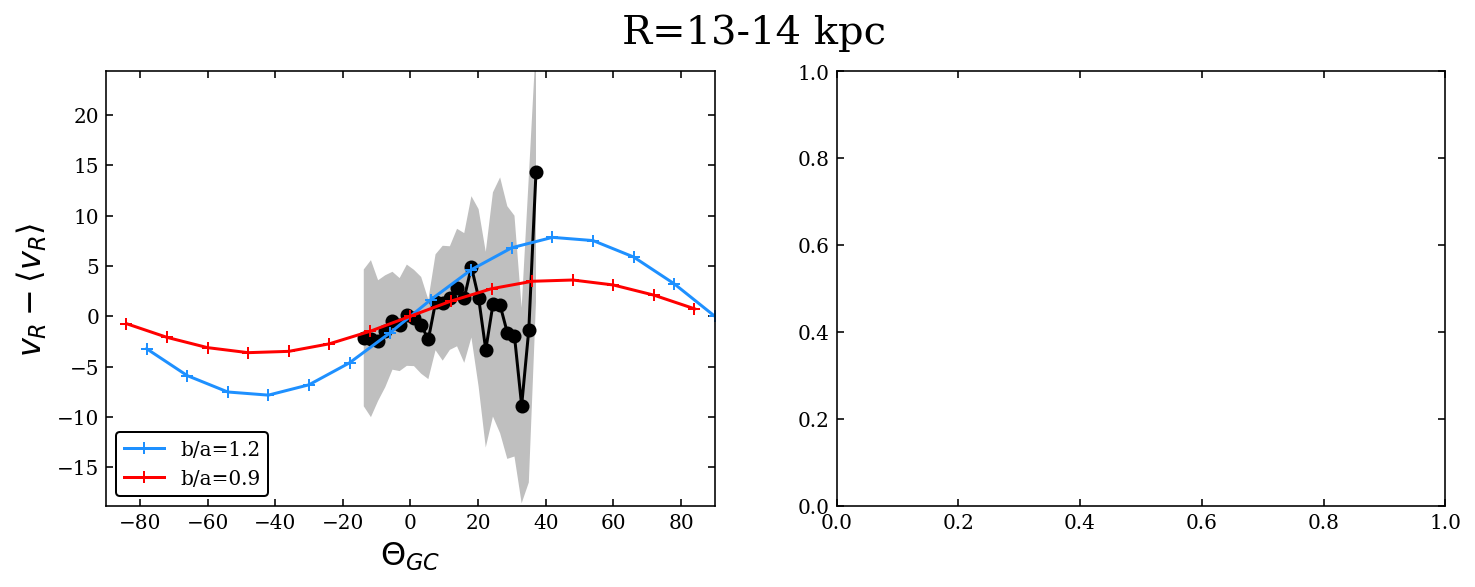

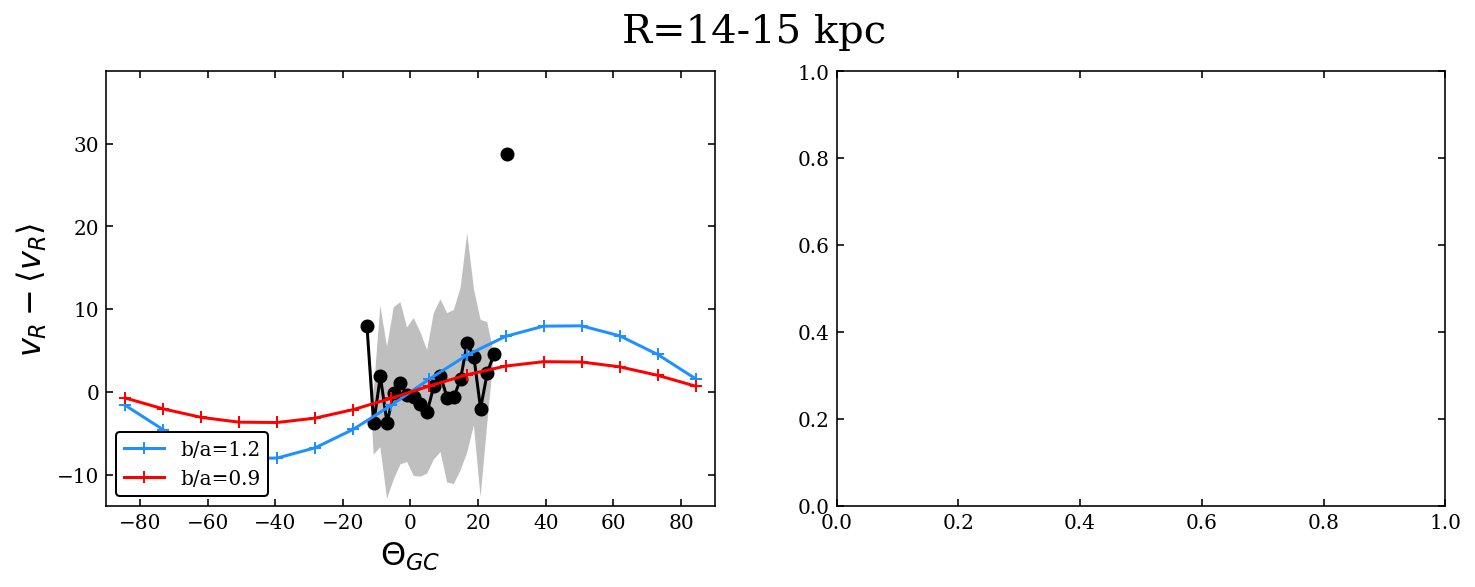

In [112]:
# Now loop over each radial bin
for i in range( len(R_range) ):
    
    # Bootstrap over the samples
    for j in range(n_bs):
        
        # Take a random sub-sample of Gaia stars
        sample = np.random.randint(0,len(gc_x),len(gc_x))
        samp_gc_R = gc_R[sample]
        samp_gc_az = gc_phi[sample]
        samp_gc_vR = gc_vR[sample]
        
        # Select the stars in this bin
        stars_in_bin = np.where(  (samp_gc_R > R_range[i]) & (samp_gc_R < (R_range[i]+R_bin_size) ) )[0]
        gcvr_in_bin = -gc_vR[stars_in_bin]
        gcaz_in_bin = gc_az[stars_in_bin]

        # Figure out the angular size of 0.5 kpc
        spec_az_size = 0.5/(R_range[i]+R_bin_size/2)
        n_az_bins = int( np.pi/180*(az_range[-1]-az_range[0]) /spec_az_size )
        az_low = -int(n_az_bins/2)*spec_az_size * 180/np.pi
        az_hi = (n_az_bins-int(n_az_bins/2))*spec_az_size * 180/np.pi

        # Bin in azimuth
        binned_vr, bin_edges, _ = binned_statistic(gcaz_in_bin, gcvr_in_bin, bins=n_az_bins, statistic='mean', 
                                                   range=(az_low, az_hi))
        vr_bin_cents = ( bin_edges[:-1] + bin_edges[1:] ) / 2

        # Make a number histogram to examine whether there is enough stars for a valid measurement
        binned_n, binned_n_edges, = np.histogram(gcaz_in_bin, bins=n_az_bins, range=(az_low, az_hi))
        where_low_bin_numbers = np.where(binned_n < 10)
        binned_vr[where_low_bin_numbers] = np.nan

        # Find where there was data
        # pdb.set_trace()
        where_data = np.where( np.isfinite(binned_vr) )
        where_no_data = np.where( np.isnan(binned_vr) )
        binned_vr[ where_no_data ] = np.nan

        # Subtract off mean where non-zero
        mean_binned_vr = np.nanmean( binned_vr[where_data] )
        binned_vr = binned_vr - mean_binned_vr
#         binned_vr[where_no_data] = 0
    
        # Get the power spectrum
        ks, pk, phase = ast1501.fourier.psd(binned_vr, az_bin_size*np.pi/180, pad=False, return_phase=True)
        
        if j == 0:
            bs_az = np.zeros((n_bs, len(vr_bin_cents)))
            bs_vR = np.zeros((n_bs, len(binned_vr)))
            bs_k_vR = np.zeros((n_bs, len(ks)))
            bs_pk_vR = np.zeros((n_bs, len(pk)))
        ##fi
        bs_az[j] = vr_bin_cents
        bs_vR[j] = binned_vr
        bs_k_vR[j] = ks
        bs_pk_vR[j] = pk
    
    
    # Take the average and standard deviation of the azimuthal profile
    bs_avg_vR = np.nanmean(bs_vR, axis=0)
    bs_std_vR = np.nanstd(bs_vR, axis=0)
    
    # Take the average and standard deviation of the power spectrum
    bs_avg_pk_vR = np.nanmean(bs_pk_vR, axis=0)
    bs_std_pk_vR = np.nanstd(bs_pk_vR, axis=0)
    
    # Plot
    fig = plt.figure( figsize=(12,4) )
    ax1, ax2 = fig.subplots(nrows=1, ncols=2)
    
    ax1.plot(bs_az[0], bs_avg_vR, color='Black', marker='o')
    ax1.fill_between( bs_az[0], bs_avg_vR+bs_std_vR, bs_avg_vR-bs_std_vR, alpha=0.5, facecolor='Grey' )
    
    ax1.set_xlabel(r'$\Theta_{GC}$', fontsize=16)
    ax1.set_ylabel(r'$v_{R}- \langle {v_{R}} \rangle$', fontsize=16)
    ax1.set_xlim(-90,90)
    ax1.set_ylim( np.nanmin(bs_avg_vR)-10, np.nanmax(bs_avg_vR)+10 )
    
    # Look for the simulation data
    index_radius = 0
    for k in range( sim_halo_data_b12.shape[0] ):
        if sim_halo_data_b12[k][0] == R_range_cents[i]:
            index_radius = k
        ##fi
    ###k
    
    sim_vr_data_b12 = sim_halo_data_b12[index_radius][2]
    sim_vr_data_b12 -= np.mean(sim_vr_data_b12)
    sim_az_data_b12 = sim_halo_data_b12[index_radius][1] * 180/np.pi
    
    # Apply a phase shift
    phase_shift = 90
    sim_az_data_b12 += phase_shift
    for l in range( len(sim_vr_data_b12) ):
        if sim_az_data_b12[l] >= 90:
            sim_az_data_b12[l] -= 180
        ##fi
    ###i
    sort_sim_az_data_b12 = np.argsort(sim_az_data_b12)
    sim_vr_data_b12 = sim_vr_data_b12[sort_sim_az_data_b12]
    sim_az_data_b12 = sim_az_data_b12[sort_sim_az_data_b12]
    
    ax1.plot(sim_az_data_b12, sim_vr_data_b12, color='DodgerBlue', marker='+', label='b/a=1.2')
    
    # Look for the simulation data
    index_radius = 0
    for k in range( sim_halo_data_b09.shape[0] ):
        if sim_halo_data_b09[k][0] == R_range_cents[i]:
            index_radius = k
        ##fi
    ###k
    
    sim_vr_data_b09 = sim_halo_data_b09[index_radius][2]
    sim_vr_data_b09 -= np.mean(sim_vr_data_b09)
    sim_az_data_b09 = sim_halo_data_b09[index_radius][1] * 180/np.pi
    
    # Apply a phase shift
    phase_shift = 0
    sim_az_data_b09 += phase_shift
    for l in range( len(sim_vr_data_b09) ):
        if sim_az_data_b09[l] >= 90:
            sim_az_data_b09[l] -= 180
        ##fi
    ###i
    sort_sim_az_data_b09 = np.argsort(sim_az_data_b09)
    sim_vr_data_b09 = sim_vr_data_b09[sort_sim_az_data_b09]
    sim_az_data_b09 = sim_az_data_b09[sort_sim_az_data_b09]
    
    ax1.plot(sim_az_data_b09, sim_vr_data_b09, color='Red', marker='+', label='b/a=0.9')
    ax1.legend(loc='upper left')
    
    ax2.plot(np.log10(ks[round(len(ks)/2)+1:]), np.sqrt(4*np.pi*pk[round(len(ks)/2)+1:]), color='Black', marker='o')
    ax2.set_xlabel(r'$k$', fontsize=16)
    ax2.set_ylabel('Power', fontsize=16)
    ax2.set_ylim(0,10)
    
    ax3.plot( np.log10(ks[round(len(ks)/2)+1:]), phase[round(len(ks)/2)+1:], color='Black', marker='o')
    ax3.set_xlabel(r'$k$', fontsize=16)
    ax3.set_ylabel('Phase', fontsize=16)
    
    fig.suptitle('R='+str(int(R_range[i]))+'-'+str(int(R_range[i]+R_bin_size))+' kpc', fontsize=20)
    
    plt.show()
    plt.close('all')
###i

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)



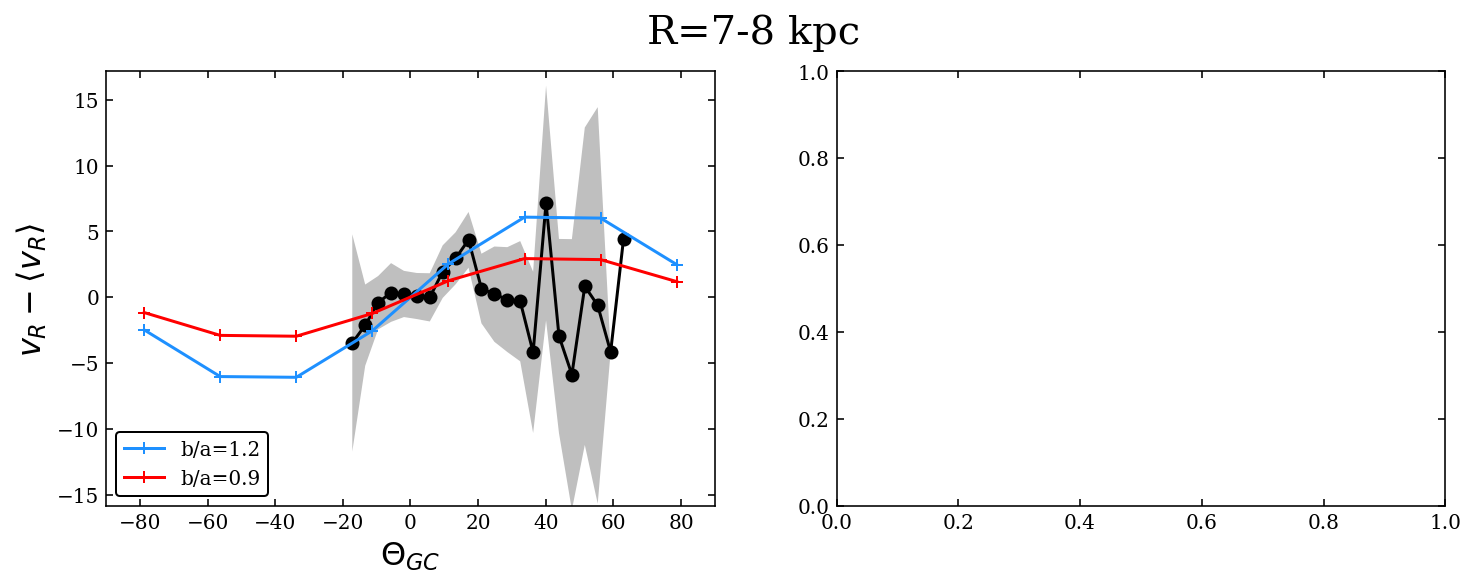

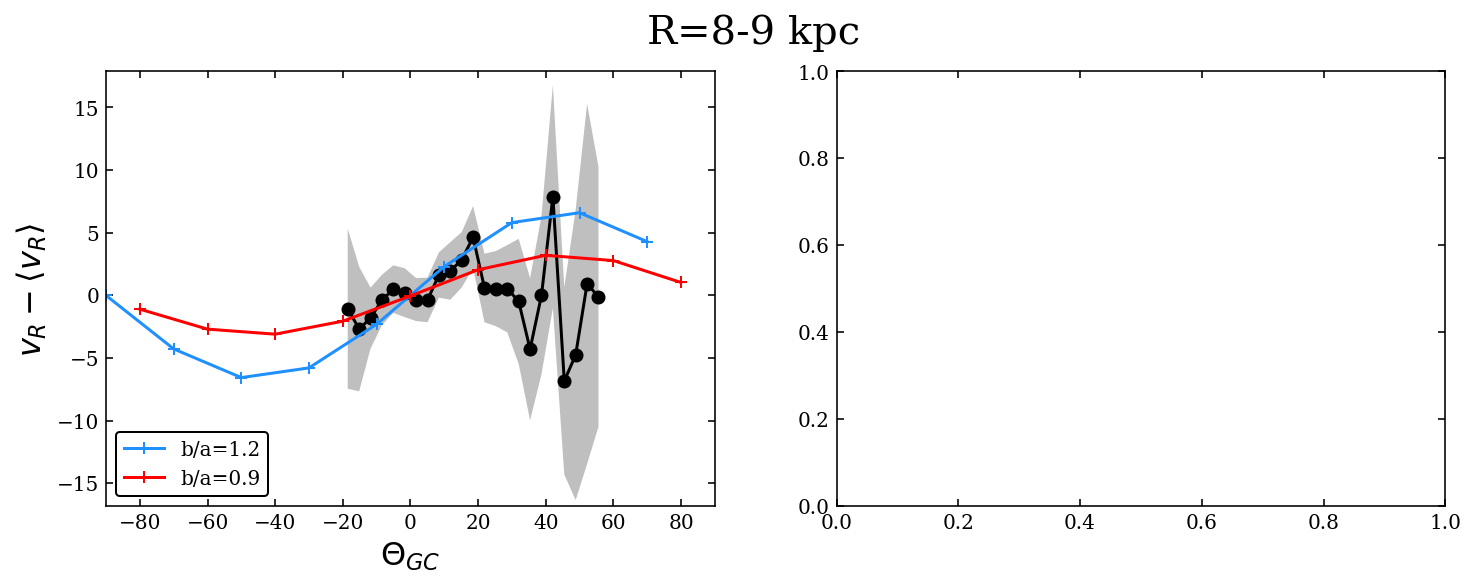

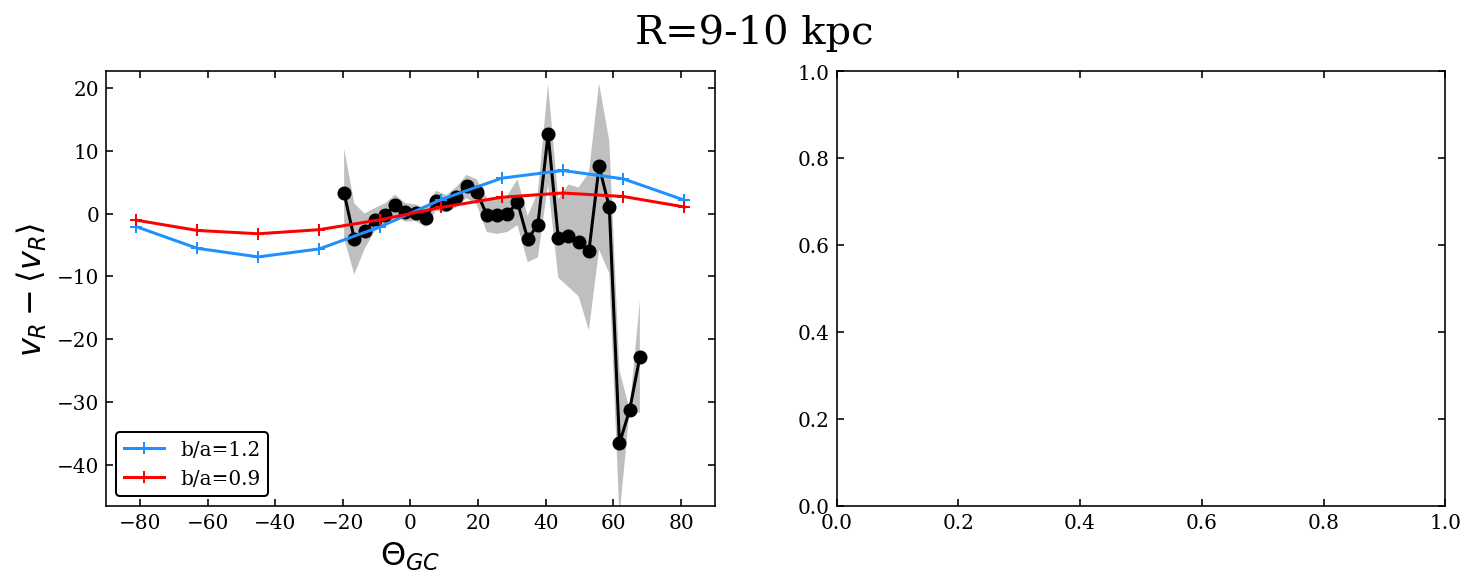

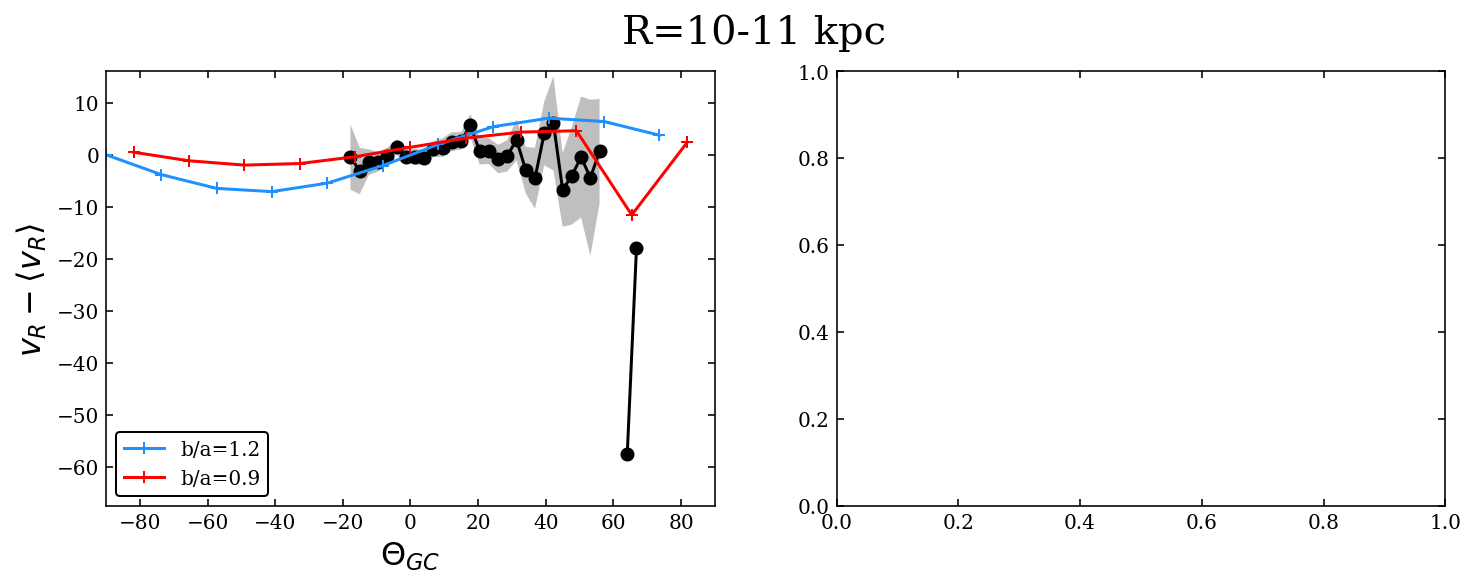

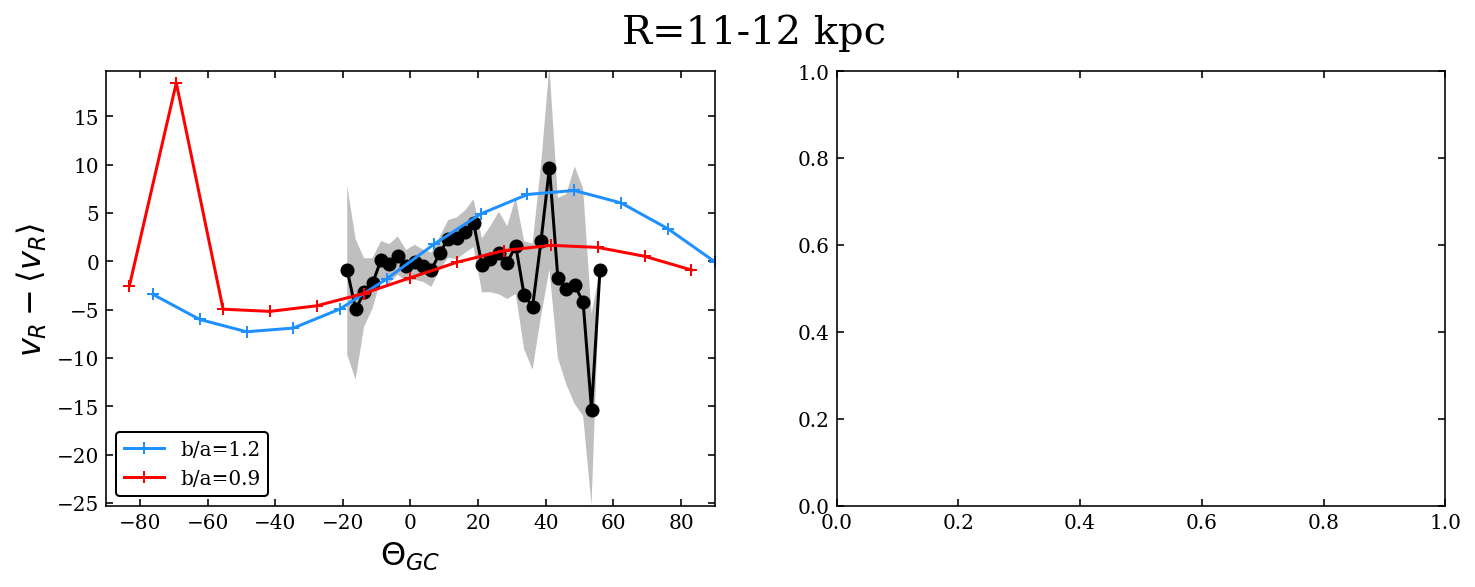

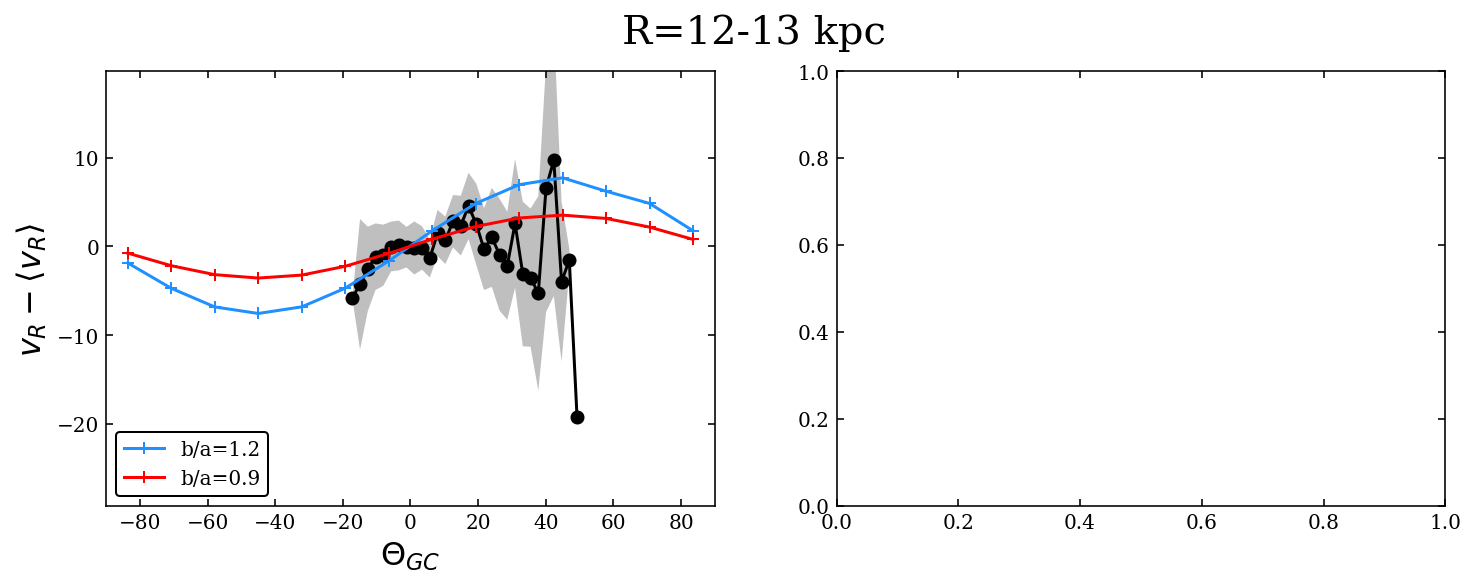

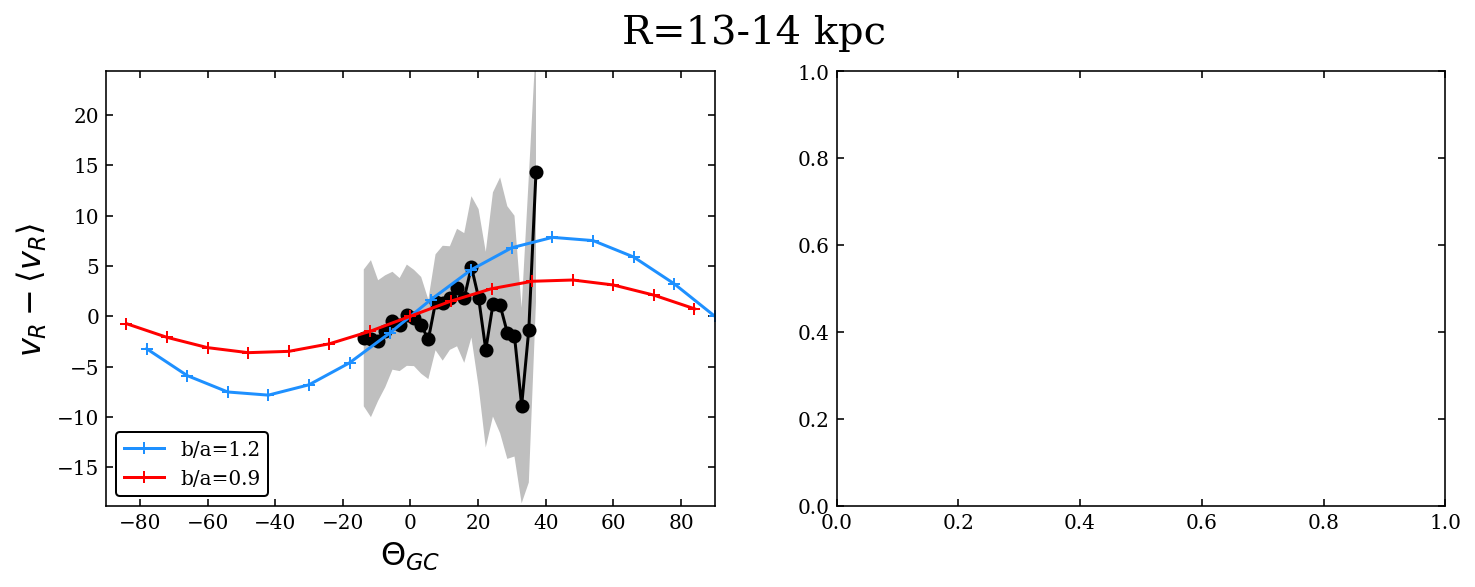

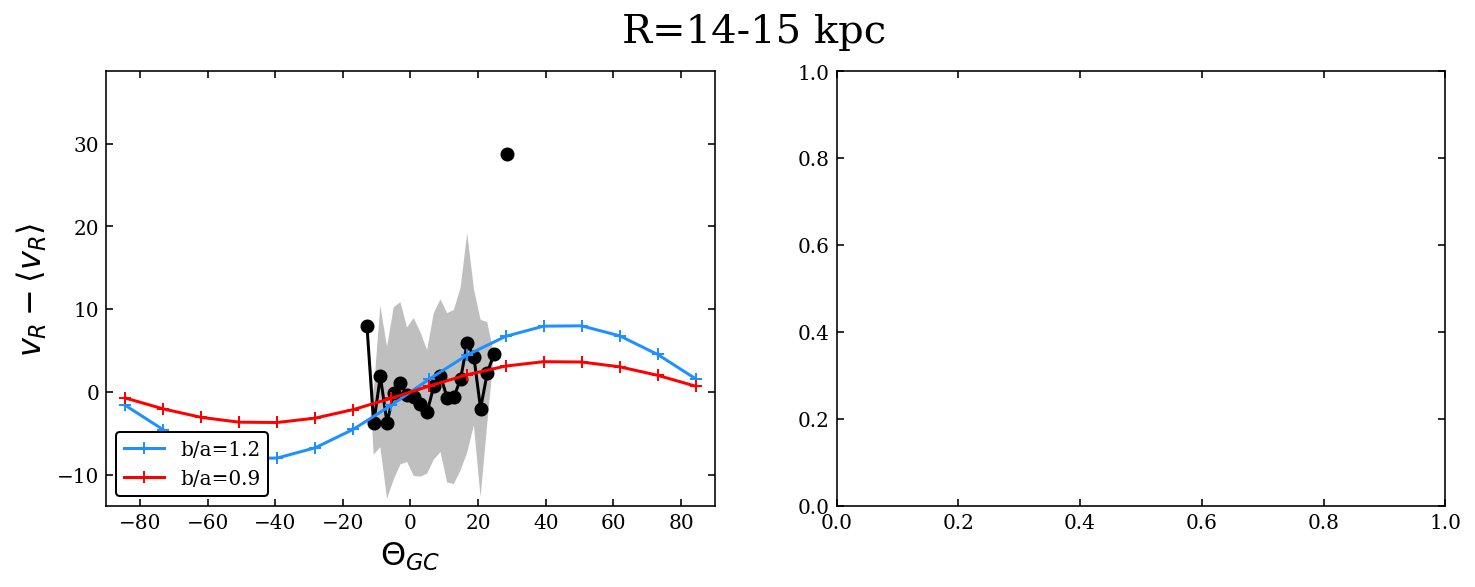

In [112]:
# Plot
fig1 = plt.figure( figsize=(5,12) )
axs1 = fig1.subplots(nrows=5, ncols=1)

fig2 = plt.figure( figsize=(5,12) )
axs2 = fig2.subplots(nrows=5, ncols=1)

# Now loop over each radial bin
for i in range( len(R_range) ):
    
    # Bootstrap over the samples
    for j in range(n_bs):
        
        # Take a random sub-sample of Gaia stars
        sample = np.random.randint(0,len(gc_x),len(gc_x))
        samp_gc_R = gc_R[sample]
        samp_gc_az = gc_phi[sample]
        samp_gc_vR = gc_vR[sample]
        
        # Select the stars in this bin
        stars_in_bin = np.where(  (samp_gc_R > R_range[i]) & (samp_gc_R < (R_range[i]+R_bin_size) ) )[0]
        gcvr_in_bin = -gc_vR[stars_in_bin]
        gcaz_in_bin = gc_az[stars_in_bin]

        # Figure out the angular size of 0.5 kpc
        spec_az_size = 0.5/(R_range[i]+R_bin_size/2)
        n_az_bins = int( np.pi/180*(az_range[-1]-az_range[0]) /spec_az_size )
        az_low = -int(n_az_bins/2)*spec_az_size * 180/np.pi
        az_hi = (n_az_bins-int(n_az_bins/2))*spec_az_size * 180/np.pi

        # Bin in azimuth
        binned_vr, bin_edges, _ = binned_statistic(gcaz_in_bin, gcvr_in_bin, bins=n_az_bins, statistic='mean', 
                                                   range=(az_low, az_hi))
        vr_bin_cents = ( bin_edges[:-1] + bin_edges[1:] ) / 2

        # Make a number histogram to examine whether there is enough stars for a valid measurement
        binned_n, binned_n_edges, = np.histogram(gcaz_in_bin, bins=n_az_bins, range=(az_low, az_hi))
        where_low_bin_numbers = np.where(binned_n < 10)
        binned_vr[where_low_bin_numbers] = np.nan

        # Find where there was data
        # pdb.set_trace()
        where_data = np.where( np.isfinite(binned_vr) )
        where_no_data = np.where( np.isnan(binned_vr) )
        binned_vr[ where_no_data ] = np.nan

        # Subtract off mean where non-zero
        mean_binned_vr = np.nanmean( binned_vr[where_data] )
        binned_vr = binned_vr - mean_binned_vr
#         binned_vr[where_no_data] = 0
    
        # Get the power spectrum
        ks, pk, phase = ast1501.fourier.psd(binned_vr, az_bin_size*np.pi/180, pad=False, return_phase=True)
        
        if j == 0:
            bs_az = np.zeros((n_bs, len(vr_bin_cents)))
            bs_vR = np.zeros((n_bs, len(binned_vr)))
            bs_k_vR = np.zeros((n_bs, len(ks)))
            bs_pk_vR = np.zeros((n_bs, len(pk)))
        ##fi
        bs_az[j] = vr_bin_cents
        bs_vR[j] = binned_vr
        bs_k_vR[j] = ks
        bs_pk_vR[j] = pk
    
    
    # Take the average and standard deviation of the azimuthal profile
    bs_avg_vR = np.nanmean(bs_vR, axis=0)
    bs_std_vR = np.nanstd(bs_vR, axis=0)
    
    # Take the average and standard deviation of the power spectrum
    bs_avg_pk_vR = np.nanmean(bs_pk_vR, axis=0)
    bs_std_pk_vR = np.nanstd(bs_pk_vR, axis=0)
    
    axs1[j].plot(bs_az[0], bs_avg_vR, color='Black', marker='o')
    axs1[j].fill_between( bs_az[0], bs_avg_vR+bs_std_vR, bs_avg_vR-bs_std_vR, alpha=0.5, facecolor='Grey' )
    
    axs1[j].set_xlabel(r'$\Theta_{GC}$', fontsize=16)
    axs1[j].set_ylabel(r'$v_{R}- \langle {v_{R}} \rangle$', fontsize=16)
    axs1[j].set_xlim(-90,90)
    axs1[j].set_ylim( np.nanmin(bs_avg_vR)-10, np.nanmax(bs_avg_vR)+10 )
    
    # Look for the simulation data
    index_radius = 0
    for k in range( sim_halo_data_b12.shape[0] ):
        if sim_halo_data_b12[k][0] == R_range_cents[i]:
            index_radius = k
        ##fi
    ###k
    
    sim_vr_data_b12 = sim_halo_data_b12[index_radius][2]
    sim_vr_data_b12 -= np.mean(sim_vr_data_b12)
    sim_az_data_b12 = sim_halo_data_b12[index_radius][1] * 180/np.pi
    
    # Apply a phase shift
    phase_shift = 90
    sim_az_data_b12 += phase_shift
    for l in range( len(sim_vr_data_b12) ):
        if sim_az_data_b12[l] >= 90:
            sim_az_data_b12[l] -= 180
        ##fi
    ###i
    sort_sim_az_data_b12 = np.argsort(sim_az_data_b12)
    sim_vr_data_b12 = sim_vr_data_b12[sort_sim_az_data_b12]
    sim_az_data_b12 = sim_az_data_b12[sort_sim_az_data_b12]
    
    ax1.plot(sim_az_data_b12, sim_vr_data_b12, color='DodgerBlue', marker='+', label='b/a=1.2')
    
    # Look for the simulation data
    index_radius = 0
    for k in range( sim_halo_data_b09.shape[0] ):
        if sim_halo_data_b09[k][0] == R_range_cents[i]:
            index_radius = k
        ##fi
    ###k
    
    sim_vr_data_b09 = sim_halo_data_b09[index_radius][2]
    sim_vr_data_b09 -= np.mean(sim_vr_data_b09)
    sim_az_data_b09 = sim_halo_data_b09[index_radius][1] * 180/np.pi
    
    # Apply a phase shift
    phase_shift = 0
    sim_az_data_b09 += phase_shift
    for l in range( len(sim_vr_data_b09) ):
        if sim_az_data_b09[l] >= 90:
            sim_az_data_b09[l] -= 180
        ##fi
    ###i
    sort_sim_az_data_b09 = np.argsort(sim_az_data_b09)
    sim_vr_data_b09 = sim_vr_data_b09[sort_sim_az_data_b09]
    sim_az_data_b09 = sim_az_data_b09[sort_sim_az_data_b09]
    
    ax1.plot(sim_az_data_b09, sim_vr_data_b09, color='Red', marker='+', label='b/a=0.9')
    ax1.legend(loc='upper left')
    
    ax2.plot(np.log10(ks[round(len(ks)/2)+1:]), np.sqrt(4*np.pi*pk[round(len(ks)/2)+1:]), color='Black', marker='o')
    ax2.set_xlabel(r'$k$', fontsize=16)
    ax2.set_ylabel('Power', fontsize=16)
    ax2.set_ylim(0,10)
    
    ax3.plot( np.log10(ks[round(len(ks)/2)+1:]), phase[round(len(ks)/2)+1:], color='Black', marker='o')
    ax3.set_xlabel(r'$k$', fontsize=16)
    ax3.set_ylabel('Phase', fontsize=16)
    
    fig.suptitle('R='+str(int(R_range[i]))+'-'+str(int(R_range[i]+R_bin_size))+' kpc', fontsize=20)
    
    plt.show()
    plt.close('all')
###i

## Now examine Tangential Velocity profile with a cosine fit